## Импорты

In [2]:
import pandas as pd


import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller

import datetime
from dateutil.relativedelta import relativedelta

from arch import arch_model

p = print

C:\Pythonn\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
import keras

C:\Pythonn\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
import matplotlib.pylab as plt
import seaborn as sns
sns.despine()

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Merge
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers

import theano
theano.config.compute_test_value = "ignore"

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Pythonn\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [5]:
import copy

In [6]:
df = pd.read_csv('df')

In [7]:
df.index.name=None
df.reset_index(inplace=True)

In [8]:
start = datetime.datetime.strptime("2012-09-09", "%Y-%m-%d")
date_list = [start + relativedelta(weeks=x) for x in range(0,len(df.sales))]
df['index'] =date_list
df.set_index(['index'], inplace=True)
df.index.name=None

In [9]:
df.head()

,ind,dates,sales,AUP_RUR,AUP_RUR_RRP,AUP+bonus
2012-09-09,1,2012-09-09,23,5658.513739,9619.448357,6612.109391
2012-09-16,2,2012-09-16,10,6065.175200,10238.858811,6762.978200
2012-09-23,3,2012-09-23,9,5876.925926,9058.186700,6231.744815
2012-09-30,4,2012-09-30,4,5319.947500,9415.000000,6163.250000
2012-10-07,5,2012-10-07,4,6731.930000,9415.000000,6807.750000


In [10]:
data = copy.deepcopy(df['sales'])

In [11]:
data.head()

2012-09-09    23
2012-09-16    10
2012-09-23     9
2012-09-30     4
2012-10-07     4
Name: sales, dtype: int64

## Классификация

### написание функций для разбивки

In [10]:
def  shuffle_in_unison (a, b):

    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b
 
def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test

хорошие результаты получали при трейн/тест 90/10(дефолт) и 80/20
окно изменили на 26 с 52 - это увеличило точность на 10% в среднем и без переобучения
dense input - 64 по дефолту. поменял зачем-то, надо потестировать

In [413]:
WINDOW = 26
STEP = 1
FORECAST = 5


X, Y = [], []
for i in range(0, len(data), STEP): 
    try:
        x_i = data[i:i+WINDOW]
        y_i = data[i+WINDOW+FORECAST]  

        last_close = x_i[WINDOW-1]
        next_close = y_i

        if last_close < next_close:
            y_i = [1, 0]
        else:
            y_i = [0, 1] 

    except Exception as e:
        print (e)
        break

    X.append(x_i)
    Y.append(y_i)

#X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X] # будем использовать для регрессии
X, Y = np.array(X), np.array(Y)

X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

index out of bounds


### модель простая

In [50]:
model = Sequential()
model.add(Dense(64, input_dim=WINDOW))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))

In [56]:
opt = Nadam(lr=0.0001)

In [57]:
model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [58]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 350, 
          batch_size = 15, 
          verbose=2, 
          validation_data=(X_test, Y_test),
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 250 samples, validate on 28 samples
Epoch 1/350
 - 1s - loss: 0.1608 - acc: 0.9280 - val_loss: 0.5624 - val_acc: 0.7857
Epoch 2/350
 - 0s - loss: 0.1606 - acc: 0.9280 - val_loss: 0.5615 - val_acc: 0.7857
Epoch 3/350
 - 0s - loss: 0.1600 - acc: 0.9280 - val_loss: 0.5629 - val_acc: 0.7857
Epoch 4/350
 - 0s - loss: 0.1596 - acc: 0.9280 - val_loss: 0.5611 - val_acc: 0.7857
Epoch 5/350
 - 0s - loss: 0.1592 - acc: 0.9280 - val_loss: 0.5598 - val_acc: 0.7857
Epoch 6/350
 - 0s - loss: 0.1584 - acc: 0.9280 - val_loss: 0.5585 - val_acc: 0.7857
Epoch 7/350
 - 0s - loss: 0.1574 - acc: 0.9280 - val_loss: 0.5594 - val_acc: 0.7857
Epoch 8/350
 - 0s - loss: 0.1571 - acc: 0.9280 - val_loss: 0.5594 - val_acc: 0.7857
Epoch 9/350
 - 0s - loss: 0.1568 - acc: 0.9280 - val_loss: 0.5620 - val_acc: 0.7857
Epoch 10/350
 - 0s - loss: 0.1565 - acc: 0.9280 - val_loss: 0.5556 - val_acc: 0.7857
Epoch 11/350
 - 0s - loss: 0.1564 - acc: 0.9280 - val_loss: 0.5545 - val_acc: 0.7857
Epoch 12/350
 - 0s - loss: 0.

Epoch 97/350
 - 0s - loss: 0.1506 - acc: 0.9320 - val_loss: 0.5532 - val_acc: 0.7857
Epoch 98/350
 - 0s - loss: 0.1521 - acc: 0.9320 - val_loss: 0.5489 - val_acc: 0.7857
Epoch 99/350
 - 0s - loss: 0.1517 - acc: 0.9320 - val_loss: 0.5490 - val_acc: 0.7857
Epoch 100/350
 - 0s - loss: 0.1516 - acc: 0.9320 - val_loss: 0.5431 - val_acc: 0.7857
Epoch 101/350
 - 0s - loss: 0.1514 - acc: 0.9320 - val_loss: 0.5457 - val_acc: 0.7857
Epoch 102/350
 - 0s - loss: 0.1507 - acc: 0.9320 - val_loss: 0.5459 - val_acc: 0.7857
Epoch 103/350
 - 0s - loss: 0.1506 - acc: 0.9320 - val_loss: 0.5469 - val_acc: 0.7857
Epoch 104/350
 - 0s - loss: 0.1506 - acc: 0.9320 - val_loss: 0.5404 - val_acc: 0.7857
Epoch 105/350
 - 0s - loss: 0.1511 - acc: 0.9320 - val_loss: 0.5472 - val_acc: 0.7500
Epoch 106/350
 - 0s - loss: 0.1503 - acc: 0.9320 - val_loss: 0.5514 - val_acc: 0.7500
Epoch 107/350
 - 0s - loss: 0.1509 - acc: 0.9320 - val_loss: 0.5459 - val_acc: 0.7857
Epoch 108/350
 - 0s - loss: 0.1506 - acc: 0.9320 - val_lo

Epoch 193/350
 - 0s - loss: 0.1413 - acc: 0.9560 - val_loss: 0.5181 - val_acc: 0.7500
Epoch 194/350
 - 0s - loss: 0.1411 - acc: 0.9600 - val_loss: 0.5179 - val_acc: 0.7500
Epoch 195/350
 - 0s - loss: 0.1410 - acc: 0.9600 - val_loss: 0.5191 - val_acc: 0.7500
Epoch 196/350
 - 0s - loss: 0.1409 - acc: 0.9600 - val_loss: 0.5173 - val_acc: 0.7500
Epoch 197/350
 - 0s - loss: 0.1409 - acc: 0.9600 - val_loss: 0.5175 - val_acc: 0.7500
Epoch 198/350
 - 0s - loss: 0.1408 - acc: 0.9600 - val_loss: 0.5173 - val_acc: 0.7500
Epoch 199/350
 - 0s - loss: 0.1407 - acc: 0.9600 - val_loss: 0.5182 - val_acc: 0.7500
Epoch 200/350
 - 0s - loss: 0.1407 - acc: 0.9600 - val_loss: 0.5140 - val_acc: 0.7500
Epoch 201/350
 - 0s - loss: 0.1406 - acc: 0.9600 - val_loss: 0.5158 - val_acc: 0.7500
Epoch 202/350
 - 0s - loss: 0.1405 - acc: 0.9600 - val_loss: 0.5168 - val_acc: 0.7500
Epoch 203/350
 - 0s - loss: 0.1405 - acc: 0.9560 - val_loss: 0.5163 - val_acc: 0.7500
Epoch 204/350
 - 0s - loss: 0.1405 - acc: 0.9600 - val

Epoch 289/350
 - 0s - loss: 0.1326 - acc: 0.9560 - val_loss: 0.5455 - val_acc: 0.7143
Epoch 290/350
 - 0s - loss: 0.1326 - acc: 0.9560 - val_loss: 0.5390 - val_acc: 0.7143
Epoch 291/350
 - 0s - loss: 0.1325 - acc: 0.9560 - val_loss: 0.5402 - val_acc: 0.7143
Epoch 292/350
 - 0s - loss: 0.1324 - acc: 0.9560 - val_loss: 0.5428 - val_acc: 0.7143
Epoch 293/350
 - 0s - loss: 0.1323 - acc: 0.9560 - val_loss: 0.5475 - val_acc: 0.7143
Epoch 294/350
 - 0s - loss: 0.1323 - acc: 0.9560 - val_loss: 0.5501 - val_acc: 0.7143
Epoch 295/350
 - 0s - loss: 0.1322 - acc: 0.9560 - val_loss: 0.5504 - val_acc: 0.7143
Epoch 296/350
 - 0s - loss: 0.1321 - acc: 0.9560 - val_loss: 0.5478 - val_acc: 0.7143
Epoch 297/350
 - 0s - loss: 0.1320 - acc: 0.9560 - val_loss: 0.5482 - val_acc: 0.7143
Epoch 298/350
 - 0s - loss: 0.1320 - acc: 0.9560 - val_loss: 0.5480 - val_acc: 0.7143
Epoch 299/350
 - 0s - loss: 0.1321 - acc: 0.9560 - val_loss: 0.5400 - val_acc: 0.7143
Epoch 300/350
 - 0s - loss: 0.1320 - acc: 0.9560 - val

#### графики

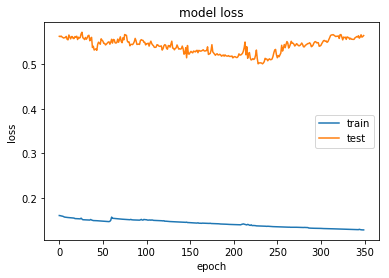

In [59]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

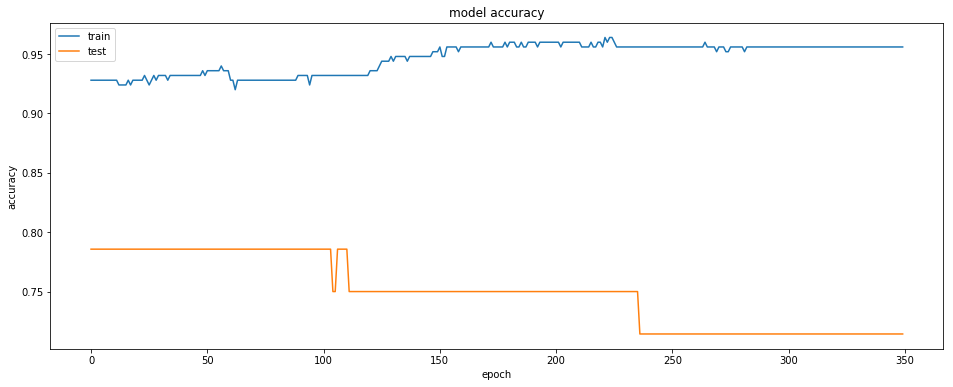

In [60]:
plt.figure(figsize=(16,6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

### модель посложнее, добавили слой, два сигмоида

In [233]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW))
model.add(Activation('sigmoid'))
model.add(Dense(360))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))

In [234]:
opt = Nadam(lr=0.0001)

In [235]:
model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [236]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 550, 
          batch_size = 15, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 250 samples, validate on 28 samples
Epoch 1/550
250/250 [==============================] - 1s 5ms/step - loss: 0.6679 - acc: 0.5600 - val_loss: 0.7056 - val_acc: 0.3571
Epoch 2/550
250/250 [==============================] - 0s 172us/step - loss: 0.6209 - acc: 0.6960 - val_loss: 0.6781 - val_acc: 0.5357
Epoch 3/550
250/250 [==============================] - 0s 168us/step - loss: 0.5829 - acc: 0.7560 - val_loss: 0.6549 - val_acc: 0.6071
Epoch 4/550
250/250 [==============================] - 0s 164us/step - loss: 0.5487 - acc: 0.7880 - val_loss: 0.6300 - val_acc: 0.7500
Epoch 5/550
250/250 [==============================] - 0s 183us/step - loss: 0.5205 - acc: 0.7840 - val_loss: 0.6147 - val_acc: 0.6786
Epoch 6/550
250/250 [==============================] - 0s 164us/step - loss: 0.4981 - acc: 0.7800 - val_loss: 0.6053 - val_acc: 0.6786
Epoch 7/550
250/250 [==============================] - 0s 160us/step - loss: 0.4770 - acc: 0.7800 - val_loss: 0.5956 - val_acc: 0.7143
Epoch 8/550


Epoch 61/550
250/250 [==============================] - 0s 144us/step - loss: 0.2586 - acc: 0.8760 - val_loss: 0.5309 - val_acc: 0.7143
Epoch 62/550
250/250 [==============================] - 0s 148us/step - loss: 0.2565 - acc: 0.8680 - val_loss: 0.5368 - val_acc: 0.7143
Epoch 63/550
250/250 [==============================] - 0s 152us/step - loss: 0.2535 - acc: 0.8800 - val_loss: 0.5360 - val_acc: 0.6786
Epoch 64/550
250/250 [==============================] - 0s 160us/step - loss: 0.2510 - acc: 0.8760 - val_loss: 0.5341 - val_acc: 0.7143
Epoch 65/550
250/250 [==============================] - 0s 160us/step - loss: 0.2502 - acc: 0.8840 - val_loss: 0.5420 - val_acc: 0.6786
Epoch 66/550
250/250 [==============================] - 0s 156us/step - loss: 0.2492 - acc: 0.8800 - val_loss: 0.5299 - val_acc: 0.6786
Epoch 67/550
250/250 [==============================] - 0s 148us/step - loss: 0.2469 - acc: 0.8800 - val_loss: 0.5301 - val_acc: 0.6786
Epoch 68/550
250/250 [==========================

250/250 [==============================] - 0s 172us/step - loss: 0.1655 - acc: 0.9440 - val_loss: 0.5535 - val_acc: 0.6786
Epoch 122/550
250/250 [==============================] - 0s 164us/step - loss: 0.1631 - acc: 0.9480 - val_loss: 0.5425 - val_acc: 0.7143
Epoch 123/550
250/250 [==============================] - 0s 176us/step - loss: 0.1631 - acc: 0.9560 - val_loss: 0.5454 - val_acc: 0.6786
Epoch 124/550
250/250 [==============================] - 0s 184us/step - loss: 0.1612 - acc: 0.9520 - val_loss: 0.5632 - val_acc: 0.6786
Epoch 125/550
250/250 [==============================] - 0s 164us/step - loss: 0.1597 - acc: 0.9520 - val_loss: 0.5699 - val_acc: 0.6786
Epoch 126/550
250/250 [==============================] - 0s 180us/step - loss: 0.1594 - acc: 0.9480 - val_loss: 0.5480 - val_acc: 0.6786
Epoch 127/550
250/250 [==============================] - 0s 152us/step - loss: 0.1571 - acc: 0.9560 - val_loss: 0.5549 - val_acc: 0.6786
Epoch 128/550
250/250 [==============================] 

Epoch 181/550
250/250 [==============================] - 0s 140us/step - loss: 0.0952 - acc: 0.9920 - val_loss: 0.6384 - val_acc: 0.6786
Epoch 182/550
250/250 [==============================] - 0s 148us/step - loss: 0.0939 - acc: 0.9920 - val_loss: 0.6416 - val_acc: 0.6786
Epoch 183/550
250/250 [==============================] - 0s 195us/step - loss: 0.0929 - acc: 0.9920 - val_loss: 0.6290 - val_acc: 0.6786
Epoch 184/550
250/250 [==============================] - 0s 196us/step - loss: 0.0922 - acc: 0.9920 - val_loss: 0.6348 - val_acc: 0.6786
Epoch 185/550
250/250 [==============================] - 0s 160us/step - loss: 0.0919 - acc: 0.9920 - val_loss: 0.6421 - val_acc: 0.6786
Epoch 186/550
250/250 [==============================] - 0s 160us/step - loss: 0.0912 - acc: 0.9920 - val_loss: 0.6488 - val_acc: 0.6786
Epoch 187/550
250/250 [==============================] - 0s 152us/step - loss: 0.0906 - acc: 0.9920 - val_loss: 0.6628 - val_acc: 0.6786
Epoch 188/550
250/250 [==================

Epoch 241/550
250/250 [==============================] - 0s 148us/step - loss: 0.0561 - acc: 0.9960 - val_loss: 0.7624 - val_acc: 0.6429
Epoch 242/550
250/250 [==============================] - 0s 144us/step - loss: 0.0558 - acc: 0.9960 - val_loss: 0.7641 - val_acc: 0.6429
Epoch 243/550
250/250 [==============================] - 0s 148us/step - loss: 0.0561 - acc: 0.9960 - val_loss: 0.8003 - val_acc: 0.6071
Epoch 244/550
250/250 [==============================] - 0s 160us/step - loss: 0.0562 - acc: 0.9960 - val_loss: 0.8056 - val_acc: 0.6071
Epoch 245/550
250/250 [==============================] - 0s 144us/step - loss: 0.0545 - acc: 0.9960 - val_loss: 0.7764 - val_acc: 0.6071
Epoch 246/550
250/250 [==============================] - 0s 156us/step - loss: 0.0540 - acc: 0.9960 - val_loss: 0.7739 - val_acc: 0.6429
Epoch 247/550
250/250 [==============================] - 0s 152us/step - loss: 0.0539 - acc: 0.9960 - val_loss: 0.7903 - val_acc: 0.5714
Epoch 248/550
250/250 [==================

Epoch 301/550
250/250 [==============================] - 0s 144us/step - loss: 0.0330 - acc: 1.0000 - val_loss: 0.8583 - val_acc: 0.5714
Epoch 302/550
250/250 [==============================] - 0s 148us/step - loss: 0.0322 - acc: 1.0000 - val_loss: 0.8656 - val_acc: 0.5714
Epoch 303/550
250/250 [==============================] - 0s 164us/step - loss: 0.0324 - acc: 1.0000 - val_loss: 0.8631 - val_acc: 0.5714
Epoch 304/550
250/250 [==============================] - 0s 144us/step - loss: 0.0323 - acc: 1.0000 - val_loss: 0.8406 - val_acc: 0.5714
Epoch 305/550
250/250 [==============================] - 0s 152us/step - loss: 0.0316 - acc: 1.0000 - val_loss: 0.8123 - val_acc: 0.5714
Epoch 306/550
250/250 [==============================] - 0s 152us/step - loss: 0.0311 - acc: 1.0000 - val_loss: 0.8583 - val_acc: 0.5714
Epoch 307/550
250/250 [==============================] - 0s 148us/step - loss: 0.0315 - acc: 1.0000 - val_loss: 0.8416 - val_acc: 0.5714
Epoch 308/550
250/250 [==================

Epoch 361/550
250/250 [==============================] - 0s 144us/step - loss: 0.0195 - acc: 1.0000 - val_loss: 0.9209 - val_acc: 0.5714
Epoch 362/550
250/250 [==============================] - 0s 144us/step - loss: 0.0194 - acc: 1.0000 - val_loss: 0.9183 - val_acc: 0.5714
Epoch 363/550
250/250 [==============================] - 0s 156us/step - loss: 0.0193 - acc: 1.0000 - val_loss: 0.9163 - val_acc: 0.5714
Epoch 364/550
250/250 [==============================] - 0s 144us/step - loss: 0.0190 - acc: 1.0000 - val_loss: 0.9117 - val_acc: 0.5714
Epoch 365/550
250/250 [==============================] - 0s 156us/step - loss: 0.0190 - acc: 1.0000 - val_loss: 0.9166 - val_acc: 0.5714
Epoch 366/550
250/250 [==============================] - 0s 172us/step - loss: 0.0187 - acc: 1.0000 - val_loss: 0.9375 - val_acc: 0.5714
Epoch 367/550
250/250 [==============================] - 0s 164us/step - loss: 0.0187 - acc: 1.0000 - val_loss: 0.9271 - val_acc: 0.5714
Epoch 368/550
250/250 [==================

Epoch 421/550
250/250 [==============================] - 0s 176us/step - loss: 0.0116 - acc: 1.0000 - val_loss: 0.9814 - val_acc: 0.5714
Epoch 422/550
250/250 [==============================] - 0s 176us/step - loss: 0.0113 - acc: 1.0000 - val_loss: 0.9829 - val_acc: 0.5714
Epoch 423/550
250/250 [==============================] - 0s 184us/step - loss: 0.0115 - acc: 1.0000 - val_loss: 0.9937 - val_acc: 0.5714
Epoch 424/550
250/250 [==============================] - 0s 180us/step - loss: 0.0114 - acc: 1.0000 - val_loss: 1.0061 - val_acc: 0.5714
Epoch 425/550
250/250 [==============================] - 0s 180us/step - loss: 0.0109 - acc: 1.0000 - val_loss: 0.9444 - val_acc: 0.5714
Epoch 426/550
250/250 [==============================] - 0s 184us/step - loss: 0.0111 - acc: 1.0000 - val_loss: 0.9694 - val_acc: 0.5714
Epoch 427/550
250/250 [==============================] - 0s 184us/step - loss: 0.0109 - acc: 1.0000 - val_loss: 0.9849 - val_acc: 0.5714
Epoch 428/550
250/250 [==================

Epoch 481/550
250/250 [==============================] - 0s 203us/step - loss: 0.0070 - acc: 1.0000 - val_loss: 1.0689 - val_acc: 0.5714
Epoch 482/550
250/250 [==============================] - 0s 203us/step - loss: 0.0068 - acc: 1.0000 - val_loss: 1.0472 - val_acc: 0.5714
Epoch 483/550
250/250 [==============================] - 0s 211us/step - loss: 0.0067 - acc: 1.0000 - val_loss: 1.0414 - val_acc: 0.5714
Epoch 484/550
250/250 [==============================] - 0s 207us/step - loss: 0.0067 - acc: 1.0000 - val_loss: 1.0376 - val_acc: 0.5714
Epoch 485/550
250/250 [==============================] - 0s 203us/step - loss: 0.0066 - acc: 1.0000 - val_loss: 1.0426 - val_acc: 0.5714
Epoch 486/550
250/250 [==============================] - 0s 211us/step - loss: 0.0066 - acc: 1.0000 - val_loss: 1.0510 - val_acc: 0.5714
Epoch 487/550
250/250 [==============================] - 0s 195us/step - loss: 0.0066 - acc: 1.0000 - val_loss: 1.0487 - val_acc: 0.5714
Epoch 488/550
250/250 [==================

Epoch 541/550
250/250 [==============================] - 0s 180us/step - loss: 0.0045 - acc: 1.0000 - val_loss: 1.0332 - val_acc: 0.6071
Epoch 542/550
250/250 [==============================] - 0s 184us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.9889 - val_acc: 0.6071
Epoch 543/550
250/250 [==============================] - 0s 176us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 1.0558 - val_acc: 0.6071
Epoch 544/550
250/250 [==============================] - 0s 184us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 1.1008 - val_acc: 0.6071
Epoch 545/550
250/250 [==============================] - 0s 180us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 1.0648 - val_acc: 0.6071
Epoch 546/550
250/250 [==============================] - 0s 184us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 1.0343 - val_acc: 0.6071
Epoch 547/550
250/250 [==============================] - 0s 184us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 1.0530 - val_acc: 0.6071
Epoch 548/550
250/250 [==================

#### графики

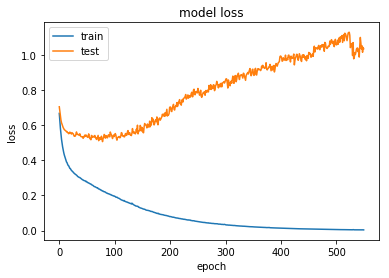

In [237]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

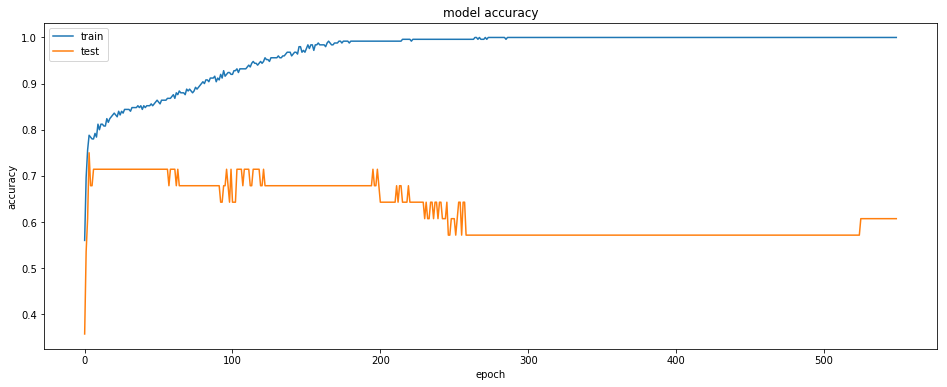

In [238]:
plt.figure(figsize=(16,6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

### модель посложнее+, добавили слой, два сигмоида, уменьшаем кол-во эпох

In [239]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW))
model.add(Activation('sigmoid'))
model.add(Dense(360))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))

In [240]:
opt = Nadam(lr=0.0001)

In [241]:
model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [242]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 250, 
          batch_size = 15, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 250 samples, validate on 28 samples
Epoch 1/250
250/250 [==============================] - 1s 5ms/step - loss: 0.6637 - acc: 0.5560 - val_loss: 0.6865 - val_acc: 0.5714
Epoch 2/250
250/250 [==============================] - 0s 164us/step - loss: 0.6127 - acc: 0.7120 - val_loss: 0.6565 - val_acc: 0.7143
Epoch 3/250
250/250 [==============================] - 0s 168us/step - loss: 0.5733 - acc: 0.7840 - val_loss: 0.6450 - val_acc: 0.7143
Epoch 4/250
250/250 [==============================] - 0s 172us/step - loss: 0.5407 - acc: 0.7440 - val_loss: 0.6250 - val_acc: 0.7143
Epoch 5/250
250/250 [==============================] - 0s 160us/step - loss: 0.5136 - acc: 0.7920 - val_loss: 0.6141 - val_acc: 0.7143
Epoch 6/250
250/250 [==============================] - 0s 156us/step - loss: 0.4889 - acc: 0.7960 - val_loss: 0.6045 - val_acc: 0.7143
Epoch 7/250
250/250 [==============================] - 0s 152us/step - loss: 0.4703 - acc: 0.8120 - val_loss: 0.5950 - val_acc: 0.7143
Epoch 8/250


Epoch 61/250
250/250 [==============================] - 0s 148us/step - loss: 0.2538 - acc: 0.8880 - val_loss: 0.5140 - val_acc: 0.7143
Epoch 62/250
250/250 [==============================] - 0s 148us/step - loss: 0.2510 - acc: 0.8920 - val_loss: 0.5178 - val_acc: 0.6786
Epoch 63/250
250/250 [==============================] - 0s 164us/step - loss: 0.2494 - acc: 0.9040 - val_loss: 0.5211 - val_acc: 0.6786
Epoch 64/250
250/250 [==============================] - 0s 160us/step - loss: 0.2495 - acc: 0.8760 - val_loss: 0.5181 - val_acc: 0.6786
Epoch 65/250
250/250 [==============================] - 0s 160us/step - loss: 0.2471 - acc: 0.8920 - val_loss: 0.5182 - val_acc: 0.6786
Epoch 66/250
250/250 [==============================] - 0s 148us/step - loss: 0.2440 - acc: 0.9040 - val_loss: 0.5113 - val_acc: 0.6786
Epoch 67/250
250/250 [==============================] - 0s 160us/step - loss: 0.2427 - acc: 0.9000 - val_loss: 0.5074 - val_acc: 0.7143
Epoch 68/250
250/250 [==========================

250/250 [==============================] - 0s 152us/step - loss: 0.1601 - acc: 0.9360 - val_loss: 0.5048 - val_acc: 0.6786
Epoch 122/250
250/250 [==============================] - 0s 176us/step - loss: 0.1591 - acc: 0.9440 - val_loss: 0.5208 - val_acc: 0.6786
Epoch 123/250
250/250 [==============================] - 0s 156us/step - loss: 0.1590 - acc: 0.9440 - val_loss: 0.5251 - val_acc: 0.6786
Epoch 124/250
250/250 [==============================] - 0s 164us/step - loss: 0.1562 - acc: 0.9400 - val_loss: 0.5275 - val_acc: 0.6786
Epoch 125/250
250/250 [==============================] - 0s 172us/step - loss: 0.1564 - acc: 0.9440 - val_loss: 0.5210 - val_acc: 0.6786
Epoch 126/250
250/250 [==============================] - 0s 144us/step - loss: 0.1539 - acc: 0.9440 - val_loss: 0.5101 - val_acc: 0.6786
Epoch 127/250
250/250 [==============================] - 0s 184us/step - loss: 0.1539 - acc: 0.9440 - val_loss: 0.5240 - val_acc: 0.6786
Epoch 128/250
250/250 [==============================] 

Epoch 240/250
250/250 [==============================] - 0s 160us/step - loss: 0.0723 - acc: 0.9840 - val_loss: 0.6365 - val_acc: 0.6786
Epoch 241/250
250/250 [==============================] - 0s 172us/step - loss: 0.0726 - acc: 0.9760 - val_loss: 0.6385 - val_acc: 0.6786
Epoch 242/250
250/250 [==============================] - 0s 164us/step - loss: 0.0707 - acc: 0.9840 - val_loss: 0.6213 - val_acc: 0.6786
Epoch 243/250
250/250 [==============================] - 0s 164us/step - loss: 0.0706 - acc: 0.9880 - val_loss: 0.6295 - val_acc: 0.6786
Epoch 244/250
250/250 [==============================] - 0s 164us/step - loss: 0.0716 - acc: 0.9760 - val_loss: 0.6241 - val_acc: 0.6786
Epoch 245/250
250/250 [==============================] - 0s 172us/step - loss: 0.0699 - acc: 0.9800 - val_loss: 0.6086 - val_acc: 0.7143
Epoch 246/250
250/250 [==============================] - 0s 160us/step - loss: 0.0688 - acc: 0.9840 - val_loss: 0.6201 - val_acc: 0.7143
Epoch 247/250
250/250 [==================

#### графики

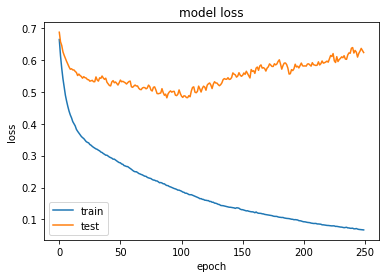

In [243]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

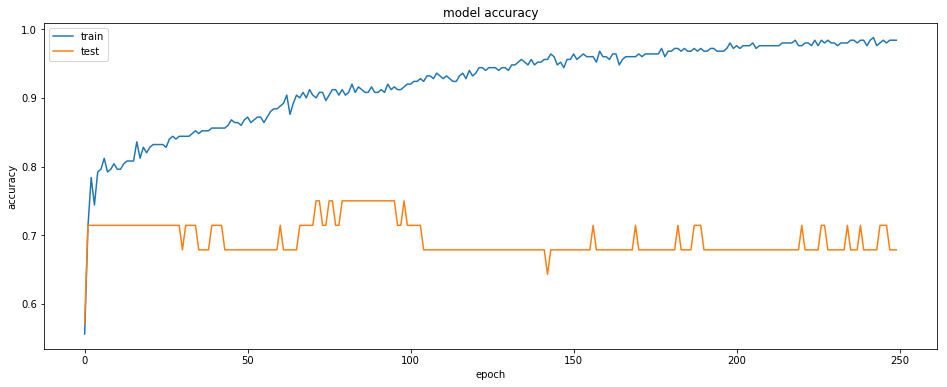

In [244]:
plt.figure(figsize=(16,6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

### модель посложнее-2, попробовали tanh вместо sigmoid, плохо

In [247]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW))
model.add(Activation('tanh'))
model.add(Dense(360))
model.add(Activation('tanh'))
model.add(Dense(2))
model.add(Activation('softmax'))

In [248]:
opt = Nadam(lr=0.0001)

In [249]:
model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [250]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 250, 
          batch_size = 15, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 250 samples, validate on 28 samples
Epoch 1/250
250/250 [==============================] - 1s 5ms/step - loss: 0.6494 - acc: 0.6040 - val_loss: 0.5133 - val_acc: 0.7857
Epoch 2/250
250/250 [==============================] - 0s 187us/step - loss: 0.4659 - acc: 0.7840 - val_loss: 0.4978 - val_acc: 0.7143
Epoch 3/250
250/250 [==============================] - 0s 187us/step - loss: 0.3974 - acc: 0.7960 - val_loss: 0.4891 - val_acc: 0.7500
Epoch 4/250
250/250 [==============================] - 0s 168us/step - loss: 0.3708 - acc: 0.7960 - val_loss: 0.4864 - val_acc: 0.7857
Epoch 5/250
250/250 [==============================] - 0s 172us/step - loss: 0.3444 - acc: 0.8200 - val_loss: 0.4942 - val_acc: 0.7500
Epoch 6/250
250/250 [==============================] - 0s 156us/step - loss: 0.3280 - acc: 0.8480 - val_loss: 0.5024 - val_acc: 0.7143
Epoch 7/250
250/250 [==============================] - 0s 164us/step - loss: 0.3130 - acc: 0.8440 - val_loss: 0.5044 - val_acc: 0.7143
Epoch 8/250


Epoch 61/250
250/250 [==============================] - 0s 152us/step - loss: 0.0898 - acc: 0.9880 - val_loss: 0.5532 - val_acc: 0.7143
Epoch 62/250
250/250 [==============================] - 0s 160us/step - loss: 0.0872 - acc: 0.9880 - val_loss: 0.5478 - val_acc: 0.7143
Epoch 63/250
250/250 [==============================] - 0s 168us/step - loss: 0.0864 - acc: 0.9920 - val_loss: 0.5508 - val_acc: 0.7143
Epoch 64/250
250/250 [==============================] - 0s 156us/step - loss: 0.0841 - acc: 0.9920 - val_loss: 0.5546 - val_acc: 0.7500
Epoch 65/250
250/250 [==============================] - 0s 164us/step - loss: 0.0820 - acc: 0.9840 - val_loss: 0.5632 - val_acc: 0.7143
Epoch 66/250
250/250 [==============================] - 0s 152us/step - loss: 0.0815 - acc: 0.9920 - val_loss: 0.5654 - val_acc: 0.7500
Epoch 67/250
250/250 [==============================] - 0s 168us/step - loss: 0.0817 - acc: 0.9880 - val_loss: 0.5540 - val_acc: 0.7500
Epoch 68/250
250/250 [==========================

250/250 [==============================] - 0s 164us/step - loss: 0.0262 - acc: 1.0000 - val_loss: 0.6393 - val_acc: 0.7500
Epoch 122/250
250/250 [==============================] - 0s 180us/step - loss: 0.0258 - acc: 1.0000 - val_loss: 0.6451 - val_acc: 0.7143
Epoch 123/250
250/250 [==============================] - 0s 187us/step - loss: 0.0251 - acc: 1.0000 - val_loss: 0.6383 - val_acc: 0.7500
Epoch 124/250
250/250 [==============================] - 0s 180us/step - loss: 0.0249 - acc: 1.0000 - val_loss: 0.6450 - val_acc: 0.7500
Epoch 125/250
250/250 [==============================] - 0s 168us/step - loss: 0.0241 - acc: 1.0000 - val_loss: 0.6577 - val_acc: 0.7143
Epoch 126/250
250/250 [==============================] - 0s 180us/step - loss: 0.0231 - acc: 1.0000 - val_loss: 0.6545 - val_acc: 0.7500
Epoch 127/250
250/250 [==============================] - 0s 168us/step - loss: 0.0233 - acc: 1.0000 - val_loss: 0.6501 - val_acc: 0.7500
Epoch 128/250
250/250 [==============================] 

Epoch 181/250
250/250 [==============================] - 0s 156us/step - loss: 0.0096 - acc: 1.0000 - val_loss: 0.8085 - val_acc: 0.7500
Epoch 182/250
250/250 [==============================] - 0s 160us/step - loss: 0.0094 - acc: 1.0000 - val_loss: 0.8042 - val_acc: 0.7500
Epoch 183/250
250/250 [==============================] - 0s 172us/step - loss: 0.0093 - acc: 1.0000 - val_loss: 0.8056 - val_acc: 0.7143
Epoch 184/250
250/250 [==============================] - 0s 164us/step - loss: 0.0091 - acc: 1.0000 - val_loss: 0.8052 - val_acc: 0.7143
Epoch 185/250
250/250 [==============================] - 0s 168us/step - loss: 0.0091 - acc: 1.0000 - val_loss: 0.8078 - val_acc: 0.7500
Epoch 186/250
250/250 [==============================] - 0s 168us/step - loss: 0.0091 - acc: 1.0000 - val_loss: 0.8099 - val_acc: 0.7500
Epoch 187/250
250/250 [==============================] - 0s 164us/step - loss: 0.0089 - acc: 1.0000 - val_loss: 0.8211 - val_acc: 0.7143
Epoch 188/250
250/250 [==================

Epoch 241/250
250/250 [==============================] - 0s 160us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.9145 - val_acc: 0.7500
Epoch 242/250
250/250 [==============================] - 0s 160us/step - loss: 0.0043 - acc: 1.0000 - val_loss: 0.9194 - val_acc: 0.7143
Epoch 243/250
250/250 [==============================] - 0s 160us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.9233 - val_acc: 0.7143
Epoch 244/250
250/250 [==============================] - 0s 160us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.9222 - val_acc: 0.7143
Epoch 245/250
250/250 [==============================] - 0s 160us/step - loss: 0.0052 - acc: 1.0000 - val_loss: 0.9257 - val_acc: 0.7143
Epoch 246/250
250/250 [==============================] - 0s 168us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.9328 - val_acc: 0.7500
Epoch 247/250
250/250 [==============================] - 0s 160us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.9388 - val_acc: 0.7500
Epoch 248/250
250/250 [==================

#### графики

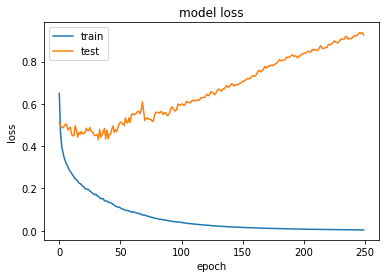

In [251]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

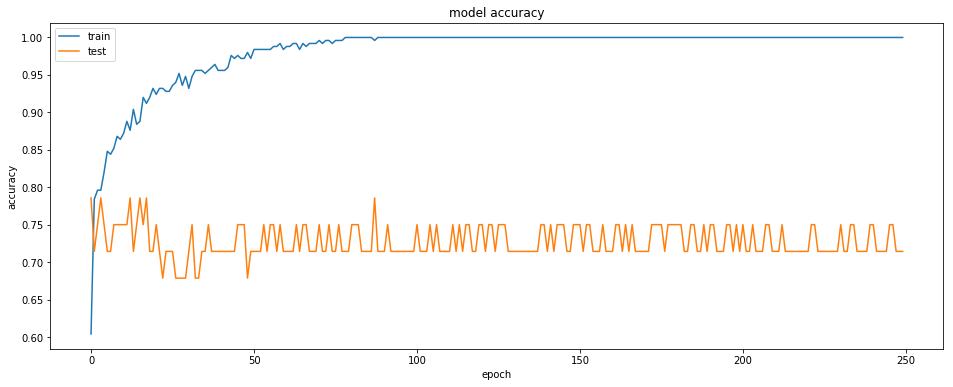

In [252]:
plt.figure(figsize=(16,6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

### модель посложнее-3,  добавили reduce lr

In [279]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW))
model.add(Activation('sigmoid'))
model.add(Dense(360))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))

In [280]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)

In [281]:
opt = Nadam(lr=0.0001)

In [282]:
model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [283]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 250, 
          batch_size = 15, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 250 samples, validate on 28 samples
Epoch 1/250
250/250 [==============================] - 1s 5ms/step - loss: 0.7188 - acc: 0.4960 - val_loss: 0.6513 - val_acc: 0.7857

Epoch 00001: val_loss improved from inf to 0.65131, saving model to test.hdf5
Epoch 2/250
250/250 [==============================] - 0s 168us/step - loss: 0.6233 - acc: 0.6960 - val_loss: 0.6579 - val_acc: 0.6429

Epoch 00002: val_loss did not improve from 0.65131
Epoch 3/250
250/250 [==============================] - 0s 196us/step - loss: 0.5808 - acc: 0.6960 - val_loss: 0.6395 - val_acc: 0.6786

Epoch 00003: val_loss improved from 0.65131 to 0.63951, saving model to test.hdf5
Epoch 4/250
250/250 [==============================] - 0s 191us/step - loss: 0.5484 - acc: 0.7600 - val_loss: 0.6250 - val_acc: 0.7500

Epoch 00004: val_loss improved from 0.63951 to 0.62495, saving model to test.hdf5
Epoch 5/250
250/250 [==============================] - 0s 180us/step - loss: 0.5219 - acc: 0.7960 - val_loss: 0.6171 - v


Epoch 00082: val_loss did not improve from 0.56251
Epoch 83/250
250/250 [==============================] - 0s 168us/step - loss: 0.2271 - acc: 0.9040 - val_loss: 0.6075 - val_acc: 0.7143

Epoch 00083: val_loss did not improve from 0.56251
Epoch 84/250
250/250 [==============================] - 0s 164us/step - loss: 0.2251 - acc: 0.9160 - val_loss: 0.6091 - val_acc: 0.7143

Epoch 00084: val_loss did not improve from 0.56251
Epoch 85/250
250/250 [==============================] - 0s 164us/step - loss: 0.2237 - acc: 0.9120 - val_loss: 0.6065 - val_acc: 0.7143

Epoch 00085: val_loss did not improve from 0.56251
Epoch 86/250
250/250 [==============================] - 0s 164us/step - loss: 0.2229 - acc: 0.9080 - val_loss: 0.6053 - val_acc: 0.7143

Epoch 00086: val_loss did not improve from 0.56251
Epoch 87/250
250/250 [==============================] - 0s 160us/step - loss: 0.2212 - acc: 0.9080 - val_loss: 0.6159 - val_acc: 0.7143

Epoch 00087: val_loss did not improve from 0.56251
Epoch 88

250/250 [==============================] - 0s 191us/step - loss: 0.1778 - acc: 0.9320 - val_loss: 0.6450 - val_acc: 0.7143

Epoch 00126: ReduceLROnPlateau reducing learning rate to 5.904900172026828e-05.

Epoch 00126: val_loss did not improve from 0.56251
Epoch 127/250
250/250 [==============================] - 0s 184us/step - loss: 0.1770 - acc: 0.9360 - val_loss: 0.6387 - val_acc: 0.7143

Epoch 00127: val_loss did not improve from 0.56251
Epoch 128/250
250/250 [==============================] - 0s 187us/step - loss: 0.1765 - acc: 0.9400 - val_loss: 0.6407 - val_acc: 0.7143

Epoch 00128: val_loss did not improve from 0.56251
Epoch 129/250
250/250 [==============================] - 0s 195us/step - loss: 0.1759 - acc: 0.9400 - val_loss: 0.6425 - val_acc: 0.7143

Epoch 00129: val_loss did not improve from 0.56251
Epoch 130/250
250/250 [==============================] - 0s 199us/step - loss: 0.1745 - acc: 0.9360 - val_loss: 0.6397 - val_acc: 0.7143

Epoch 00130: val_loss did not improve f


Epoch 00168: val_loss did not improve from 0.56251
Epoch 169/250
250/250 [==============================] - 0s 211us/step - loss: 0.1446 - acc: 0.9560 - val_loss: 0.6881 - val_acc: 0.6429

Epoch 00169: val_loss did not improve from 0.56251
Epoch 170/250
250/250 [==============================] - 0s 203us/step - loss: 0.1434 - acc: 0.9600 - val_loss: 0.6801 - val_acc: 0.6429

Epoch 00170: val_loss did not improve from 0.56251
Epoch 171/250
250/250 [==============================] - 0s 203us/step - loss: 0.1429 - acc: 0.9600 - val_loss: 0.6802 - val_acc: 0.6429

Epoch 00171: val_loss did not improve from 0.56251
Epoch 172/250
250/250 [==============================] - 0s 215us/step - loss: 0.1424 - acc: 0.9600 - val_loss: 0.6825 - val_acc: 0.6429

Epoch 00172: val_loss did not improve from 0.56251
Epoch 173/250
250/250 [==============================] - 0s 211us/step - loss: 0.1420 - acc: 0.9600 - val_loss: 0.6819 - val_acc: 0.6429

Epoch 00173: val_loss did not improve from 0.56251
Epo

#### графики

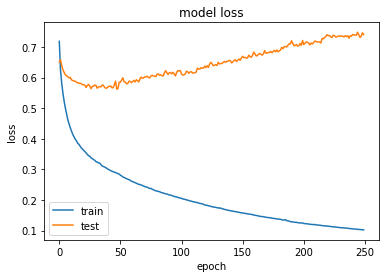

In [284]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

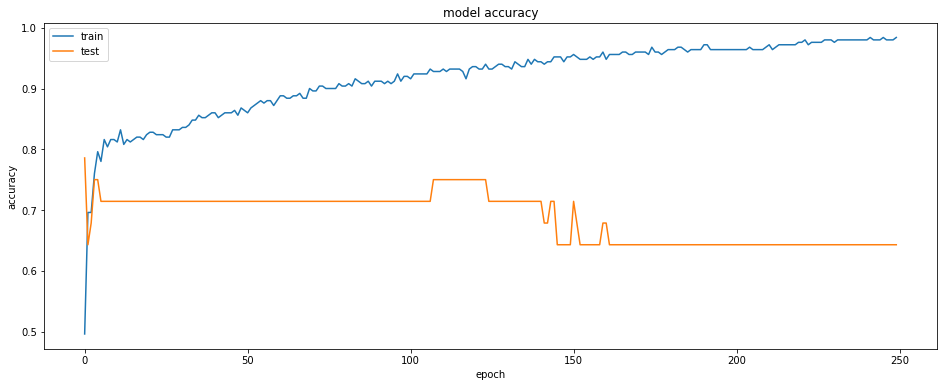

In [285]:
plt.figure(figsize=(16,6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

### модель посложнее 4 увеличили шаг, добавили регуляризацию, заменили сигмоид на релу

In [386]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW,
                activity_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))
model.add(Dense(360,
                activity_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

In [387]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=50, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)

In [388]:
opt = Nadam(lr=0.001)

In [389]:
model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [390]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 550, 
          batch_size = 15, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 250 samples, validate on 28 samples
Epoch 1/550
250/250 [==============================] - 2s 7ms/step - loss: 174670.2789 - acc: 0.6000 - val_loss: 55200.7882 - val_acc: 0.5357

Epoch 00001: val_loss improved from inf to 55200.78816, saving model to test.hdf5
Epoch 2/550
250/250 [==============================] - 0s 207us/step - loss: 79475.3370 - acc: 0.5600 - val_loss: 34019.5198 - val_acc: 0.5357

Epoch 00002: val_loss improved from 55200.78816 to 34019.51981, saving model to test.hdf5
Epoch 3/550
250/250 [==============================] - 0s 204us/step - loss: 45818.3389 - acc: 0.5760 - val_loss: 24043.3508 - val_acc: 0.5000

Epoch 00003: val_loss improved from 34019.51981 to 24043.35080, saving model to test.hdf5
Epoch 4/550
250/250 [==============================] - 0s 227us/step - loss: 30891.2125 - acc: 0.6640 - val_loss: 18408.5673 - val_acc: 0.4286

Epoch 00004: val_loss improved from 24043.35080 to 18408.56735, saving model to test.hdf5
Epoch 5/550
250/250 [=======


Epoch 00071: val_loss improved from 944.46502 to 921.81772, saving model to test.hdf5
Epoch 72/550
250/250 [==============================] - 0s 203us/step - loss: 1310.4344 - acc: 0.9360 - val_loss: 896.0377 - val_acc: 0.7500

Epoch 00072: val_loss improved from 921.81772 to 896.03769, saving model to test.hdf5
Epoch 73/550
250/250 [==============================] - 0s 204us/step - loss: 1277.4023 - acc: 0.9360 - val_loss: 877.5101 - val_acc: 0.7143

Epoch 00073: val_loss improved from 896.03769 to 877.51013, saving model to test.hdf5
Epoch 74/550
250/250 [==============================] - 0s 200us/step - loss: 1245.2305 - acc: 0.8880 - val_loss: 859.1318 - val_acc: 0.7143

Epoch 00074: val_loss improved from 877.51013 to 859.13184, saving model to test.hdf5
Epoch 75/550
250/250 [==============================] - 0s 192us/step - loss: 1220.3388 - acc: 0.9280 - val_loss: 830.7625 - val_acc: 0.7143

Epoch 00075: val_loss improved from 859.13184 to 830.76248, saving model to test.hdf5
E

250/250 [==============================] - 0s 207us/step - loss: 487.8870 - acc: 0.9520 - val_loss: 363.7907 - val_acc: 0.7857

Epoch 00108: val_loss improved from 373.02699 to 363.79071, saving model to test.hdf5
Epoch 109/550
250/250 [==============================] - 0s 215us/step - loss: 468.7193 - acc: 0.9600 - val_loss: 352.2182 - val_acc: 0.7500

Epoch 00109: val_loss improved from 363.79071 to 352.21825, saving model to test.hdf5
Epoch 110/550
250/250 [==============================] - 0s 211us/step - loss: 456.3550 - acc: 0.9520 - val_loss: 343.8018 - val_acc: 0.7857

Epoch 00110: val_loss improved from 352.21825 to 343.80177, saving model to test.hdf5
Epoch 111/550
250/250 [==============================] - 0s 207us/step - loss: 445.3446 - acc: 0.9360 - val_loss: 338.0871 - val_acc: 0.7500

Epoch 00111: val_loss improved from 343.80177 to 338.08710, saving model to test.hdf5
Epoch 112/550
250/250 [==============================] - 0s 199us/step - loss: 431.0617 - acc: 0.9400 

250/250 [==============================] - 0s 211us/step - loss: 165.9600 - acc: 0.9480 - val_loss: 138.6551 - val_acc: 0.7500

Epoch 00144: val_loss improved from 143.94609 to 138.65512, saving model to test.hdf5
Epoch 145/550
250/250 [==============================] - 0s 219us/step - loss: 159.8637 - acc: 0.9320 - val_loss: 135.9459 - val_acc: 0.8214

Epoch 00145: val_loss improved from 138.65512 to 135.94594, saving model to test.hdf5
Epoch 146/550
250/250 [==============================] - 0s 211us/step - loss: 155.8473 - acc: 0.9400 - val_loss: 131.8580 - val_acc: 0.8214

Epoch 00146: val_loss improved from 135.94594 to 131.85804, saving model to test.hdf5
Epoch 147/550
250/250 [==============================] - 0s 215us/step - loss: 151.2370 - acc: 0.9320 - val_loss: 128.2242 - val_acc: 0.7857

Epoch 00147: val_loss improved from 131.85804 to 128.22424, saving model to test.hdf5
Epoch 148/550
250/250 [==============================] - 0s 239us/step - loss: 148.1690 - acc: 0.9400 


Epoch 00216: val_loss improved from 19.94884 to 19.33146, saving model to test.hdf5
Epoch 217/550
250/250 [==============================] - 0s 227us/step - loss: 18.0930 - acc: 0.8880 - val_loss: 18.9179 - val_acc: 0.8214

Epoch 00217: val_loss improved from 19.33146 to 18.91789, saving model to test.hdf5
Epoch 218/550
250/250 [==============================] - 0s 227us/step - loss: 17.2116 - acc: 0.8640 - val_loss: 18.1619 - val_acc: 0.8929

Epoch 00218: val_loss improved from 18.91789 to 18.16188, saving model to test.hdf5
Epoch 219/550
250/250 [==============================] - 0s 219us/step - loss: 16.8688 - acc: 0.8680 - val_loss: 17.6059 - val_acc: 0.8571

Epoch 00219: val_loss improved from 18.16188 to 17.60585, saving model to test.hdf5
Epoch 220/550
250/250 [==============================] - 0s 219us/step - loss: 16.3376 - acc: 0.8800 - val_loss: 17.5774 - val_acc: 0.8571

Epoch 00220: val_loss improved from 17.60585 to 17.57744, saving model to test.hdf5
Epoch 221/550
250/2

250/250 [==============================] - 0s 223us/step - loss: 5.8247 - acc: 0.8520 - val_loss: 6.4634 - val_acc: 0.8929

Epoch 00254: val_loss improved from 6.96784 to 6.46344, saving model to test.hdf5
Epoch 255/550
250/250 [==============================] - 0s 235us/step - loss: 5.6067 - acc: 0.8560 - val_loss: 6.3781 - val_acc: 0.8929

Epoch 00255: val_loss improved from 6.46344 to 6.37813, saving model to test.hdf5
Epoch 256/550
250/250 [==============================] - 0s 223us/step - loss: 5.4396 - acc: 0.8560 - val_loss: 6.2885 - val_acc: 0.8571

Epoch 00256: val_loss improved from 6.37813 to 6.28846, saving model to test.hdf5
Epoch 257/550
250/250 [==============================] - 0s 223us/step - loss: 5.4222 - acc: 0.8360 - val_loss: 5.9809 - val_acc: 0.8929

Epoch 00257: val_loss improved from 6.28846 to 5.98088, saving model to test.hdf5
Epoch 258/550
250/250 [==============================] - 0s 215us/step - loss: 5.1081 - acc: 0.8600 - val_loss: 6.0824 - val_acc: 0.82

250/250 [==============================] - 0s 259us/step - loss: 2.7703 - acc: 0.8480 - val_loss: 2.8360 - val_acc: 0.8929

Epoch 00293: val_loss did not improve from 2.41726
Epoch 294/550
250/250 [==============================] - 0s 263us/step - loss: 2.3989 - acc: 0.8360 - val_loss: 2.8391 - val_acc: 0.8214

Epoch 00294: val_loss did not improve from 2.41726
Epoch 295/550
250/250 [==============================] - 0s 263us/step - loss: 2.5822 - acc: 0.8520 - val_loss: 2.2062 - val_acc: 0.8929

Epoch 00295: val_loss improved from 2.41726 to 2.20620, saving model to test.hdf5
Epoch 296/550
250/250 [==============================] - 0s 263us/step - loss: 2.4638 - acc: 0.8360 - val_loss: 2.3634 - val_acc: 0.8214

Epoch 00296: val_loss did not improve from 2.20620
Epoch 297/550
250/250 [==============================] - 0s 267us/step - loss: 3.2041 - acc: 0.8280 - val_loss: 2.2031 - val_acc: 0.8571

Epoch 00297: val_loss improved from 2.20620 to 2.20306, saving model to test.hdf5
Epoch 2


Epoch 00376: val_loss did not improve from 0.71877
Epoch 377/550
250/250 [==============================] - 0s 219us/step - loss: 3.0977 - acc: 0.8120 - val_loss: 1.7513 - val_acc: 0.8214

Epoch 00377: val_loss did not improve from 0.71877
Epoch 378/550
250/250 [==============================] - 0s 219us/step - loss: 4.5244 - acc: 0.7760 - val_loss: 1.4615 - val_acc: 0.7500

Epoch 00378: val_loss did not improve from 0.71877
Epoch 379/550
250/250 [==============================] - 0s 215us/step - loss: 2.1216 - acc: 0.8000 - val_loss: 1.7588 - val_acc: 0.8929

Epoch 00379: ReduceLROnPlateau reducing learning rate to 0.0005904900433961303.

Epoch 00379: val_loss did not improve from 0.71877
Epoch 380/550
250/250 [==============================] - 0s 223us/step - loss: 1.5132 - acc: 0.7880 - val_loss: 1.8818 - val_acc: 0.7500

Epoch 00380: val_loss did not improve from 0.71877
Epoch 381/550
250/250 [==============================] - 0s 223us/step - loss: 1.7283 - acc: 0.8120 - val_loss:

250/250 [==============================] - 0s 227us/step - loss: 1.9397 - acc: 0.7640 - val_loss: 0.8176 - val_acc: 0.8571

Epoch 00419: val_loss did not improve from 0.60947
Epoch 420/550
250/250 [==============================] - 0s 219us/step - loss: 1.3745 - acc: 0.8120 - val_loss: 0.7991 - val_acc: 0.7857

Epoch 00420: val_loss did not improve from 0.60947
Epoch 421/550
250/250 [==============================] - 0s 259us/step - loss: 3.1223 - acc: 0.7920 - val_loss: 1.2316 - val_acc: 0.7143

Epoch 00421: val_loss did not improve from 0.60947
Epoch 422/550
250/250 [==============================] - 0s 295us/step - loss: 2.1323 - acc: 0.7600 - val_loss: 4.7852 - val_acc: 0.7857

Epoch 00422: val_loss did not improve from 0.60947
Epoch 423/550
250/250 [==============================] - 0s 287us/step - loss: 3.6966 - acc: 0.7920 - val_loss: 0.8580 - val_acc: 0.8571

Epoch 00423: val_loss did not improve from 0.60947
Epoch 424/550
250/250 [==============================] - 0s 259us/ste

250/250 [==============================] - 0s 211us/step - loss: 5.2770 - acc: 0.7720 - val_loss: 0.8790 - val_acc: 0.8571

Epoch 00462: val_loss did not improve from 0.57752
Epoch 463/550
250/250 [==============================] - 0s 219us/step - loss: 1.8025 - acc: 0.7720 - val_loss: 0.9110 - val_acc: 0.8929

Epoch 00463: val_loss did not improve from 0.57752
Epoch 464/550
250/250 [==============================] - 0s 223us/step - loss: 2.0408 - acc: 0.7640 - val_loss: 0.6939 - val_acc: 0.8214

Epoch 00464: val_loss did not improve from 0.57752
Epoch 465/550
250/250 [==============================] - 0s 231us/step - loss: 2.3732 - acc: 0.8040 - val_loss: 0.9013 - val_acc: 0.8571

Epoch 00465: val_loss did not improve from 0.57752
Epoch 466/550
250/250 [==============================] - 0s 231us/step - loss: 1.9752 - acc: 0.7800 - val_loss: 0.9379 - val_acc: 0.8929

Epoch 00466: val_loss did not improve from 0.57752
Epoch 467/550
250/250 [==============================] - 0s 215us/ste

250/250 [==============================] - 0s 227us/step - loss: 1.3124 - acc: 0.7880 - val_loss: 0.8431 - val_acc: 0.8214

Epoch 00505: val_loss did not improve from 0.57752
Epoch 506/550
250/250 [==============================] - 0s 223us/step - loss: 2.3166 - acc: 0.7480 - val_loss: 1.0048 - val_acc: 0.8214

Epoch 00506: val_loss did not improve from 0.57752
Epoch 507/550
250/250 [==============================] - 0s 231us/step - loss: 1.9261 - acc: 0.8120 - val_loss: 0.8257 - val_acc: 0.8571

Epoch 00507: val_loss did not improve from 0.57752
Epoch 508/550
250/250 [==============================] - 0s 227us/step - loss: 1.3596 - acc: 0.7880 - val_loss: 1.2960 - val_acc: 0.8571

Epoch 00508: val_loss did not improve from 0.57752
Epoch 509/550
250/250 [==============================] - 0s 231us/step - loss: 1.5218 - acc: 0.8080 - val_loss: 0.7545 - val_acc: 0.8929

Epoch 00509: val_loss did not improve from 0.57752
Epoch 510/550
250/250 [==============================] - 0s 235us/ste

250/250 [==============================] - 0s 255us/step - loss: 1.4055 - acc: 0.7840 - val_loss: 0.8115 - val_acc: 0.8571

Epoch 00548: val_loss did not improve from 0.57752
Epoch 549/550
250/250 [==============================] - 0s 259us/step - loss: 1.2641 - acc: 0.7960 - val_loss: 0.6914 - val_acc: 0.8214

Epoch 00549: val_loss did not improve from 0.57752
Epoch 550/550
250/250 [==============================] - 0s 259us/step - loss: 1.2897 - acc: 0.8080 - val_loss: 1.0560 - val_acc: 0.8214

Epoch 00550: val_loss did not improve from 0.57752


#### графики

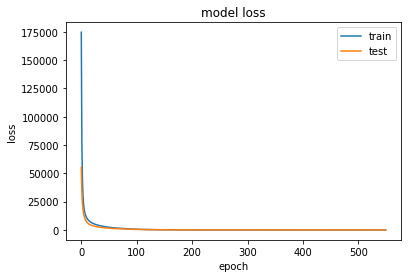

In [391]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

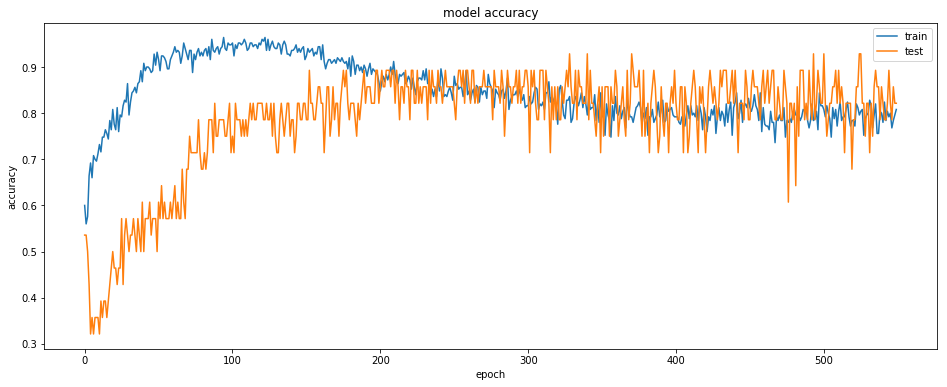

In [392]:
plt.figure(figsize=(16,6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

### модель посложнее 5 добавили batch normalization

In [27]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW,
                activity_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(360,
                activity_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

In [28]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=50, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)

In [29]:
opt = Nadam(lr=0.001)

In [30]:
model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 550, 
          batch_size = 15, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 250 samples, validate on 28 samples
Epoch 1/550
250/250 [==============================] - 1s 3ms/step - loss: 156246.5394 - acc: 0.7920 - val_loss: 55269.3090 - val_acc: 0.7143

Epoch 00001: val_loss improved from inf to 55269.30901, saving model to test.hdf5
Epoch 2/550
250/250 [==============================] - 0s 143us/step - loss: 80826.9934 - acc: 0.8080 - val_loss: 35115.2372 - val_acc: 0.7857

Epoch 00002: val_loss improved from 55269.30901 to 35115.23717, saving model to test.hdf5
Epoch 3/550
250/250 [==============================] - 0s 145us/step - loss: 44922.0451 - acc: 0.8320 - val_loss: 23809.9027 - val_acc: 0.7143

Epoch 00003: val_loss improved from 35115.23717 to 23809.90273, saving model to test.hdf5
Epoch 4/550
250/250 [==============================] - 0s 137us/step - loss: 28654.7505 - acc: 0.8440 - val_loss: 17392.1666 - val_acc: 0.7500

Epoch 00004: val_loss improved from 23809.90273 to 17392.16657, saving model to test.hdf5
Epoch 5/550
250/250 [=======

250/250 [==============================] - 0s 155us/step - loss: 1123.1473 - acc: 0.9320 - val_loss: 736.3109 - val_acc: 0.8214

Epoch 00072: val_loss improved from 759.11237 to 736.31086, saving model to test.hdf5
Epoch 73/550
250/250 [==============================] - 0s 168us/step - loss: 1091.1041 - acc: 0.9160 - val_loss: 720.4715 - val_acc: 0.7857

Epoch 00073: val_loss improved from 736.31086 to 720.47147, saving model to test.hdf5
Epoch 74/550
250/250 [==============================] - 0s 149us/step - loss: 1054.0055 - acc: 0.9240 - val_loss: 699.1894 - val_acc: 0.7143

Epoch 00074: val_loss improved from 720.47147 to 699.18943, saving model to test.hdf5
Epoch 75/550
250/250 [==============================] - 0s 149us/step - loss: 1032.9861 - acc: 0.9240 - val_loss: 683.9057 - val_acc: 0.8571

Epoch 00075: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00075: val_loss improved from 699.18943 to 683.90570, saving model to test.hdf5
Epoch 76/550
250/250

Epoch 108/550
250/250 [==============================] - 0s 153us/step - loss: 429.0010 - acc: 0.9600 - val_loss: 314.7873 - val_acc: 0.7500

Epoch 00108: val_loss improved from 324.90563 to 314.78729, saving model to test.hdf5
Epoch 109/550
250/250 [==============================] - 0s 151us/step - loss: 415.5760 - acc: 0.9320 - val_loss: 305.6519 - val_acc: 0.7143

Epoch 00109: val_loss improved from 314.78729 to 305.65187, saving model to test.hdf5
Epoch 110/550
250/250 [==============================] - 0s 152us/step - loss: 404.0382 - acc: 0.9480 - val_loss: 297.3708 - val_acc: 0.7500

Epoch 00110: val_loss improved from 305.65187 to 297.37084, saving model to test.hdf5
Epoch 111/550
250/250 [==============================] - 0s 159us/step - loss: 395.9379 - acc: 0.9320 - val_loss: 290.7747 - val_acc: 0.6429

Epoch 00111: val_loss improved from 297.37084 to 290.77472, saving model to test.hdf5
Epoch 112/550
250/250 [==============================] - 0s 153us/step - loss: 382.1654 


Epoch 00143: val_loss improved from 137.48526 to 134.38349, saving model to test.hdf5
Epoch 144/550
250/250 [==============================] - 0s 149us/step - loss: 160.4968 - acc: 0.9200 - val_loss: 130.2756 - val_acc: 0.7143

Epoch 00144: val_loss improved from 134.38349 to 130.27559, saving model to test.hdf5
Epoch 145/550
250/250 [==============================] - 0s 158us/step - loss: 154.1497 - acc: 0.9320 - val_loss: 127.5239 - val_acc: 0.7500

Epoch 00145: val_loss improved from 130.27559 to 127.52388, saving model to test.hdf5
Epoch 146/550
250/250 [==============================] - 0s 151us/step - loss: 152.7457 - acc: 0.9600 - val_loss: 124.1102 - val_acc: 0.7500

Epoch 00146: val_loss improved from 127.52388 to 124.11022, saving model to test.hdf5
Epoch 147/550
250/250 [==============================] - 0s 157us/step - loss: 146.6005 - acc: 0.9160 - val_loss: 122.9497 - val_acc: 0.7143

Epoch 00147: val_loss improved from 124.11022 to 122.94969, saving model to test.hdf5
E


Epoch 00179: val_loss improved from 55.36961 to 54.66669, saving model to test.hdf5
Epoch 180/550
250/250 [==============================] - 0s 153us/step - loss: 57.0914 - acc: 0.9040 - val_loss: 53.5970 - val_acc: 0.7143

Epoch 00180: val_loss improved from 54.66669 to 53.59695, saving model to test.hdf5
Epoch 181/550
250/250 [==============================] - 0s 159us/step - loss: 56.0991 - acc: 0.9440 - val_loss: 52.5144 - val_acc: 0.7857

Epoch 00181: val_loss improved from 53.59695 to 52.51443, saving model to test.hdf5
Epoch 182/550
250/250 [==============================] - 0s 155us/step - loss: 55.3901 - acc: 0.9040 - val_loss: 50.1425 - val_acc: 0.7500

Epoch 00182: val_loss improved from 52.51443 to 50.14249, saving model to test.hdf5
Epoch 183/550
250/250 [==============================] - 0s 159us/step - loss: 53.1522 - acc: 0.9160 - val_loss: 49.2649 - val_acc: 0.8214

Epoch 00183: val_loss improved from 50.14249 to 49.26485, saving model to test.hdf5
Epoch 184/550
250/2


Epoch 00216: val_loss improved from 21.95935 to 21.23608, saving model to test.hdf5
Epoch 217/550
250/250 [==============================] - 0s 186us/step - loss: 20.4655 - acc: 0.8720 - val_loss: 21.1380 - val_acc: 0.7500

Epoch 00217: val_loss improved from 21.23608 to 21.13796, saving model to test.hdf5
Epoch 218/550
250/250 [==============================] - 0s 188us/step - loss: 20.3387 - acc: 0.8840 - val_loss: 20.0492 - val_acc: 0.8214

Epoch 00218: val_loss improved from 21.13796 to 20.04924, saving model to test.hdf5
Epoch 219/550
250/250 [==============================] - 0s 190us/step - loss: 19.3954 - acc: 0.8880 - val_loss: 20.0898 - val_acc: 0.7500

Epoch 00219: val_loss did not improve from 20.04924
Epoch 220/550
250/250 [==============================] - 0s 185us/step - loss: 18.6509 - acc: 0.9160 - val_loss: 19.3309 - val_acc: 0.7500

Epoch 00220: val_loss improved from 20.04924 to 19.33086, saving model to test.hdf5
Epoch 221/550
250/250 [============================

250/250 [==============================] - 0s 185us/step - loss: 7.3500 - acc: 0.8800 - val_loss: 7.9553 - val_acc: 0.8929

Epoch 00254: val_loss improved from 8.43874 to 7.95531, saving model to test.hdf5
Epoch 255/550
250/250 [==============================] - 0s 198us/step - loss: 7.4154 - acc: 0.8480 - val_loss: 8.8886 - val_acc: 0.7500

Epoch 00255: val_loss did not improve from 7.95531
Epoch 256/550
250/250 [==============================] - 0s 186us/step - loss: 7.5335 - acc: 0.8720 - val_loss: 7.7220 - val_acc: 0.8214

Epoch 00256: val_loss improved from 7.95531 to 7.72204, saving model to test.hdf5
Epoch 257/550
250/250 [==============================] - 0s 190us/step - loss: 6.9677 - acc: 0.8760 - val_loss: 7.4700 - val_acc: 0.8571

Epoch 00257: val_loss improved from 7.72204 to 7.46997, saving model to test.hdf5
Epoch 258/550
250/250 [==============================] - 0s 186us/step - loss: 6.7758 - acc: 0.8760 - val_loss: 7.3361 - val_acc: 0.8571

Epoch 00258: val_loss impro

250/250 [==============================] - 0s 202us/step - loss: 1.9450 - acc: 0.8440 - val_loss: 4.5128 - val_acc: 0.7143

Epoch 00336: val_loss did not improve from 1.72896
Epoch 337/550
250/250 [==============================] - 0s 215us/step - loss: 2.8192 - acc: 0.8400 - val_loss: 3.1609 - val_acc: 0.7500

Epoch 00337: val_loss did not improve from 1.72896
Epoch 338/550
250/250 [==============================] - 0s 204us/step - loss: 2.5403 - acc: 0.8480 - val_loss: 1.7796 - val_acc: 0.7143

Epoch 00338: val_loss did not improve from 1.72896
Epoch 339/550
250/250 [==============================] - 0s 210us/step - loss: 1.8543 - acc: 0.8800 - val_loss: 2.2865 - val_acc: 0.8214

Epoch 00339: val_loss did not improve from 1.72896
Epoch 340/550
250/250 [==============================] - 0s 220us/step - loss: 2.6253 - acc: 0.8240 - val_loss: 1.7551 - val_acc: 0.8214

Epoch 00340: val_loss did not improve from 1.72896
Epoch 341/550
250/250 [==============================] - 0s 220us/ste

250/250 [==============================] - 0s 194us/step - loss: 2.1423 - acc: 0.8120 - val_loss: 1.5427 - val_acc: 0.8929

Epoch 00420: val_loss did not improve from 0.96772
Epoch 421/550
250/250 [==============================] - 0s 192us/step - loss: 2.0590 - acc: 0.8240 - val_loss: 1.4897 - val_acc: 0.8929

Epoch 00421: val_loss did not improve from 0.96772
Epoch 422/550
250/250 [==============================] - 0s 192us/step - loss: 2.1079 - acc: 0.8040 - val_loss: 3.8548 - val_acc: 0.7500

Epoch 00422: val_loss did not improve from 0.96772
Epoch 423/550
250/250 [==============================] - 0s 186us/step - loss: 2.4873 - acc: 0.8120 - val_loss: 1.2951 - val_acc: 0.7857

Epoch 00423: val_loss did not improve from 0.96772
Epoch 424/550
250/250 [==============================] - 0s 200us/step - loss: 1.7416 - acc: 0.8200 - val_loss: 1.2112 - val_acc: 0.8214

Epoch 00424: val_loss did not improve from 0.96772
Epoch 425/550
250/250 [==============================] - 0s 197us/ste

250/250 [==============================] - 0s 205us/step - loss: 1.8341 - acc: 0.8120 - val_loss: 1.2441 - val_acc: 0.8571

Epoch 00463: val_loss did not improve from 0.96772
Epoch 464/550
250/250 [==============================] - 0s 196us/step - loss: 1.8001 - acc: 0.8480 - val_loss: 1.1787 - val_acc: 0.8929

Epoch 00464: val_loss did not improve from 0.96772
Epoch 465/550
250/250 [==============================] - 0s 192us/step - loss: 1.6199 - acc: 0.8200 - val_loss: 1.4339 - val_acc: 0.8571

Epoch 00465: val_loss did not improve from 0.96772
Epoch 466/550
250/250 [==============================] - 0s 196us/step - loss: 2.0364 - acc: 0.8320 - val_loss: 0.9515 - val_acc: 0.7857

Epoch 00466: val_loss improved from 0.96772 to 0.95153, saving model to test.hdf5
Epoch 467/550
250/250 [==============================] - 0s 196us/step - loss: 1.6347 - acc: 0.8600 - val_loss: 1.8085 - val_acc: 0.8571

Epoch 00467: val_loss did not improve from 0.95153
Epoch 468/550
250/250 [===============

250/250 [==============================] - 0s 218us/step - loss: 1.8904 - acc: 0.8320 - val_loss: 1.2776 - val_acc: 0.9643

Epoch 00549: val_loss did not improve from 0.88121
Epoch 550/550
250/250 [==============================] - 0s 194us/step - loss: 1.8035 - acc: 0.8520 - val_loss: 0.9258 - val_acc: 0.8214

Epoch 00550: val_loss did not improve from 0.88121


#### графики

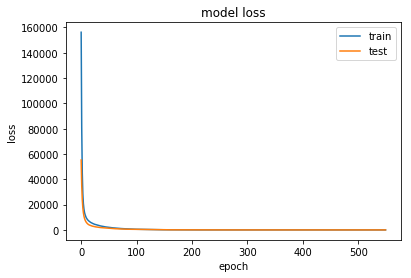

In [32]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

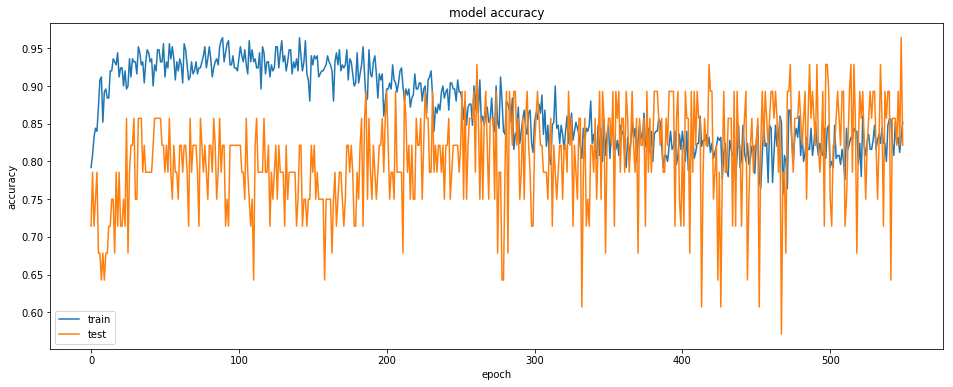

In [33]:
plt.figure(figsize=(16,6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

### модель посложнее 6, заменили relu на leaky relu, увеличили вес регуляризаций

In [55]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW,
                activity_regularizer=regularizers.l2(0.05)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.65))
model.add(Dense(360,
                activity_regularizer=regularizers.l2(0.05)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(2))
model.add(Activation('softmax'))

In [56]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)

In [57]:
opt = Nadam(lr=0.001)

In [58]:
model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [59]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 550, 
          batch_size = 15, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 250 samples, validate on 28 samples
Epoch 1/550
250/250 [==============================] - 1s 4ms/step - loss: 8458523.4300 - acc: 0.5520 - val_loss: 2879389.9821 - val_acc: 0.7500

Epoch 00001: val_loss improved from inf to 2879389.98214, saving model to test.hdf5
Epoch 2/550
250/250 [==============================] - 0s 164us/step - loss: 4414737.5950 - acc: 0.6000 - val_loss: 1831249.1473 - val_acc: 0.8214

Epoch 00002: val_loss improved from 2879389.98214 to 1831249.14732, saving model to test.hdf5
Epoch 3/550
250/250 [==============================] - 0s 163us/step - loss: 2415060.6900 - acc: 0.5560 - val_loss: 1259849.4163 - val_acc: 0.7143

Epoch 00003: val_loss improved from 1831249.14732 to 1259849.41629, saving model to test.hdf5
Epoch 4/550
250/250 [==============================] - 0s 155us/step - loss: 1489410.6875 - acc: 0.6120 - val_loss: 948121.4051 - val_acc: 0.7143

Epoch 00004: val_loss improved from 1259849.41629 to 948121.40513, saving model to test.hdf5
E

Epoch 35/550
250/250 [==============================] - 0s 151us/step - loss: 167837.8311 - acc: 0.7040 - val_loss: 107487.8992 - val_acc: 0.7500

Epoch 00035: val_loss improved from 110109.48493 to 107487.89920, saving model to test.hdf5
Epoch 36/550
250/250 [==============================] - 0s 162us/step - loss: 163640.5880 - acc: 0.7320 - val_loss: 104717.5228 - val_acc: 0.7500

Epoch 00036: val_loss improved from 107487.89920 to 104717.52281, saving model to test.hdf5
Epoch 37/550
250/250 [==============================] - 0s 155us/step - loss: 158494.1336 - acc: 0.6960 - val_loss: 101900.1857 - val_acc: 0.7500

Epoch 00037: val_loss improved from 104717.52281 to 101900.18569, saving model to test.hdf5
Epoch 38/550
250/250 [==============================] - 0s 155us/step - loss: 153608.2752 - acc: 0.7480 - val_loss: 99311.7027 - val_acc: 0.7143

Epoch 00038: val_loss improved from 101900.18569 to 99311.70271, saving model to test.hdf5
Epoch 39/550
250/250 [========================


Epoch 00103: val_loss improved from 23853.51779 to 23185.46662, saving model to test.hdf5
Epoch 104/550
250/250 [==============================] - 0s 148us/step - loss: 31172.7313 - acc: 0.7080 - val_loss: 22726.8128 - val_acc: 0.7500

Epoch 00104: val_loss improved from 23185.46662 to 22726.81281, saving model to test.hdf5
Epoch 105/550
250/250 [==============================] - 0s 159us/step - loss: 30320.1283 - acc: 0.7120 - val_loss: 22295.9078 - val_acc: 0.8571

Epoch 00105: val_loss improved from 22726.81281 to 22295.90780, saving model to test.hdf5
Epoch 106/550
250/250 [==============================] - 0s 163us/step - loss: 29805.6294 - acc: 0.6960 - val_loss: 21859.2520 - val_acc: 0.8571

Epoch 00106: val_loss improved from 22295.90780 to 21859.25199, saving model to test.hdf5
Epoch 107/550
250/250 [==============================] - 0s 155us/step - loss: 29060.8235 - acc: 0.7320 - val_loss: 21397.5945 - val_acc: 0.8571

Epoch 00107: val_loss improved from 21859.25199 to 2139


Epoch 00172: val_loss improved from 5501.40161 to 5413.67290, saving model to test.hdf5
Epoch 173/550
250/250 [==============================] - 0s 194us/step - loss: 6128.1323 - acc: 0.6640 - val_loss: 5309.0898 - val_acc: 0.8929

Epoch 00173: val_loss improved from 5413.67290 to 5309.08976, saving model to test.hdf5
Epoch 174/550
250/250 [==============================] - 0s 194us/step - loss: 6042.8232 - acc: 0.6720 - val_loss: 5166.4763 - val_acc: 0.8929

Epoch 00174: val_loss improved from 5309.08976 to 5166.47635, saving model to test.hdf5
Epoch 175/550
250/250 [==============================] - 0s 187us/step - loss: 5896.1146 - acc: 0.7000 - val_loss: 5060.4559 - val_acc: 0.9286

Epoch 00175: val_loss improved from 5166.47635 to 5060.45589, saving model to test.hdf5
Epoch 176/550
250/250 [==============================] - 0s 192us/step - loss: 5795.7000 - acc: 0.6880 - val_loss: 4959.7387 - val_acc: 0.8929

Epoch 00176: val_loss improved from 5060.45589 to 4959.73873, saving mo


Epoch 00207: val_loss improved from 2709.64902 to 2634.90097, saving model to test.hdf5
Epoch 208/550
250/250 [==============================] - 0s 185us/step - loss: 2726.7185 - acc: 0.7280 - val_loss: 2592.3558 - val_acc: 0.8929

Epoch 00208: val_loss improved from 2634.90097 to 2592.35582, saving model to test.hdf5
Epoch 209/550
250/250 [==============================] - 0s 194us/step - loss: 2690.1520 - acc: 0.7440 - val_loss: 2533.9774 - val_acc: 0.8929

Epoch 00209: val_loss improved from 2592.35582 to 2533.97745, saving model to test.hdf5
Epoch 210/550
250/250 [==============================] - 0s 189us/step - loss: 2624.6671 - acc: 0.6840 - val_loss: 2494.6741 - val_acc: 0.8571

Epoch 00210: val_loss improved from 2533.97745 to 2494.67406, saving model to test.hdf5
Epoch 211/550
250/250 [==============================] - 0s 188us/step - loss: 2570.2183 - acc: 0.7120 - val_loss: 2435.1648 - val_acc: 0.9286

Epoch 00211: val_loss improved from 2494.67406 to 2435.16478, saving mo


Epoch 00242: val_loss improved from 1323.68289 to 1294.02261, saving model to test.hdf5
Epoch 243/550
250/250 [==============================] - 0s 185us/step - loss: 1209.7507 - acc: 0.7480 - val_loss: 1275.8521 - val_acc: 0.8929

Epoch 00243: val_loss improved from 1294.02261 to 1275.85207, saving model to test.hdf5
Epoch 244/550
250/250 [==============================] - 0s 188us/step - loss: 1198.8213 - acc: 0.7440 - val_loss: 1243.5170 - val_acc: 0.8214

Epoch 00244: val_loss improved from 1275.85207 to 1243.51696, saving model to test.hdf5
Epoch 245/550
250/250 [==============================] - 0s 183us/step - loss: 1168.9481 - acc: 0.7720 - val_loss: 1217.0204 - val_acc: 0.8571

Epoch 00245: ReduceLROnPlateau reducing learning rate to 0.0004304672533180565.

Epoch 00245: val_loss improved from 1243.51696 to 1217.02038, saving model to test.hdf5
Epoch 246/550
250/250 [==============================] - 0s 200us/step - loss: 1146.5785 - acc: 0.6960 - val_loss: 1195.1792 - val_acc

250/250 [==============================] - 0s 181us/step - loss: 549.1996 - acc: 0.7560 - val_loss: 626.6968 - val_acc: 0.8929

Epoch 00278: val_loss improved from 642.63791 to 626.69677, saving model to test.hdf5
Epoch 279/550
250/250 [==============================] - 0s 187us/step - loss: 546.2747 - acc: 0.7360 - val_loss: 620.6289 - val_acc: 0.9286

Epoch 00279: val_loss improved from 626.69677 to 620.62894, saving model to test.hdf5
Epoch 280/550
250/250 [==============================] - 0s 192us/step - loss: 531.4758 - acc: 0.7440 - val_loss: 599.3723 - val_acc: 0.8214

Epoch 00280: val_loss improved from 620.62894 to 599.37227, saving model to test.hdf5
Epoch 281/550
250/250 [==============================] - 0s 190us/step - loss: 523.6794 - acc: 0.7520 - val_loss: 591.3804 - val_acc: 0.8929

Epoch 00281: val_loss improved from 599.37227 to 591.38043, saving model to test.hdf5
Epoch 282/550
250/250 [==============================] - 0s 192us/step - loss: 508.4045 - acc: 0.7800 

250/250 [==============================] - 0s 208us/step - loss: 245.5344 - acc: 0.7760 - val_loss: 299.9450 - val_acc: 0.8929

Epoch 00314: val_loss improved from 312.22827 to 299.94505, saving model to test.hdf5
Epoch 315/550
250/250 [==============================] - 0s 206us/step - loss: 238.1576 - acc: 0.8120 - val_loss: 291.4627 - val_acc: 0.8929

Epoch 00315: val_loss improved from 299.94505 to 291.46269, saving model to test.hdf5
Epoch 316/550
250/250 [==============================] - 0s 220us/step - loss: 235.2275 - acc: 0.7960 - val_loss: 287.7122 - val_acc: 0.9286

Epoch 00316: val_loss improved from 291.46269 to 287.71217, saving model to test.hdf5
Epoch 317/550
250/250 [==============================] - 0s 218us/step - loss: 222.8020 - acc: 0.7920 - val_loss: 284.2660 - val_acc: 0.8929

Epoch 00317: val_loss improved from 287.71217 to 284.26600, saving model to test.hdf5
Epoch 318/550
250/250 [==============================] - 0s 206us/step - loss: 219.9604 - acc: 0.7800 

250/250 [==============================] - 0s 204us/step - loss: 45.3586 - acc: 0.7800 - val_loss: 63.5758 - val_acc: 0.8929

Epoch 00385: val_loss improved from 65.37297 to 63.57576, saving model to test.hdf5
Epoch 386/550
250/250 [==============================] - 0s 186us/step - loss: 43.8270 - acc: 0.7680 - val_loss: 63.3130 - val_acc: 0.8571

Epoch 00386: val_loss improved from 63.57576 to 63.31295, saving model to test.hdf5
Epoch 387/550
250/250 [==============================] - 0s 198us/step - loss: 43.5872 - acc: 0.7720 - val_loss: 61.7697 - val_acc: 0.8929

Epoch 00387: val_loss improved from 63.31295 to 61.76968, saving model to test.hdf5
Epoch 388/550
250/250 [==============================] - 0s 196us/step - loss: 42.1501 - acc: 0.7840 - val_loss: 59.0884 - val_acc: 0.8571

Epoch 00388: val_loss improved from 61.76968 to 59.08836, saving model to test.hdf5
Epoch 389/550
250/250 [==============================] - 0s 188us/step - loss: 41.4206 - acc: 0.7920 - val_loss: 58.41

250/250 [==============================] - 0s 192us/step - loss: 7.5539 - acc: 0.8000 - val_loss: 11.1125 - val_acc: 0.8929

Epoch 00457: val_loss improved from 11.37774 to 11.11247, saving model to test.hdf5
Epoch 458/550
250/250 [==============================] - 0s 198us/step - loss: 7.2907 - acc: 0.8160 - val_loss: 11.4807 - val_acc: 0.6071

Epoch 00458: val_loss did not improve from 11.11247
Epoch 459/550
250/250 [==============================] - 0s 190us/step - loss: 7.2351 - acc: 0.7880 - val_loss: 11.3221 - val_acc: 0.6071

Epoch 00459: val_loss did not improve from 11.11247
Epoch 460/550
250/250 [==============================] - 0s 183us/step - loss: 7.2504 - acc: 0.7760 - val_loss: 10.5121 - val_acc: 0.8571

Epoch 00460: val_loss improved from 11.11247 to 10.51215, saving model to test.hdf5
Epoch 461/550
250/250 [==============================] - 0s 194us/step - loss: 6.8665 - acc: 0.7960 - val_loss: 9.8834 - val_acc: 0.7500

Epoch 00461: val_loss improved from 10.51215 to 

250/250 [==============================] - 0s 204us/step - loss: 1.5722 - acc: 0.7720 - val_loss: 1.7585 - val_acc: 0.9286

Epoch 00534: val_loss did not improve from 1.69140
Epoch 535/550
250/250 [==============================] - 0s 190us/step - loss: 1.5705 - acc: 0.8160 - val_loss: 1.9164 - val_acc: 0.7857

Epoch 00535: val_loss did not improve from 1.69140
Epoch 536/550
250/250 [==============================] - 0s 191us/step - loss: 1.6278 - acc: 0.7800 - val_loss: 1.6010 - val_acc: 0.8571

Epoch 00536: val_loss improved from 1.69140 to 1.60098, saving model to test.hdf5
Epoch 537/550
250/250 [==============================] - 0s 202us/step - loss: 1.4845 - acc: 0.8040 - val_loss: 1.6965 - val_acc: 0.7500

Epoch 00537: val_loss did not improve from 1.60098
Epoch 538/550
250/250 [==============================] - 0s 188us/step - loss: 1.6009 - acc: 0.8000 - val_loss: 2.3266 - val_acc: 0.7143

Epoch 00538: val_loss did not improve from 1.60098
Epoch 539/550
250/250 [===============

#### графики

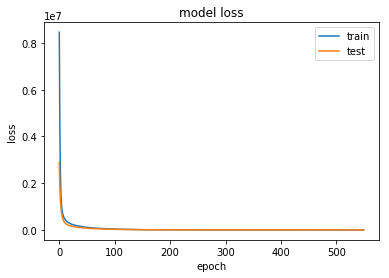

In [60]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

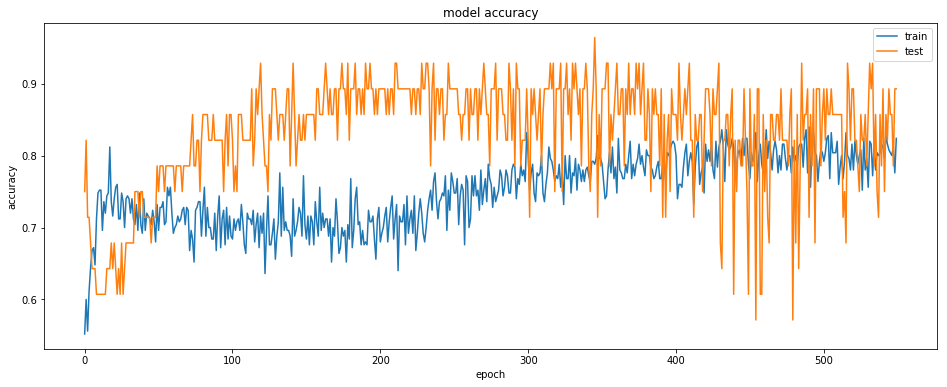

In [61]:
plt.figure(figsize=(16,6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

### модель посложнее 6, модель переобучилась, уменьшили кол-во эпох

1. непонятно на что влияет параметр verbose, но изменение его с 1 на 2 увеличило стабильность
2. почитать про reducelronPlateau
3. 

In [69]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW,
                activity_regularizer=regularizers.l2(0.05)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.65))
model.add(Dense(360,
                activity_regularizer=regularizers.l2(0.05)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(2))
model.add(Activation('softmax'))

In [70]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=50, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)

In [71]:
opt = Nadam(lr=0.001)

In [72]:
model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [73]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 350, 
          batch_size = 15, 
          verbose=2, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 250 samples, validate on 28 samples
Epoch 1/350
 - 1s - loss: 6588264.5100 - acc: 0.4960 - val_loss: 2433305.2232 - val_acc: 0.7500

Epoch 00001: val_loss improved from inf to 2433305.22321, saving model to test.hdf5
Epoch 2/350
 - 0s - loss: 3334743.5088 - acc: 0.5400 - val_loss: 1529263.9040 - val_acc: 0.6429

Epoch 00002: val_loss improved from 2433305.22321 to 1529263.90402, saving model to test.hdf5
Epoch 3/350
 - 0s - loss: 1820536.1375 - acc: 0.5560 - val_loss: 1041588.0156 - val_acc: 0.6429

Epoch 00003: val_loss improved from 1529263.90402 to 1041588.01562, saving model to test.hdf5
Epoch 4/350
 - 0s - loss: 1196674.2675 - acc: 0.6560 - val_loss: 761294.2879 - val_acc: 0.6429

Epoch 00004: val_loss improved from 1041588.01562 to 761294.28795, saving model to test.hdf5
Epoch 5/350
 - 0s - loss: 887723.4062 - acc: 0.6360 - val_loss: 585224.9431 - val_acc: 0.6429

Epoch 00005: val_loss improved from 761294.28795 to 585224.94308, saving model to test.hdf5
Epoch 6/350
 - 0

Epoch 45/350
 - 0s - loss: 108136.5063 - acc: 0.7360 - val_loss: 69532.4099 - val_acc: 0.7500

Epoch 00045: val_loss improved from 71264.29771 to 69532.40988, saving model to test.hdf5
Epoch 46/350
 - 0s - loss: 105759.7741 - acc: 0.7040 - val_loss: 67187.1814 - val_acc: 0.7857

Epoch 00046: val_loss improved from 69532.40988 to 67187.18136, saving model to test.hdf5
Epoch 47/350
 - 0s - loss: 102230.0392 - acc: 0.7320 - val_loss: 65241.0498 - val_acc: 0.7857

Epoch 00047: val_loss improved from 67187.18136 to 65241.04980, saving model to test.hdf5
Epoch 48/350
 - 0s - loss: 99442.0998 - acc: 0.7080 - val_loss: 63530.3632 - val_acc: 0.7500

Epoch 00048: val_loss improved from 65241.04980 to 63530.36325, saving model to test.hdf5
Epoch 49/350
 - 0s - loss: 96233.3336 - acc: 0.7240 - val_loss: 61985.0981 - val_acc: 0.7857

Epoch 00049: val_loss improved from 63530.36325 to 61985.09807, saving model to test.hdf5
Epoch 50/350
 - 0s - loss: 92881.4997 - acc: 0.7040 - val_loss: 59844.6455 - 

Epoch 90/350
 - 0s - loss: 28091.0401 - acc: 0.7240 - val_loss: 19136.3602 - val_acc: 0.7857

Epoch 00090: val_loss improved from 20040.38632 to 19136.36018, saving model to test.hdf5
Epoch 91/350
 - 0s - loss: 27543.9150 - acc: 0.7520 - val_loss: 18661.7382 - val_acc: 0.8571

Epoch 00091: val_loss improved from 19136.36018 to 18661.73816, saving model to test.hdf5
Epoch 92/350
 - 0s - loss: 26460.5330 - acc: 0.7320 - val_loss: 18356.9222 - val_acc: 0.7500

Epoch 00092: val_loss improved from 18661.73816 to 18356.92217, saving model to test.hdf5
Epoch 93/350
 - 0s - loss: 25686.4588 - acc: 0.7400 - val_loss: 17702.4271 - val_acc: 0.8929

Epoch 00093: val_loss improved from 18356.92217 to 17702.42705, saving model to test.hdf5
Epoch 94/350
 - 0s - loss: 24902.7263 - acc: 0.6760 - val_loss: 17039.0095 - val_acc: 0.8929

Epoch 00094: val_loss improved from 17702.42705 to 17039.00951, saving model to test.hdf5
Epoch 95/350
 - 0s - loss: 24102.2061 - acc: 0.6960 - val_loss: 16940.7878 - val

 - 0s - loss: 6687.9741 - acc: 0.6960 - val_loss: 5217.5175 - val_acc: 0.8571

Epoch 00135: val_loss improved from 5442.77745 to 5217.51752, saving model to test.hdf5
Epoch 136/350
 - 0s - loss: 6457.1736 - acc: 0.7040 - val_loss: 5135.7786 - val_acc: 0.8929

Epoch 00136: val_loss improved from 5217.51752 to 5135.77861, saving model to test.hdf5
Epoch 137/350
 - 0s - loss: 6253.9489 - acc: 0.6720 - val_loss: 5042.8657 - val_acc: 0.8571

Epoch 00137: val_loss improved from 5135.77861 to 5042.86566, saving model to test.hdf5
Epoch 138/350
 - 0s - loss: 6000.4505 - acc: 0.6920 - val_loss: 4821.9359 - val_acc: 0.9286

Epoch 00138: val_loss improved from 5042.86566 to 4821.93590, saving model to test.hdf5
Epoch 139/350
 - 0s - loss: 5820.2854 - acc: 0.6560 - val_loss: 4637.5725 - val_acc: 0.9286

Epoch 00139: val_loss improved from 4821.93590 to 4637.57254, saving model to test.hdf5
Epoch 140/350
 - 0s - loss: 5615.0164 - acc: 0.6760 - val_loss: 4519.5802 - val_acc: 0.9286

Epoch 00140: val

 - 0s - loss: 1527.0762 - acc: 0.6520 - val_loss: 1419.6497 - val_acc: 0.8929

Epoch 00180: val_loss improved from 1441.82107 to 1419.64970, saving model to test.hdf5
Epoch 181/350
 - 0s - loss: 1503.4654 - acc: 0.6880 - val_loss: 1360.1235 - val_acc: 0.8929

Epoch 00181: val_loss improved from 1419.64970 to 1360.12346, saving model to test.hdf5
Epoch 182/350
 - 0s - loss: 1446.8620 - acc: 0.6600 - val_loss: 1330.3874 - val_acc: 0.8929

Epoch 00182: val_loss improved from 1360.12346 to 1330.38738, saving model to test.hdf5
Epoch 183/350
 - 0s - loss: 1400.4780 - acc: 0.7280 - val_loss: 1287.7059 - val_acc: 0.8214

Epoch 00183: val_loss improved from 1330.38738 to 1287.70591, saving model to test.hdf5
Epoch 184/350
 - 0s - loss: 1338.6818 - acc: 0.7080 - val_loss: 1245.6568 - val_acc: 0.8929

Epoch 00184: val_loss improved from 1287.70591 to 1245.65683, saving model to test.hdf5
Epoch 185/350
 - 0s - loss: 1272.6247 - acc: 0.6840 - val_loss: 1228.9950 - val_acc: 0.8929

Epoch 00185: val

 - 0s - loss: 342.2329 - acc: 0.7480 - val_loss: 351.4937 - val_acc: 0.7857

Epoch 00226: val_loss improved from 369.59302 to 351.49374, saving model to test.hdf5
Epoch 227/350
 - 0s - loss: 322.4689 - acc: 0.7120 - val_loss: 343.1688 - val_acc: 0.8929

Epoch 00227: val_loss improved from 351.49374 to 343.16876, saving model to test.hdf5
Epoch 228/350
 - 0s - loss: 313.5403 - acc: 0.7480 - val_loss: 326.0442 - val_acc: 0.8571

Epoch 00228: val_loss improved from 343.16876 to 326.04417, saving model to test.hdf5
Epoch 229/350
 - 0s - loss: 305.2987 - acc: 0.7400 - val_loss: 317.0250 - val_acc: 0.8214

Epoch 00229: val_loss improved from 326.04417 to 317.02503, saving model to test.hdf5
Epoch 230/350
 - 0s - loss: 296.4360 - acc: 0.7200 - val_loss: 308.5535 - val_acc: 0.8929

Epoch 00230: val_loss improved from 317.02503 to 308.55346, saving model to test.hdf5
Epoch 231/350
 - 0s - loss: 281.1626 - acc: 0.7160 - val_loss: 302.8319 - val_acc: 0.8214

Epoch 00231: val_loss improved from 30

 - 0s - loss: 70.5266 - acc: 0.7720 - val_loss: 80.0816 - val_acc: 0.8214

Epoch 00272: val_loss improved from 85.38446 to 80.08155, saving model to test.hdf5
Epoch 273/350
 - 0s - loss: 65.9735 - acc: 0.7520 - val_loss: 77.4458 - val_acc: 0.8214

Epoch 00273: val_loss improved from 80.08155 to 77.44582, saving model to test.hdf5
Epoch 274/350
 - 0s - loss: 64.8257 - acc: 0.7480 - val_loss: 77.8672 - val_acc: 0.8214

Epoch 00274: val_loss did not improve from 77.44582
Epoch 275/350
 - 0s - loss: 61.6213 - acc: 0.7720 - val_loss: 73.4333 - val_acc: 0.8571

Epoch 00275: val_loss improved from 77.44582 to 73.43331, saving model to test.hdf5
Epoch 276/350
 - 0s - loss: 61.2154 - acc: 0.7600 - val_loss: 72.7083 - val_acc: 0.7500

Epoch 00276: val_loss improved from 73.43331 to 72.70834, saving model to test.hdf5
Epoch 277/350
 - 0s - loss: 58.3120 - acc: 0.7520 - val_loss: 68.2723 - val_acc: 0.7500

Epoch 00277: val_loss improved from 72.70834 to 68.27228, saving model to test.hdf5
Epoch 27


Epoch 00320: val_loss improved from 15.86175 to 14.24804, saving model to test.hdf5
Epoch 321/350
 - 0s - loss: 11.9459 - acc: 0.7640 - val_loss: 13.9650 - val_acc: 0.8214

Epoch 00321: val_loss improved from 14.24804 to 13.96505, saving model to test.hdf5
Epoch 322/350
 - 0s - loss: 13.4138 - acc: 0.7400 - val_loss: 13.4786 - val_acc: 0.9286

Epoch 00322: val_loss improved from 13.96505 to 13.47859, saving model to test.hdf5
Epoch 323/350
 - 0s - loss: 11.6445 - acc: 0.7320 - val_loss: 14.5957 - val_acc: 0.8571

Epoch 00323: val_loss did not improve from 13.47859
Epoch 324/350
 - 0s - loss: 13.3034 - acc: 0.7960 - val_loss: 15.0535 - val_acc: 0.8571

Epoch 00324: val_loss did not improve from 13.47859
Epoch 325/350
 - 0s - loss: 29.5855 - acc: 0.7840 - val_loss: 12.8446 - val_acc: 0.7500

Epoch 00325: val_loss improved from 13.47859 to 12.84460, saving model to test.hdf5
Epoch 326/350
 - 0s - loss: 12.3160 - acc: 0.7880 - val_loss: 14.0388 - val_acc: 0.8571

Epoch 00326: val_loss did

#### графики

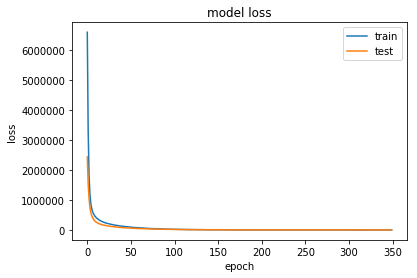

In [74]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

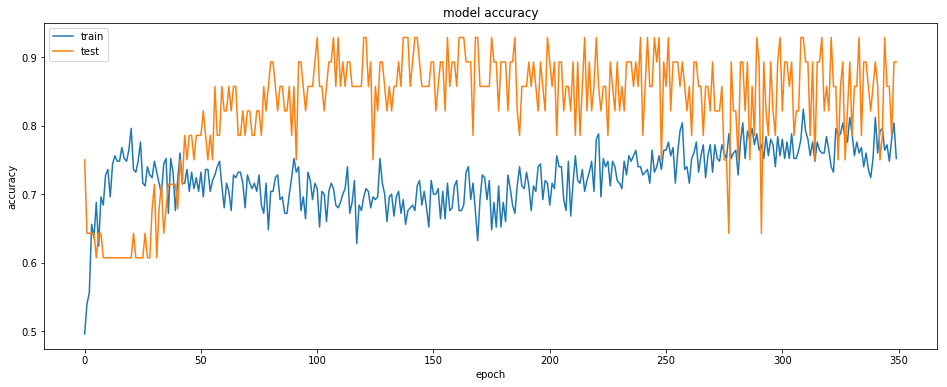

In [75]:
plt.figure(figsize=(16,6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

## Регрессия

???? Есть один большой вопрос по метрикам ошибок в регрессиях - где-то есть mse, где-то rmse, нет унифицированного критерия. Также лично для меня значения mse/rmse не показательны - я не понимаю, это много или мало????

???? В регрессии получается, что метрика потерь и метрика качества одинаковая - это нормально????

In [12]:
def  shuffle_in_unison (a, b):

    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b
 
def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test

Скорректировали функцию X, Y - заменили Y пустым списком, добавили нормализацию (без нее также пробовал, она ухудшает прогноз)

In [13]:
WINDOW = 26
STEP = 1
FORECAST = 5


X, Y = [], []
for i in range(0, len(data), STEP): 
    try:
        x_i = data[i:i+WINDOW]
        y_i = data[i+WINDOW+FORECAST]  

        last_close = x_i[WINDOW-1]
        next_close = y_i

        y = []

    except Exception as e:
        print (e)
        break

    X.append(x_i)
    Y.append(y_i)

X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X]
X, Y = np.array(X), np.array(Y)

X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

index out of bounds


### модель простая

по отношению к регрессии заменили метрикуи ошибку на mse, выходную функцию активации на сигмоид

In [238]:
model = Sequential()
model.add(Dense(64, input_dim=WINDOW))
model.add(Activation('sigmoid'))
model.add(Dense(1))
model.add(Activation('linear'))

In [239]:
opt = Nadam(lr=0.0001)

In [240]:
model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

In [241]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 350, 
          batch_size = 15, 
          verbose=2, 
          validation_data=(X_test, Y_test),
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 250 samples, validate on 28 samples
Epoch 1/350
 - 1s - loss: 307749.2544 - mean_squared_error: 307749.2544 - val_loss: 631761.7500 - val_mean_squared_error: 631761.7500
Epoch 2/350
 - 0s - loss: 307676.9605 - mean_squared_error: 307676.9605 - val_loss: 631639.3845 - val_mean_squared_error: 631639.3845
Epoch 3/350
 - 0s - loss: 307601.0023 - mean_squared_error: 307601.0023 - val_loss: 631514.1417 - val_mean_squared_error: 631514.1417
Epoch 4/350
 - 0s - loss: 307523.0416 - mean_squared_error: 307523.0416 - val_loss: 631388.4046 - val_mean_squared_error: 631388.4046
Epoch 5/350
 - 0s - loss: 307445.0877 - mean_squared_error: 307445.0877 - val_loss: 631263.9336 - val_mean_squared_error: 631263.9336
Epoch 6/350
 - 0s - loss: 307367.6361 - mean_squared_error: 307367.6361 - val_loss: 631138.4570 - val_mean_squared_error: 631138.4570
Epoch 7/350
 - 0s - loss: 307288.9961 - mean_squared_error: 307288.9961 - val_loss: 631012.2561 - val_mean_squared_error: 631012.2561
Epoch 8/350
 - 0s

Epoch 62/350
 - 0s - loss: 303247.1872 - mean_squared_error: 303247.1872 - val_loss: 624429.3382 - val_mean_squared_error: 624429.3382
Epoch 63/350
 - 0s - loss: 303181.4463 - mean_squared_error: 303181.4463 - val_loss: 624316.2902 - val_mean_squared_error: 624316.2902
Epoch 64/350
 - 0s - loss: 303114.2006 - mean_squared_error: 303114.2006 - val_loss: 624204.4481 - val_mean_squared_error: 624204.4481
Epoch 65/350
 - 0s - loss: 303047.3373 - mean_squared_error: 303047.3373 - val_loss: 624094.2941 - val_mean_squared_error: 624094.2941
Epoch 66/350
 - 0s - loss: 302982.2578 - mean_squared_error: 302982.2578 - val_loss: 623980.7852 - val_mean_squared_error: 623980.7852
Epoch 67/350
 - 0s - loss: 302915.0165 - mean_squared_error: 302915.0165 - val_loss: 623871.3265 - val_mean_squared_error: 623871.3265
Epoch 68/350
 - 0s - loss: 302848.8473 - mean_squared_error: 302848.8473 - val_loss: 623763.1657 - val_mean_squared_error: 623763.1657
Epoch 69/350
 - 0s - loss: 302783.6862 - mean_squared_e

Epoch 123/350
 - 0s - loss: 299523.8334 - mean_squared_error: 299523.8334 - val_loss: 618096.0541 - val_mean_squared_error: 618096.0541
Epoch 124/350
 - 0s - loss: 299465.2395 - mean_squared_error: 299465.2395 - val_loss: 617997.1970 - val_mean_squared_error: 617997.1970
Epoch 125/350
 - 0s - loss: 299407.7789 - mean_squared_error: 299407.7789 - val_loss: 617896.3025 - val_mean_squared_error: 617896.3025
Epoch 126/350
 - 0s - loss: 299350.2011 - mean_squared_error: 299350.2011 - val_loss: 617795.1802 - val_mean_squared_error: 617795.1802
Epoch 127/350
 - 0s - loss: 299292.4280 - mean_squared_error: 299292.4280 - val_loss: 617695.3912 - val_mean_squared_error: 617695.3912
Epoch 128/350
 - 0s - loss: 299235.0217 - mean_squared_error: 299235.0217 - val_loss: 617594.4191 - val_mean_squared_error: 617594.4191
Epoch 129/350
 - 0s - loss: 299176.8862 - mean_squared_error: 299176.8862 - val_loss: 617494.6021 - val_mean_squared_error: 617494.6021
Epoch 130/350
 - 0s - loss: 299119.3059 - mean_s

Epoch 184/350
 - 0s - loss: 295849.6523 - mean_squared_error: 295849.6523 - val_loss: 611704.3064 - val_mean_squared_error: 611704.3064
Epoch 185/350
 - 0s - loss: 295788.6439 - mean_squared_error: 295788.6439 - val_loss: 611593.1440 - val_mean_squared_error: 611593.1440
Epoch 186/350
 - 0s - loss: 295725.3796 - mean_squared_error: 295725.3796 - val_loss: 611485.7684 - val_mean_squared_error: 611485.7684
Epoch 187/350
 - 0s - loss: 295662.3933 - mean_squared_error: 295662.3933 - val_loss: 611380.0592 - val_mean_squared_error: 611380.0592
Epoch 188/350
 - 0s - loss: 295600.7731 - mean_squared_error: 295600.7731 - val_loss: 611273.2126 - val_mean_squared_error: 611273.2126
Epoch 189/350
 - 0s - loss: 295540.4906 - mean_squared_error: 295540.4906 - val_loss: 611161.2472 - val_mean_squared_error: 611161.2472
Epoch 190/350
 - 0s - loss: 295477.0141 - mean_squared_error: 295477.0141 - val_loss: 611053.3856 - val_mean_squared_error: 611053.3856
Epoch 191/350
 - 0s - loss: 295414.3475 - mean_s

Epoch 245/350
 - 0s - loss: 291926.9359 - mean_squared_error: 291926.9359 - val_loss: 604878.8488 - val_mean_squared_error: 604878.8488
Epoch 246/350
 - 0s - loss: 291858.3862 - mean_squared_error: 291858.3862 - val_loss: 604757.2494 - val_mean_squared_error: 604757.2494
Epoch 247/350
 - 0s - loss: 291788.1350 - mean_squared_error: 291788.1350 - val_loss: 604635.7522 - val_mean_squared_error: 604635.7522
Epoch 248/350
 - 0s - loss: 291717.6469 - mean_squared_error: 291717.6469 - val_loss: 604513.7433 - val_mean_squared_error: 604513.7433
Epoch 249/350
 - 0s - loss: 291647.1280 - mean_squared_error: 291647.1280 - val_loss: 604391.3834 - val_mean_squared_error: 604391.3834
Epoch 250/350
 - 0s - loss: 291575.8033 - mean_squared_error: 291575.8033 - val_loss: 604269.3750 - val_mean_squared_error: 604269.3750
Epoch 251/350
 - 0s - loss: 291503.8750 - mean_squared_error: 291503.8750 - val_loss: 604146.8376 - val_mean_squared_error: 604146.8376
Epoch 252/350
 - 0s - loss: 291432.0733 - mean_s

Epoch 306/350
 - 0s - loss: 287403.3425 - mean_squared_error: 287403.3425 - val_loss: 597092.5619 - val_mean_squared_error: 597092.5619
Epoch 307/350
 - 0s - loss: 287327.3866 - mean_squared_error: 287327.3866 - val_loss: 596966.0698 - val_mean_squared_error: 596966.0698
Epoch 308/350
 - 0s - loss: 287254.3544 - mean_squared_error: 287254.3544 - val_loss: 596835.1881 - val_mean_squared_error: 596835.1881
Epoch 309/350
 - 0s - loss: 287179.6256 - mean_squared_error: 287179.6256 - val_loss: 596708.4498 - val_mean_squared_error: 596708.4498
Epoch 310/350
 - 0s - loss: 287105.8900 - mean_squared_error: 287105.8900 - val_loss: 596580.0050 - val_mean_squared_error: 596580.0050
Epoch 311/350
 - 0s - loss: 287032.4102 - mean_squared_error: 287032.4102 - val_loss: 596451.2662 - val_mean_squared_error: 596451.2662
Epoch 312/350
 - 0s - loss: 286957.3858 - mean_squared_error: 286957.3858 - val_loss: 596323.2690 - val_mean_squared_error: 596323.2690
Epoch 313/350
 - 0s - loss: 286883.2269 - mean_s

#### графики

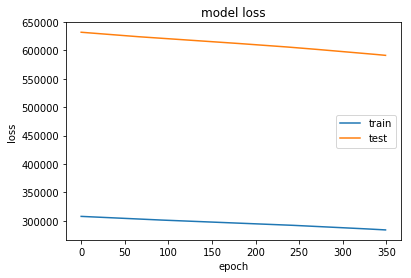

In [242]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

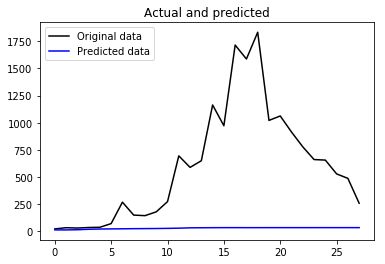

In [243]:
pred = model.predict(np.array(X_test))
original = Y_test
predicted = pred

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted')
plt.show()

### модель посложнее, добавили слой, два сигмоида

In [244]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW))
model.add(Activation('sigmoid'))
model.add(Dense(360))
model.add(Activation('sigmoid'))
model.add(Dense(1))
model.add(Activation('linear'))

In [245]:
opt = Nadam(lr=0.0001)

In [246]:
model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

In [247]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 550, 
          batch_size = 15, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 250 samples, validate on 28 samples
Epoch 1/550
250/250 [==============================] - 1s 6ms/step - loss: 307151.7537 - mean_squared_error: 307151.7537 - val_loss: 630232.3075 - val_mean_squared_error: 630232.3075
Epoch 2/550
250/250 [==============================] - 0s 141us/step - loss: 306443.5911 - mean_squared_error: 306443.5911 - val_loss: 628963.7037 - val_mean_squared_error: 628963.7037
Epoch 3/550
250/250 [==============================] - 0s 143us/step - loss: 305675.5059 - mean_squared_error: 305675.5059 - val_loss: 627675.3929 - val_mean_squared_error: 627675.3929
Epoch 4/550
250/250 [==============================] - 0s 133us/step - loss: 304894.4519 - mean_squared_error: 304894.4519 - val_loss: 626388.7946 - val_mean_squared_error: 626388.7946
Epoch 5/550
250/250 [==============================] - 0s 139us/step - loss: 304114.4398 - mean_squared_error: 304114.4398 - val_loss: 625085.6390 - val_mean_squared_error: 625085.6390
Epoch 6/550
250/250 [===========

Epoch 45/550
250/250 [==============================] - 0s 133us/step - loss: 287554.2644 - mean_squared_error: 287554.2644 - val_loss: 597594.1903 - val_mean_squared_error: 597594.1903
Epoch 46/550
250/250 [==============================] - 0s 130us/step - loss: 287284.5519 - mean_squared_error: 287284.5519 - val_loss: 597134.9950 - val_mean_squared_error: 597134.9950
Epoch 47/550
250/250 [==============================] - 0s 129us/step - loss: 287019.3122 - mean_squared_error: 287019.3122 - val_loss: 596670.0525 - val_mean_squared_error: 596670.0525
Epoch 48/550
250/250 [==============================] - 0s 127us/step - loss: 286748.6103 - mean_squared_error: 286748.6103 - val_loss: 596215.7718 - val_mean_squared_error: 596215.7718
Epoch 49/550
250/250 [==============================] - 0s 132us/step - loss: 286483.0994 - mean_squared_error: 286483.0994 - val_loss: 595759.1004 - val_mean_squared_error: 595759.1004
Epoch 50/550
250/250 [==============================] - 0s 139us/step 

250/250 [==============================] - 0s 139us/step - loss: 276272.4647 - mean_squared_error: 276272.4647 - val_loss: 578097.1484 - val_mean_squared_error: 578097.1484
Epoch 90/550
250/250 [==============================] - 0s 140us/step - loss: 276025.4681 - mean_squared_error: 276025.4681 - val_loss: 577662.2640 - val_mean_squared_error: 577662.2640
Epoch 91/550
250/250 [==============================] - 0s 149us/step - loss: 275777.5828 - mean_squared_error: 275777.5828 - val_loss: 577234.8008 - val_mean_squared_error: 577234.8008
Epoch 92/550
250/250 [==============================] - 0s 139us/step - loss: 275535.3328 - mean_squared_error: 275535.3328 - val_loss: 576797.2679 - val_mean_squared_error: 576797.2679
Epoch 93/550
250/250 [==============================] - 0s 141us/step - loss: 275283.5845 - mean_squared_error: 275283.5845 - val_loss: 576366.7015 - val_mean_squared_error: 576366.7015
Epoch 94/550
250/250 [==============================] - 0s 137us/step - loss: 27503

Epoch 133/550
250/250 [==============================] - 0s 133us/step - loss: 265755.9931 - mean_squared_error: 265755.9931 - val_loss: 559726.2383 - val_mean_squared_error: 559726.2383
Epoch 134/550
250/250 [==============================] - 0s 137us/step - loss: 265521.0434 - mean_squared_error: 265521.0434 - val_loss: 559315.6975 - val_mean_squared_error: 559315.6975
Epoch 135/550
250/250 [==============================] - 0s 134us/step - loss: 265284.8830 - mean_squared_error: 265284.8830 - val_loss: 558911.5301 - val_mean_squared_error: 558911.5301
Epoch 136/550
250/250 [==============================] - 0s 139us/step - loss: 265052.7425 - mean_squared_error: 265052.7425 - val_loss: 558506.1663 - val_mean_squared_error: 558506.1663
Epoch 137/550
250/250 [==============================] - 0s 131us/step - loss: 264820.4189 - mean_squared_error: 264820.4189 - val_loss: 558096.8761 - val_mean_squared_error: 558096.8761
Epoch 138/550
250/250 [==============================] - 0s 133us

Epoch 177/550
250/250 [==============================] - 0s 130us/step - loss: 255608.3920 - mean_squared_error: 255608.3920 - val_loss: 542127.5195 - val_mean_squared_error: 542127.5195
Epoch 178/550
250/250 [==============================] - 0s 137us/step - loss: 255386.3869 - mean_squared_error: 255386.3869 - val_loss: 541730.6350 - val_mean_squared_error: 541730.6350
Epoch 179/550
250/250 [==============================] - 0s 127us/step - loss: 255164.1604 - mean_squared_error: 255164.1604 - val_loss: 541333.0826 - val_mean_squared_error: 541333.0826
Epoch 180/550
250/250 [==============================] - 0s 126us/step - loss: 254936.3553 - mean_squared_error: 254936.3553 - val_loss: 540946.4012 - val_mean_squared_error: 540946.4012
Epoch 181/550
250/250 [==============================] - 0s 125us/step - loss: 254713.2749 - mean_squared_error: 254713.2749 - val_loss: 540561.3627 - val_mean_squared_error: 540561.3627
Epoch 182/550
250/250 [==============================] - 0s 129us

Epoch 221/550
250/250 [==============================] - 0s 185us/step - loss: 246034.6659 - mean_squared_error: 246034.6659 - val_loss: 525362.3521 - val_mean_squared_error: 525362.3521
Epoch 222/550
250/250 [==============================] - 0s 181us/step - loss: 245828.2171 - mean_squared_error: 245828.2171 - val_loss: 524979.1735 - val_mean_squared_error: 524979.1735
Epoch 223/550
250/250 [==============================] - 0s 186us/step - loss: 245611.1141 - mean_squared_error: 245611.1141 - val_loss: 524616.5480 - val_mean_squared_error: 524616.5480
Epoch 224/550
250/250 [==============================] - 0s 192us/step - loss: 245401.8656 - mean_squared_error: 245401.8656 - val_loss: 524237.0134 - val_mean_squared_error: 524237.0134
Epoch 225/550
250/250 [==============================] - 0s 194us/step - loss: 245189.9134 - mean_squared_error: 245189.9134 - val_loss: 523863.0787 - val_mean_squared_error: 523863.0787
Epoch 226/550
250/250 [==============================] - 0s 194us

Epoch 265/550
250/250 [==============================] - 0s 157us/step - loss: 236900.1150 - mean_squared_error: 236900.1150 - val_loss: 509171.2098 - val_mean_squared_error: 509171.2098
Epoch 266/550
250/250 [==============================] - 0s 157us/step - loss: 236693.2283 - mean_squared_error: 236693.2283 - val_loss: 508818.9838 - val_mean_squared_error: 508818.9838
Epoch 267/550
250/250 [==============================] - 0s 157us/step - loss: 236491.6560 - mean_squared_error: 236491.6560 - val_loss: 508464.8203 - val_mean_squared_error: 508464.8203
Epoch 268/550
250/250 [==============================] - 0s 153us/step - loss: 236290.6376 - mean_squared_error: 236290.6376 - val_loss: 508102.5798 - val_mean_squared_error: 508102.5798
Epoch 269/550
250/250 [==============================] - 0s 157us/step - loss: 236092.2841 - mean_squared_error: 236092.2841 - val_loss: 507736.4369 - val_mean_squared_error: 507736.4369
Epoch 270/550
250/250 [==============================] - 0s 163us

Epoch 309/550
250/250 [==============================] - 0s 153us/step - loss: 228090.9057 - mean_squared_error: 228090.9057 - val_loss: 493476.1334 - val_mean_squared_error: 493476.1334
Epoch 310/550
250/250 [==============================] - 0s 157us/step - loss: 227897.6454 - mean_squared_error: 227897.6454 - val_loss: 493118.0653 - val_mean_squared_error: 493118.0653
Epoch 311/550
250/250 [==============================] - 0s 156us/step - loss: 227698.5773 - mean_squared_error: 227698.5773 - val_loss: 492765.4986 - val_mean_squared_error: 492765.4986
Epoch 312/550
250/250 [==============================] - 0s 155us/step - loss: 227504.3152 - mean_squared_error: 227504.3152 - val_loss: 492402.5237 - val_mean_squared_error: 492402.5237
Epoch 313/550
250/250 [==============================] - 0s 161us/step - loss: 227300.9014 - mean_squared_error: 227300.9014 - val_loss: 492061.9434 - val_mean_squared_error: 492061.9434
Epoch 314/550
250/250 [==============================] - 0s 156us

Epoch 353/550
250/250 [==============================] - 0s 155us/step - loss: 219556.6220 - mean_squared_error: 219556.6220 - val_loss: 478192.2737 - val_mean_squared_error: 478192.2737
Epoch 354/550
250/250 [==============================] - 0s 153us/step - loss: 219362.9334 - mean_squared_error: 219362.9334 - val_loss: 477849.0435 - val_mean_squared_error: 477849.0435
Epoch 355/550
250/250 [==============================] - 0s 159us/step - loss: 219172.5196 - mean_squared_error: 219172.5196 - val_loss: 477505.2492 - val_mean_squared_error: 477505.2492
Epoch 356/550
250/250 [==============================] - 0s 159us/step - loss: 218981.5701 - mean_squared_error: 218981.5701 - val_loss: 477165.9333 - val_mean_squared_error: 477165.9333
Epoch 357/550
250/250 [==============================] - 0s 155us/step - loss: 218790.0825 - mean_squared_error: 218790.0825 - val_loss: 476823.9975 - val_mean_squared_error: 476823.9975
Epoch 358/550
250/250 [==============================] - 0s 157us

Epoch 397/550
250/250 [==============================] - 0s 155us/step - loss: 211299.9223 - mean_squared_error: 211299.9223 - val_loss: 463251.0368 - val_mean_squared_error: 463251.0368
Epoch 398/550
250/250 [==============================] - 0s 151us/step - loss: 211112.4764 - mean_squared_error: 211112.4764 - val_loss: 462925.9249 - val_mean_squared_error: 462925.9249
Epoch 399/550
250/250 [==============================] - 0s 155us/step - loss: 210932.7062 - mean_squared_error: 210932.7062 - val_loss: 462592.5441 - val_mean_squared_error: 462592.5441
Epoch 400/550
250/250 [==============================] - 0s 153us/step - loss: 210752.4592 - mean_squared_error: 210752.4592 - val_loss: 462250.1992 - val_mean_squared_error: 462250.1992
Epoch 401/550
250/250 [==============================] - 0s 169us/step - loss: 210564.7127 - mean_squared_error: 210564.7127 - val_loss: 461926.5686 - val_mean_squared_error: 461926.5686
Epoch 402/550
250/250 [==============================] - 0s 155us

Epoch 441/550
250/250 [==============================] - 0s 153us/step - loss: 203366.6245 - mean_squared_error: 203366.6245 - val_loss: 448744.2860 - val_mean_squared_error: 448744.2860
Epoch 442/550
250/250 [==============================] - 0s 153us/step - loss: 203190.5667 - mean_squared_error: 203190.5667 - val_loss: 448413.9414 - val_mean_squared_error: 448413.9414
Epoch 443/550
250/250 [==============================] - 0s 153us/step - loss: 203012.9291 - mean_squared_error: 203012.9291 - val_loss: 448076.4325 - val_mean_squared_error: 448076.4325
Epoch 444/550
250/250 [==============================] - 0s 154us/step - loss: 202834.2752 - mean_squared_error: 202834.2752 - val_loss: 447747.8728 - val_mean_squared_error: 447747.8728
Epoch 445/550
250/250 [==============================] - 0s 153us/step - loss: 202654.4405 - mean_squared_error: 202654.4405 - val_loss: 447423.6465 - val_mean_squared_error: 447423.6465
Epoch 446/550
250/250 [==============================] - 0s 154us

Epoch 485/550
250/250 [==============================] - 0s 171us/step - loss: 195736.8661 - mean_squared_error: 195736.8661 - val_loss: 434576.7221 - val_mean_squared_error: 434576.7221
Epoch 486/550
250/250 [==============================] - 0s 172us/step - loss: 195567.2555 - mean_squared_error: 195567.2555 - val_loss: 434262.5700 - val_mean_squared_error: 434262.5700
Epoch 487/550
250/250 [==============================] - 0s 185us/step - loss: 195399.2620 - mean_squared_error: 195399.2620 - val_loss: 433941.1434 - val_mean_squared_error: 433941.1434
Epoch 488/550
250/250 [==============================] - 0s 177us/step - loss: 195227.8895 - mean_squared_error: 195227.8895 - val_loss: 433631.4534 - val_mean_squared_error: 433631.4534
Epoch 489/550
250/250 [==============================] - 0s 173us/step - loss: 195056.6850 - mean_squared_error: 195056.6850 - val_loss: 433326.9369 - val_mean_squared_error: 433326.9369
Epoch 490/550
250/250 [==============================] - 0s 181us

Epoch 529/550
250/250 [==============================] - 0s 179us/step - loss: 188400.4309 - mean_squared_error: 188400.4309 - val_loss: 420789.5441 - val_mean_squared_error: 420789.5441
Epoch 530/550
250/250 [==============================] - 0s 186us/step - loss: 188242.7708 - mean_squared_error: 188242.7708 - val_loss: 420480.5991 - val_mean_squared_error: 420480.5991
Epoch 531/550
250/250 [==============================] - 0s 179us/step - loss: 188081.1198 - mean_squared_error: 188081.1198 - val_loss: 420160.0605 - val_mean_squared_error: 420160.0605
Epoch 532/550
250/250 [==============================] - 0s 192us/step - loss: 187908.2120 - mean_squared_error: 187908.2120 - val_loss: 419861.0519 - val_mean_squared_error: 419861.0519
Epoch 533/550
250/250 [==============================] - 0s 190us/step - loss: 187753.0336 - mean_squared_error: 187753.0336 - val_loss: 419536.6886 - val_mean_squared_error: 419536.6886
Epoch 534/550
250/250 [==============================] - 0s 188us

#### графики

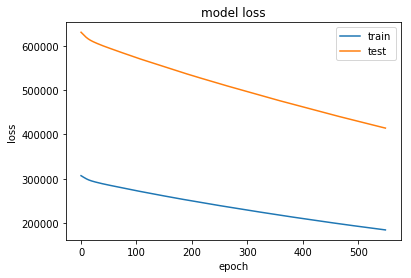

In [248]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

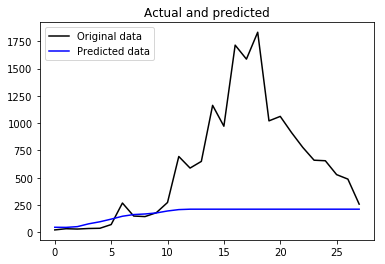

In [249]:
pred = model.predict(np.array(X_test))
original = Y_test
predicted = pred

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted')
plt.show()

### модель посложнее+, добавили слой, два сигмоида, уменьшаем кол-во эпох

In [250]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW))
model.add(Activation('sigmoid'))
model.add(Dense(360))
model.add(Activation('sigmoid'))
model.add(Dense(1))
model.add(Activation('linear'))

In [251]:
opt = Nadam(lr=0.0001)

In [252]:
model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

In [253]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 250, 
          batch_size = 15, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 250 samples, validate on 28 samples
Epoch 1/250
250/250 [==============================] - 2s 7ms/step - loss: 306546.2088 - mean_squared_error: 306546.2088 - val_loss: 629215.0474 - val_mean_squared_error: 629215.0474
Epoch 2/250
250/250 [==============================] - 0s 145us/step - loss: 305873.2714 - mean_squared_error: 305873.2714 - val_loss: 628033.6323 - val_mean_squared_error: 628033.6323
Epoch 3/250
250/250 [==============================] - 0s 146us/step - loss: 305151.0470 - mean_squared_error: 305151.0470 - val_loss: 626791.1049 - val_mean_squared_error: 626791.1049
Epoch 4/250
250/250 [==============================] - 0s 153us/step - loss: 304393.1219 - mean_squared_error: 304393.1219 - val_loss: 625547.6177 - val_mean_squared_error: 625547.6177
Epoch 5/250
250/250 [==============================] - 0s 147us/step - loss: 303642.5106 - mean_squared_error: 303642.5106 - val_loss: 624293.1613 - val_mean_squared_error: 624293.1613
Epoch 6/250
250/250 [===========

Epoch 45/250
250/250 [==============================] - 0s 168us/step - loss: 286925.5009 - mean_squared_error: 286925.5009 - val_loss: 596478.6942 - val_mean_squared_error: 596478.6942
Epoch 46/250
250/250 [==============================] - 0s 163us/step - loss: 286633.8992 - mean_squared_error: 286633.8992 - val_loss: 596003.1244 - val_mean_squared_error: 596003.1244
Epoch 47/250
250/250 [==============================] - 0s 159us/step - loss: 286356.1247 - mean_squared_error: 286356.1247 - val_loss: 595514.8253 - val_mean_squared_error: 595514.8253
Epoch 48/250
250/250 [==============================] - 0s 167us/step - loss: 286070.0372 - mean_squared_error: 286070.0372 - val_loss: 595032.9464 - val_mean_squared_error: 595032.9464
Epoch 49/250
250/250 [==============================] - 0s 161us/step - loss: 285789.2752 - mean_squared_error: 285789.2752 - val_loss: 594537.1579 - val_mean_squared_error: 594537.1579
Epoch 50/250
250/250 [==============================] - 0s 157us/step 

250/250 [==============================] - 0s 161us/step - loss: 275015.0486 - mean_squared_error: 275015.0486 - val_loss: 575889.0882 - val_mean_squared_error: 575889.0882
Epoch 90/250
250/250 [==============================] - 0s 162us/step - loss: 274758.5947 - mean_squared_error: 274758.5947 - val_loss: 575460.8398 - val_mean_squared_error: 575460.8398
Epoch 91/250
250/250 [==============================] - 0s 167us/step - loss: 274511.5361 - mean_squared_error: 274511.5361 - val_loss: 575022.8203 - val_mean_squared_error: 575022.8203
Epoch 92/250
250/250 [==============================] - 0s 166us/step - loss: 274260.8093 - mean_squared_error: 274260.8093 - val_loss: 574585.1507 - val_mean_squared_error: 574585.1507
Epoch 93/250
250/250 [==============================] - 0s 165us/step - loss: 274010.3019 - mean_squared_error: 274010.3019 - val_loss: 574154.5910 - val_mean_squared_error: 574154.5910
Epoch 94/250
250/250 [==============================] - 0s 162us/step - loss: 27376

Epoch 133/250
250/250 [==============================] - 0s 151us/step - loss: 264339.6245 - mean_squared_error: 264339.6245 - val_loss: 557272.0435 - val_mean_squared_error: 557272.0435
Epoch 134/250
250/250 [==============================] - 0s 157us/step - loss: 264109.9127 - mean_squared_error: 264109.9127 - val_loss: 556868.0195 - val_mean_squared_error: 556868.0195
Epoch 135/250
250/250 [==============================] - 0s 163us/step - loss: 263879.2498 - mean_squared_error: 263879.2498 - val_loss: 556466.3320 - val_mean_squared_error: 556466.3320
Epoch 136/250
250/250 [==============================] - 0s 161us/step - loss: 263647.0969 - mean_squared_error: 263647.0969 - val_loss: 556069.0837 - val_mean_squared_error: 556069.0837
Epoch 137/250
250/250 [==============================] - 0s 163us/step - loss: 263419.4848 - mean_squared_error: 263419.4848 - val_loss: 555661.2221 - val_mean_squared_error: 555661.2221
Epoch 138/250
250/250 [==============================] - 0s 161us

Epoch 177/250
250/250 [==============================] - 0s 155us/step - loss: 254158.4088 - mean_squared_error: 254158.4088 - val_loss: 539566.4849 - val_mean_squared_error: 539566.4849
Epoch 178/250
250/250 [==============================] - 0s 145us/step - loss: 253928.6183 - mean_squared_error: 253928.6183 - val_loss: 539181.3198 - val_mean_squared_error: 539181.3198
Epoch 179/250
250/250 [==============================] - 0s 156us/step - loss: 253706.9069 - mean_squared_error: 253706.9069 - val_loss: 538787.2171 - val_mean_squared_error: 538787.2171
Epoch 180/250
250/250 [==============================] - 0s 149us/step - loss: 253481.9347 - mean_squared_error: 253481.9347 - val_loss: 538392.9827 - val_mean_squared_error: 538392.9827
Epoch 181/250
250/250 [==============================] - 0s 154us/step - loss: 253258.7058 - mean_squared_error: 253258.7058 - val_loss: 537996.6931 - val_mean_squared_error: 537996.6931
Epoch 182/250
250/250 [==============================] - 0s 161us

Epoch 221/250
250/250 [==============================] - 0s 153us/step - loss: 244440.7915 - mean_squared_error: 244440.7915 - val_loss: 522521.1194 - val_mean_squared_error: 522521.1194
Epoch 222/250
250/250 [==============================] - 0s 165us/step - loss: 244227.8174 - mean_squared_error: 244227.8174 - val_loss: 522131.8304 - val_mean_squared_error: 522131.8304
Epoch 223/250
250/250 [==============================] - 0s 204us/step - loss: 244010.6064 - mean_squared_error: 244010.6064 - val_loss: 521753.0670 - val_mean_squared_error: 521753.0670
Epoch 224/250
250/250 [==============================] - 0s 183us/step - loss: 243799.1284 - mean_squared_error: 243799.1284 - val_loss: 521370.6306 - val_mean_squared_error: 521370.6306
Epoch 225/250
250/250 [==============================] - 0s 188us/step - loss: 243581.0791 - mean_squared_error: 243581.0791 - val_loss: 521001.2160 - val_mean_squared_error: 521001.2160
Epoch 226/250
250/250 [==============================] - 0s 181us

#### графики

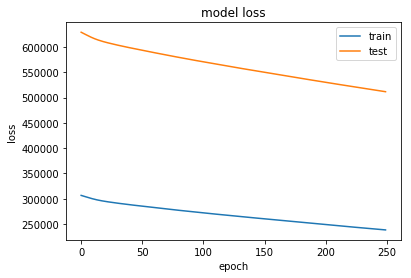

In [254]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

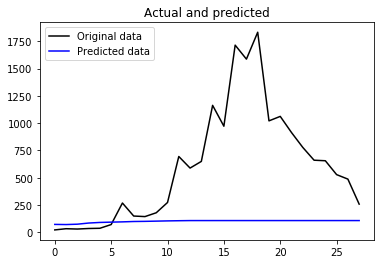

In [255]:
pred = model.predict(np.array(X_test))
original = Y_test
predicted = pred

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted')
plt.show()

### модель посложнее-2, попробовали tanh вместо sigmoid, плохо

In [256]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW))
model.add(Activation('tanh'))
model.add(Dense(360))
model.add(Activation('tanh'))
model.add(Dense(1))
model.add(Activation('linear'))

In [257]:
opt = Nadam(lr=0.0001)

In [258]:
model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

In [259]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 250, 
          batch_size = 15, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 250 samples, validate on 28 samples
Epoch 1/250
250/250 [==============================] - 2s 7ms/step - loss: 306621.4306 - mean_squared_error: 306621.4306 - val_loss: 629236.2165 - val_mean_squared_error: 629236.2165
Epoch 2/250
250/250 [==============================] - 0s 151us/step - loss: 305648.6278 - mean_squared_error: 305648.6278 - val_loss: 627452.0681 - val_mean_squared_error: 627452.0681
Epoch 3/250
250/250 [==============================] - 0s 143us/step - loss: 304504.0811 - mean_squared_error: 304504.0811 - val_loss: 625467.5128 - val_mean_squared_error: 625467.5128
Epoch 4/250
250/250 [==============================] - 0s 145us/step - loss: 303266.3067 - mean_squared_error: 303266.3067 - val_loss: 623263.9353 - val_mean_squared_error: 623263.9353
Epoch 5/250
250/250 [==============================] - 0s 149us/step - loss: 301849.2208 - mean_squared_error: 301849.2208 - val_loss: 620898.0184 - val_mean_squared_error: 620898.0184
Epoch 6/250
250/250 [===========

Epoch 45/250
250/250 [==============================] - 0s 161us/step - loss: 275245.8219 - mean_squared_error: 275245.8219 - val_loss: 572097.2896 - val_mean_squared_error: 572097.2896
Epoch 46/250
250/250 [==============================] - 0s 165us/step - loss: 274842.2641 - mean_squared_error: 274842.2641 - val_loss: 571364.6842 - val_mean_squared_error: 571364.6842
Epoch 47/250
250/250 [==============================] - 0s 169us/step - loss: 274452.5628 - mean_squared_error: 274452.5628 - val_loss: 570620.6334 - val_mean_squared_error: 570620.6334
Epoch 48/250
250/250 [==============================] - 0s 153us/step - loss: 274055.7541 - mean_squared_error: 274055.7541 - val_loss: 569921.0815 - val_mean_squared_error: 569921.0815
Epoch 49/250
250/250 [==============================] - 0s 151us/step - loss: 273673.9058 - mean_squared_error: 273673.9058 - val_loss: 569186.0167 - val_mean_squared_error: 569186.0167
Epoch 50/250
250/250 [==============================] - 0s 149us/step 

250/250 [==============================] - 0s 167us/step - loss: 258706.5709 - mean_squared_error: 258706.5709 - val_loss: 543264.3783 - val_mean_squared_error: 543264.3783
Epoch 90/250
250/250 [==============================] - 0s 194us/step - loss: 258343.8108 - mean_squared_error: 258343.8108 - val_loss: 542658.8661 - val_mean_squared_error: 542658.8661
Epoch 91/250
250/250 [==============================] - 0s 167us/step - loss: 257980.8283 - mean_squared_error: 257980.8283 - val_loss: 542048.4660 - val_mean_squared_error: 542048.4660
Epoch 92/250
250/250 [==============================] - 0s 175us/step - loss: 257612.0986 - mean_squared_error: 257612.0986 - val_loss: 541476.0530 - val_mean_squared_error: 541476.0530
Epoch 93/250
250/250 [==============================] - 0s 183us/step - loss: 257264.8177 - mean_squared_error: 257264.8177 - val_loss: 540851.1451 - val_mean_squared_error: 540851.1451
Epoch 94/250
250/250 [==============================] - 0s 188us/step - loss: 25689

Epoch 133/250
250/250 [==============================] - 0s 155us/step - loss: 242715.6634 - mean_squared_error: 242715.6634 - val_loss: 517762.9258 - val_mean_squared_error: 517762.9258
Epoch 134/250
250/250 [==============================] - 0s 159us/step - loss: 242330.9198 - mean_squared_error: 242330.9198 - val_loss: 517222.5301 - val_mean_squared_error: 517222.5301
Epoch 135/250
250/250 [==============================] - 0s 161us/step - loss: 241945.0151 - mean_squared_error: 241945.0151 - val_loss: 516642.1920 - val_mean_squared_error: 516642.1920
Epoch 136/250
250/250 [==============================] - 0s 155us/step - loss: 241553.8994 - mean_squared_error: 241553.8994 - val_loss: 516091.1378 - val_mean_squared_error: 516091.1378
Epoch 137/250
250/250 [==============================] - 0s 149us/step - loss: 241170.0541 - mean_squared_error: 241170.0541 - val_loss: 515529.3610 - val_mean_squared_error: 515529.3610
Epoch 138/250
250/250 [==============================] - 0s 175us

Epoch 177/250
250/250 [==============================] - 0s 157us/step - loss: 227424.2897 - mean_squared_error: 227424.2897 - val_loss: 492734.9333 - val_mean_squared_error: 492734.9333
Epoch 178/250
250/250 [==============================] - 0s 151us/step - loss: 227107.5055 - mean_squared_error: 227107.5055 - val_loss: 492179.3245 - val_mean_squared_error: 492179.3245
Epoch 179/250
250/250 [==============================] - 0s 160us/step - loss: 226796.7764 - mean_squared_error: 226796.7764 - val_loss: 491608.7977 - val_mean_squared_error: 491608.7977
Epoch 180/250
250/250 [==============================] - 0s 161us/step - loss: 226489.8594 - mean_squared_error: 226489.8594 - val_loss: 491052.9166 - val_mean_squared_error: 491052.9166
Epoch 181/250
250/250 [==============================] - 0s 159us/step - loss: 226165.3212 - mean_squared_error: 226165.3212 - val_loss: 490497.9858 - val_mean_squared_error: 490497.9858
Epoch 182/250
250/250 [==============================] - 0s 155us

Epoch 221/250
250/250 [==============================] - 0s 183us/step - loss: 214137.7540 - mean_squared_error: 214137.7540 - val_loss: 468904.3270 - val_mean_squared_error: 468904.3270
Epoch 222/250
250/250 [==============================] - 0s 155us/step - loss: 213852.7244 - mean_squared_error: 213852.7244 - val_loss: 468364.7260 - val_mean_squared_error: 468364.7260
Epoch 223/250
250/250 [==============================] - 0s 153us/step - loss: 213557.0205 - mean_squared_error: 213557.0205 - val_loss: 467844.7754 - val_mean_squared_error: 467844.7754
Epoch 224/250
250/250 [==============================] - 0s 155us/step - loss: 213267.8523 - mean_squared_error: 213267.8523 - val_loss: 467316.0645 - val_mean_squared_error: 467316.0645
Epoch 225/250
250/250 [==============================] - 0s 156us/step - loss: 212981.8283 - mean_squared_error: 212981.8283 - val_loss: 466798.6903 - val_mean_squared_error: 466798.6903
Epoch 226/250
250/250 [==============================] - 0s 173us

#### графики

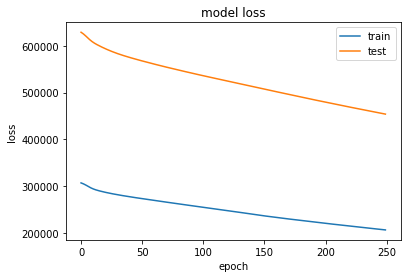

In [260]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

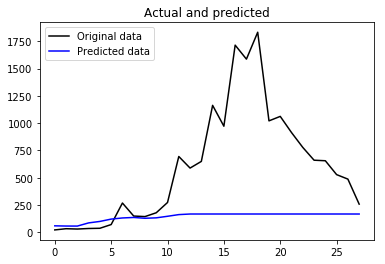

In [261]:
pred = model.predict(np.array(X_test))
original = Y_test
predicted = pred

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted')
plt.show()

### модель посложнее-3,  добавили reduce lr

In [262]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW))
model.add(Activation('sigmoid'))
model.add(Dense(360))
model.add(Activation('sigmoid'))
model.add(Dense(1))
model.add(Activation('linear'))

In [263]:
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)

In [264]:
opt = Nadam(lr=0.0001)

In [265]:
model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

In [266]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 250, 
          batch_size = 15, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 250 samples, validate on 28 samples
Epoch 1/250
250/250 [==============================] - 2s 8ms/step - loss: 305546.6778 - mean_squared_error: 305546.6778 - val_loss: 627535.6970 - val_mean_squared_error: 627535.6970

Epoch 00001: val_loss improved from inf to 627535.69699, saving model to test.hdf5


C:\Pythonn\Anaconda3\lib\site-packages\keras\callbacks.py:972: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_mse` which is not available. Available metrics are: val_loss,val_mean_squared_error,loss,mean_squared_error,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/250
250/250 [==============================] - 0s 153us/step - loss: 304843.6303 - mean_squared_error: 304843.6303 - val_loss: 626293.5876 - val_mean_squared_error: 626293.5876

Epoch 00002: val_loss improved from 627535.69699 to 626293.58761, saving model to test.hdf5
Epoch 3/250
250/250 [==============================] - 0s 153us/step - loss: 304071.3973 - mean_squared_error: 304071.3973 - val_loss: 625004.4950 - val_mean_squared_error: 625004.4950

Epoch 00003: val_loss improved from 626293.58761 to 625004.49498, saving model to test.hdf5
Epoch 4/250
250/250 [==============================] - 0s 165us/step - loss: 303308.2286 - mean_squared_error: 303308.2286 - val_loss: 623702.4414 - val_mean_squared_error: 623702.4414

Epoch 00004: val_loss improved from 625004.49498 to 623702.44141, saving model to test.hdf5
Epoch 5/250
250/250 [==============================] - 0s 159us/step - loss: 302530.1139 - mean_squared_error: 302530.1139 - val_loss: 622441.8733 - val_mean_squared_

250/250 [==============================] - 0s 157us/step - loss: 281062.8023 - mean_squared_error: 281062.8023 - val_loss: 586412.6942 - val_mean_squared_error: 586412.6942

Epoch 00060: val_loss improved from 586874.88951 to 586412.69420, saving model to test.hdf5
Epoch 61/250
250/250 [==============================] - 0s 167us/step - loss: 280794.4551 - mean_squared_error: 280794.4551 - val_loss: 585939.4972 - val_mean_squared_error: 585939.4972

Epoch 00061: val_loss improved from 586412.69420 to 585939.49721, saving model to test.hdf5
Epoch 62/250
250/250 [==============================] - 0s 161us/step - loss: 280521.2056 - mean_squared_error: 280521.2056 - val_loss: 585474.7126 - val_mean_squared_error: 585474.7126

Epoch 00062: val_loss improved from 585939.49721 to 585474.71261, saving model to test.hdf5
Epoch 63/250
250/250 [==============================] - 0s 155us/step - loss: 280254.0186 - mean_squared_error: 280254.0186 - val_loss: 584996.4576 - val_mean_squared_error: 58

250/250 [==============================] - 0s 163us/step - loss: 265348.1313 - mean_squared_error: 265348.1313 - val_loss: 558961.7606 - val_mean_squared_error: 558961.7606

Epoch 00118: val_loss improved from 559415.25502 to 558961.76060, saving model to test.hdf5
Epoch 119/250
250/250 [==============================] - 0s 165us/step - loss: 265089.3589 - mean_squared_error: 265089.3589 - val_loss: 558511.9269 - val_mean_squared_error: 558511.9269

Epoch 00119: val_loss improved from 558961.76060 to 558511.92690, saving model to test.hdf5
Epoch 120/250
250/250 [==============================] - 0s 186us/step - loss: 264832.3937 - mean_squared_error: 264832.3937 - val_loss: 558062.1596 - val_mean_squared_error: 558062.1596

Epoch 00120: val_loss improved from 558511.92690 to 558062.15960, saving model to test.hdf5
Epoch 121/250
250/250 [==============================] - 0s 166us/step - loss: 264574.8442 - mean_squared_error: 264574.8442 - val_loss: 557611.2667 - val_mean_squared_error:

250/250 [==============================] - 0s 169us/step - loss: 250948.7034 - mean_squared_error: 250948.7034 - val_loss: 533872.0318 - val_mean_squared_error: 533872.0318

Epoch 00176: val_loss improved from 534296.23940 to 533872.03181, saving model to test.hdf5
Epoch 177/250
250/250 [==============================] - 0s 166us/step - loss: 250706.6903 - mean_squared_error: 250706.6903 - val_loss: 533464.0011 - val_mean_squared_error: 533464.0011

Epoch 00177: val_loss improved from 533872.03181 to 533464.00112, saving model to test.hdf5
Epoch 178/250
250/250 [==============================] - 0s 173us/step - loss: 250473.4518 - mean_squared_error: 250473.4518 - val_loss: 533042.9157 - val_mean_squared_error: 533042.9157

Epoch 00178: val_loss improved from 533464.00112 to 533042.91574, saving model to test.hdf5
Epoch 179/250
250/250 [==============================] - 0s 159us/step - loss: 250232.5464 - mean_squared_error: 250232.5464 - val_loss: 532634.0971 - val_mean_squared_error:

250/250 [==============================] - 0s 166us/step - loss: 237620.5325 - mean_squared_error: 237620.5325 - val_loss: 510336.7891 - val_mean_squared_error: 510336.7891

Epoch 00234: val_loss improved from 510731.04967 to 510336.78906, saving model to test.hdf5
Epoch 235/250
250/250 [==============================] - 0s 167us/step - loss: 237399.9067 - mean_squared_error: 237399.9067 - val_loss: 509935.8432 - val_mean_squared_error: 509935.8432

Epoch 00235: val_loss improved from 510336.78906 to 509935.84319, saving model to test.hdf5
Epoch 236/250
250/250 [==============================] - 0s 174us/step - loss: 237173.8636 - mean_squared_error: 237173.8636 - val_loss: 509548.1373 - val_mean_squared_error: 509548.1373

Epoch 00236: val_loss improved from 509935.84319 to 509548.13728, saving model to test.hdf5
Epoch 237/250
250/250 [==============================] - 0s 163us/step - loss: 236956.0691 - mean_squared_error: 236956.0691 - val_loss: 509148.7193 - val_mean_squared_error:

#### графики

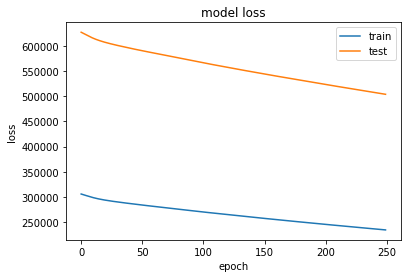

In [267]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

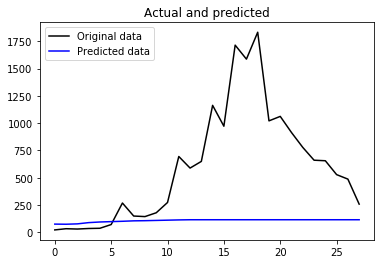

In [268]:
pred = model.predict(np.array(X_test))
original = Y_test
predicted = pred

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted')
plt.show()

### модель посложнее 4 увеличили шаг, добавили регуляризацию, заменили сигмоид на релу

In [370]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW,
                activity_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))

model.add(Dense(360,
                activity_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('linear'))

In [371]:
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.9, patience=50, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)

In [372]:
opt = Nadam(lr=0.001)

In [373]:
model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

In [374]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 550, 
          batch_size = 15, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 250 samples, validate on 28 samples
Epoch 1/550
250/250 [==============================] - 2s 8ms/step - loss: 303360.6311 - mean_squared_error: 303358.9619 - val_loss: 612578.3923 - val_mean_squared_error: 612574.5530

Epoch 00001: val_loss improved from inf to 612578.39230, saving model to test.hdf5


C:\Pythonn\Anaconda3\lib\site-packages\keras\callbacks.py:972: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_mse` which is not available. Available metrics are: val_loss,val_mean_squared_error,loss,mean_squared_error,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/550
250/250 [==============================] - 0s 187us/step - loss: 278397.9463 - mean_squared_error: 278386.1578 - val_loss: 532154.6105 - val_mean_squared_error: 532117.6261

Epoch 00002: val_loss improved from 612578.39230 to 532154.61049, saving model to test.hdf5
Epoch 3/550
250/250 [==============================] - 0s 175us/step - loss: 202852.8522 - mean_squared_error: 202765.0696 - val_loss: 364746.9925 - val_mean_squared_error: 364544.6758

Epoch 00003: val_loss improved from 532154.61049 to 364746.99247, saving model to test.hdf5
Epoch 4/550
250/250 [==============================] - 0s 173us/step - loss: 100291.7488 - mean_squared_error: 99993.8313 - val_loss: 199128.5198 - val_mean_squared_error: 198528.1124

Epoch 00004: val_loss improved from 364746.99247 to 199128.51981, saving model to test.hdf5
Epoch 5/550
250/250 [==============================] - 0s 192us/step - loss: 54795.1360 - mean_squared_error: 54192.6334 - val_loss: 148807.0653 - val_mean_squared_err

250/250 [==============================] - 0s 179us/step - loss: 27714.2240 - mean_squared_error: 27049.8671 - val_loss: 102386.6875 - val_mean_squared_error: 101449.9262

Epoch 00066: val_loss did not improve from 101990.56975
Epoch 67/550
250/250 [==============================] - 0s 163us/step - loss: 27587.8681 - mean_squared_error: 26956.3453 - val_loss: 101283.3397 - val_mean_squared_error: 100304.0166

Epoch 00067: val_loss improved from 101990.56975 to 101283.33970, saving model to test.hdf5
Epoch 68/550
250/250 [==============================] - 0s 163us/step - loss: 27848.4566 - mean_squared_error: 27174.2948 - val_loss: 102566.6208 - val_mean_squared_error: 101603.6123

Epoch 00068: val_loss did not improve from 101283.33970
Epoch 69/550
250/250 [==============================] - 0s 161us/step - loss: 27262.3032 - mean_squared_error: 26598.8928 - val_loss: 101604.3386 - val_mean_squared_error: 100659.4805

Epoch 00069: val_loss did not improve from 101283.33970
Epoch 70/550



Epoch 00099: val_loss did not improve from 99477.88783
Epoch 100/550
250/250 [==============================] - 0s 210us/step - loss: 24787.3782 - mean_squared_error: 24066.1743 - val_loss: 106282.3910 - val_mean_squared_error: 105241.9622

Epoch 00100: val_loss did not improve from 99477.88783
Epoch 101/550
250/250 [==============================] - 0s 198us/step - loss: 24824.5295 - mean_squared_error: 24081.2608 - val_loss: 105908.0979 - val_mean_squared_error: 104881.7016

Epoch 00101: val_loss did not improve from 99477.88783
Epoch 102/550
250/250 [==============================] - 0s 196us/step - loss: 24660.2193 - mean_squared_error: 23932.1282 - val_loss: 105025.3531 - val_mean_squared_error: 103999.8450

Epoch 00102: val_loss did not improve from 99477.88783
Epoch 103/550
250/250 [==============================] - 0s 200us/step - loss: 24642.8411 - mean_squared_error: 23903.2564 - val_loss: 105079.3495 - val_mean_squared_error: 104045.1635

Epoch 00103: val_loss did not impro


Epoch 00133: val_loss did not improve from 99477.88783
Epoch 134/550
250/250 [==============================] - 0s 206us/step - loss: 23213.9625 - mean_squared_error: 22435.6255 - val_loss: 108741.9526 - val_mean_squared_error: 107634.2116

Epoch 00134: val_loss did not improve from 99477.88783
Epoch 135/550
250/250 [==============================] - 0s 190us/step - loss: 23293.3490 - mean_squared_error: 22499.6981 - val_loss: 107378.8839 - val_mean_squared_error: 106267.5585

Epoch 00135: val_loss did not improve from 99477.88783
Epoch 136/550
250/250 [==============================] - 0s 200us/step - loss: 22967.3164 - mean_squared_error: 22168.9658 - val_loss: 109970.9255 - val_mean_squared_error: 108887.7582

Epoch 00136: val_loss did not improve from 99477.88783
Epoch 137/550
250/250 [==============================] - 0s 194us/step - loss: 23164.9443 - mean_squared_error: 22370.9621 - val_loss: 110351.9501 - val_mean_squared_error: 109247.5852

Epoch 00137: val_loss did not impro


Epoch 00167: val_loss did not improve from 99477.88783
Epoch 168/550
250/250 [==============================] - 0s 186us/step - loss: 21695.4053 - mean_squared_error: 20879.7232 - val_loss: 111866.6006 - val_mean_squared_error: 110770.1667

Epoch 00168: val_loss did not improve from 99477.88783
Epoch 169/550
250/250 [==============================] - 0s 198us/step - loss: 21600.7537 - mean_squared_error: 20812.7444 - val_loss: 109100.8569 - val_mean_squared_error: 107958.4519

Epoch 00169: val_loss did not improve from 99477.88783
Epoch 170/550
250/250 [==============================] - 0s 194us/step - loss: 21633.2540 - mean_squared_error: 20817.6807 - val_loss: 111211.3691 - val_mean_squared_error: 110107.1203

Epoch 00170: val_loss did not improve from 99477.88783
Epoch 171/550
250/250 [==============================] - 0s 200us/step - loss: 21496.2876 - mean_squared_error: 20707.0538 - val_loss: 109881.4789 - val_mean_squared_error: 108765.1885

Epoch 00171: val_loss did not impro


Epoch 00201: val_loss did not improve from 99477.88783
Epoch 202/550
250/250 [==============================] - 0s 224us/step - loss: 20402.3772 - mean_squared_error: 19601.5272 - val_loss: 109866.4728 - val_mean_squared_error: 108740.2938

Epoch 00202: val_loss did not improve from 99477.88783
Epoch 203/550
250/250 [==============================] - 0s 218us/step - loss: 20296.5578 - mean_squared_error: 19497.3127 - val_loss: 111500.3605 - val_mean_squared_error: 110395.6399

Epoch 00203: val_loss did not improve from 99477.88783
Epoch 204/550
250/250 [==============================] - 0s 232us/step - loss: 20864.0220 - mean_squared_error: 20062.7068 - val_loss: 114222.6715 - val_mean_squared_error: 113147.8757

Epoch 00204: val_loss did not improve from 99477.88783
Epoch 205/550
250/250 [==============================] - 0s 222us/step - loss: 21106.3844 - mean_squared_error: 20311.6359 - val_loss: 115247.4314 - val_mean_squared_error: 114174.1123

Epoch 00205: val_loss did not impro


Epoch 00235: val_loss did not improve from 99477.88783
Epoch 236/550
250/250 [==============================] - 0s 190us/step - loss: 19175.0423 - mean_squared_error: 18392.6711 - val_loss: 117620.4588 - val_mean_squared_error: 116560.0525

Epoch 00236: val_loss did not improve from 99477.88783
Epoch 237/550
250/250 [==============================] - 0s 202us/step - loss: 19252.8294 - mean_squared_error: 18480.4263 - val_loss: 115465.2810 - val_mean_squared_error: 114407.0368

Epoch 00237: val_loss did not improve from 99477.88783
Epoch 238/550
250/250 [==============================] - 0s 192us/step - loss: 19338.9897 - mean_squared_error: 18569.6008 - val_loss: 115747.8722 - val_mean_squared_error: 114687.7125

Epoch 00238: val_loss did not improve from 99477.88783
Epoch 239/550
250/250 [==============================] - 0s 198us/step - loss: 19735.5037 - mean_squared_error: 18971.5376 - val_loss: 114882.5043 - val_mean_squared_error: 113806.6692

Epoch 00239: val_loss did not impro


Epoch 00269: val_loss did not improve from 99477.88783
Epoch 270/550
250/250 [==============================] - 0s 208us/step - loss: 18397.2583 - mean_squared_error: 17667.3641 - val_loss: 112944.9844 - val_mean_squared_error: 111908.9570

Epoch 00270: val_loss did not improve from 99477.88783
Epoch 271/550
250/250 [==============================] - 0s 192us/step - loss: 18384.6842 - mean_squared_error: 17639.0940 - val_loss: 118797.4983 - val_mean_squared_error: 117786.7789

Epoch 00271: val_loss did not improve from 99477.88783
Epoch 272/550
250/250 [==============================] - 0s 194us/step - loss: 18333.9580 - mean_squared_error: 17607.6485 - val_loss: 116634.7620 - val_mean_squared_error: 115613.7150

Epoch 00272: val_loss did not improve from 99477.88783
Epoch 273/550
250/250 [==============================] - 0s 194us/step - loss: 17918.9372 - mean_squared_error: 17180.6949 - val_loss: 117186.7508 - val_mean_squared_error: 116183.0385

Epoch 00273: val_loss did not impro


Epoch 00303: val_loss did not improve from 99477.88783
Epoch 304/550
250/250 [==============================] - 0s 196us/step - loss: 17174.1383 - mean_squared_error: 16468.6597 - val_loss: 116844.9487 - val_mean_squared_error: 115864.1676

Epoch 00304: val_loss did not improve from 99477.88783
Epoch 305/550
250/250 [==============================] - 0s 192us/step - loss: 17473.8552 - mean_squared_error: 16766.4535 - val_loss: 121599.1342 - val_mean_squared_error: 120641.5028

Epoch 00305: val_loss did not improve from 99477.88783
Epoch 306/550
250/250 [==============================] - 0s 202us/step - loss: 16993.9823 - mean_squared_error: 16299.4425 - val_loss: 119954.0257 - val_mean_squared_error: 119002.7871

Epoch 00306: val_loss did not improve from 99477.88783
Epoch 307/550
250/250 [==============================] - 0s 206us/step - loss: 17119.8241 - mean_squared_error: 16421.1011 - val_loss: 118391.0091 - val_mean_squared_error: 117436.2101

Epoch 00307: val_loss did not impro


Epoch 00337: val_loss did not improve from 99477.88783
Epoch 338/550
250/250 [==============================] - 0s 192us/step - loss: 16125.9227 - mean_squared_error: 15457.6100 - val_loss: 120494.1836 - val_mean_squared_error: 119576.0237

Epoch 00338: val_loss did not improve from 99477.88783
Epoch 339/550
250/250 [==============================] - 0s 192us/step - loss: 16280.2907 - mean_squared_error: 15611.8277 - val_loss: 120236.0406 - val_mean_squared_error: 119325.9441

Epoch 00339: val_loss did not improve from 99477.88783
Epoch 340/550
250/250 [==============================] - 0s 192us/step - loss: 16265.9614 - mean_squared_error: 15604.1336 - val_loss: 120075.0426 - val_mean_squared_error: 119160.7136

Epoch 00340: val_loss did not improve from 99477.88783
Epoch 341/550
250/250 [==============================] - 0s 185us/step - loss: 16501.7103 - mean_squared_error: 15831.5301 - val_loss: 119778.0576 - val_mean_squared_error: 118870.8142

Epoch 00341: val_loss did not impro


Epoch 00371: val_loss did not improve from 99477.88783
Epoch 372/550
250/250 [==============================] - 0s 222us/step - loss: 15649.7459 - mean_squared_error: 15010.3192 - val_loss: 123139.9030 - val_mean_squared_error: 122285.8938

Epoch 00372: val_loss did not improve from 99477.88783
Epoch 373/550
250/250 [==============================] - 0s 228us/step - loss: 15322.6649 - mean_squared_error: 14683.6864 - val_loss: 123334.0844 - val_mean_squared_error: 122478.9177

Epoch 00373: val_loss did not improve from 99477.88783
Epoch 374/550
250/250 [==============================] - 0s 220us/step - loss: 15626.9915 - mean_squared_error: 14992.5199 - val_loss: 120935.3909 - val_mean_squared_error: 120069.3090

Epoch 00374: val_loss did not improve from 99477.88783
Epoch 375/550
250/250 [==============================] - 0s 224us/step - loss: 15476.8290 - mean_squared_error: 14837.6045 - val_loss: 122531.1915 - val_mean_squared_error: 121668.5426

Epoch 00375: val_loss did not impro


Epoch 00405: val_loss did not improve from 99477.88783
Epoch 406/550
250/250 [==============================] - 0s 192us/step - loss: 14774.0572 - mean_squared_error: 14161.1843 - val_loss: 123441.3451 - val_mean_squared_error: 122616.0783

Epoch 00406: val_loss did not improve from 99477.88783
Epoch 407/550
250/250 [==============================] - 0s 183us/step - loss: 14619.5441 - mean_squared_error: 14008.4087 - val_loss: 122282.4422 - val_mean_squared_error: 121462.7870

Epoch 00407: val_loss did not improve from 99477.88783
Epoch 408/550
250/250 [==============================] - 0s 198us/step - loss: 14776.2689 - mean_squared_error: 14163.0988 - val_loss: 127311.7814 - val_mean_squared_error: 126510.4502

Epoch 00408: val_loss did not improve from 99477.88783
Epoch 409/550
250/250 [==============================] - 0s 208us/step - loss: 14523.3126 - mean_squared_error: 13919.0227 - val_loss: 121303.4770 - val_mean_squared_error: 120481.4262

Epoch 00409: val_loss did not impro


Epoch 00439: val_loss did not improve from 99477.88783
Epoch 440/550
250/250 [==============================] - 0s 194us/step - loss: 13964.6360 - mean_squared_error: 13382.0495 - val_loss: 123080.7155 - val_mean_squared_error: 122303.5194

Epoch 00440: val_loss did not improve from 99477.88783
Epoch 441/550
250/250 [==============================] - 0s 192us/step - loss: 13655.1835 - mean_squared_error: 13067.7762 - val_loss: 126346.2729 - val_mean_squared_error: 125577.5485

Epoch 00441: val_loss did not improve from 99477.88783
Epoch 442/550
250/250 [==============================] - 0s 200us/step - loss: 13913.5519 - mean_squared_error: 13336.1215 - val_loss: 125739.0566 - val_mean_squared_error: 124964.1556

Epoch 00442: val_loss did not improve from 99477.88783
Epoch 443/550
250/250 [==============================] - 0s 200us/step - loss: 13939.7558 - mean_squared_error: 13349.1202 - val_loss: 129656.4425 - val_mean_squared_error: 128909.4011

Epoch 00443: val_loss did not impro


Epoch 00473: val_loss did not improve from 99477.88783
Epoch 474/550
250/250 [==============================] - 0s 192us/step - loss: 14306.5733 - mean_squared_error: 13750.8486 - val_loss: 122739.1663 - val_mean_squared_error: 121987.2144

Epoch 00474: val_loss did not improve from 99477.88783
Epoch 475/550
250/250 [==============================] - 0s 200us/step - loss: 13684.1343 - mean_squared_error: 13123.0905 - val_loss: 122276.3881 - val_mean_squared_error: 121524.7063

Epoch 00475: val_loss did not improve from 99477.88783
Epoch 476/550
250/250 [==============================] - 0s 188us/step - loss: 13161.3826 - mean_squared_error: 12603.7858 - val_loss: 125157.8984 - val_mean_squared_error: 124425.1945

Epoch 00476: val_loss did not improve from 99477.88783
Epoch 477/550
250/250 [==============================] - 0s 185us/step - loss: 12789.5899 - mean_squared_error: 12236.9134 - val_loss: 125441.4608 - val_mean_squared_error: 124695.0439

Epoch 00477: val_loss did not impro


Epoch 00507: val_loss did not improve from 99477.88783
Epoch 508/550
250/250 [==============================] - 0s 226us/step - loss: 12377.6562 - mean_squared_error: 11836.0962 - val_loss: 128297.0230 - val_mean_squared_error: 127604.1073

Epoch 00508: val_loss did not improve from 99477.88783
Epoch 509/550
250/250 [==============================] - 0s 208us/step - loss: 12825.6650 - mean_squared_error: 12292.7407 - val_loss: 123771.4746 - val_mean_squared_error: 123066.6567

Epoch 00509: val_loss did not improve from 99477.88783
Epoch 510/550
250/250 [==============================] - 0s 208us/step - loss: 12074.1481 - mean_squared_error: 11537.7160 - val_loss: 125786.1512 - val_mean_squared_error: 125076.9311

Epoch 00510: val_loss did not improve from 99477.88783
Epoch 511/550
250/250 [==============================] - 0s 208us/step - loss: 12456.9485 - mean_squared_error: 11926.2659 - val_loss: 121020.4262 - val_mean_squared_error: 120293.4930

Epoch 00511: val_loss did not impro


Epoch 00541: val_loss did not improve from 99477.88783
Epoch 542/550
250/250 [==============================] - 0s 218us/step - loss: 11663.5002 - mean_squared_error: 11143.4943 - val_loss: 123243.3177 - val_mean_squared_error: 122545.1381

Epoch 00542: val_loss did not improve from 99477.88783
Epoch 543/550
250/250 [==============================] - 0s 200us/step - loss: 11831.3588 - mean_squared_error: 11308.2905 - val_loss: 128098.1200 - val_mean_squared_error: 127436.3647

Epoch 00543: val_loss did not improve from 99477.88783
Epoch 544/550
250/250 [==============================] - 0s 204us/step - loss: 11393.7557 - mean_squared_error: 10875.4790 - val_loss: 121381.5964 - val_mean_squared_error: 120685.1512

Epoch 00544: val_loss did not improve from 99477.88783
Epoch 545/550
250/250 [==============================] - 0s 202us/step - loss: 11360.5353 - mean_squared_error: 10840.7155 - val_loss: 122959.5173 - val_mean_squared_error: 122267.4574

Epoch 00545: val_loss did not impro

#### графики

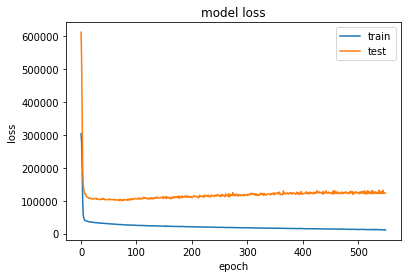

In [375]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

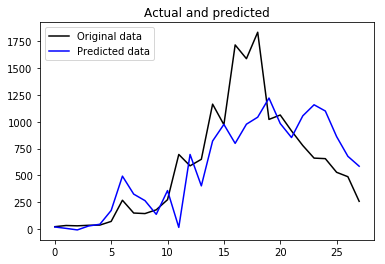

In [376]:
pred = model.predict(np.array(X_test))
original = Y_test
predicted = pred

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted')
plt.show()

### модель посложнее 5 добавили batch normalization

In [356]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW,
                activity_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(360,
                activity_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('linear'))

In [357]:
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.9, patience=50, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)

In [358]:
opt = Nadam(lr=0.001)

In [359]:
model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

In [360]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 550, 
          batch_size = 15, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 250 samples, validate on 28 samples
Epoch 1/550
250/250 [==============================] - 4s 14ms/step - loss: 302328.4731 - mean_squared_error: 302325.9606 - val_loss: 610087.6568 - val_mean_squared_error: 610084.7087


C:\Pythonn\Anaconda3\lib\site-packages\keras\callbacks.py:972: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_mse` which is not available. Available metrics are: val_loss,val_mean_squared_error,loss,mean_squared_error,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning



Epoch 00001: val_loss improved from inf to 610087.65681, saving model to test.hdf5
Epoch 2/550
250/250 [==============================] - 0s 208us/step - loss: 295476.2434 - mean_squared_error: 295472.7667 - val_loss: 593811.8538 - val_mean_squared_error: 593807.3945

Epoch 00002: val_loss improved from 610087.65681 to 593811.85379, saving model to test.hdf5
Epoch 3/550
250/250 [==============================] - 0s 216us/step - loss: 290246.2569 - mean_squared_error: 290241.8172 - val_loss: 581979.6869 - val_mean_squared_error: 581974.1122

Epoch 00003: val_loss improved from 593811.85379 to 581979.68694, saving model to test.hdf5
Epoch 4/550
250/250 [==============================] - 0s 212us/step - loss: 285718.2616 - mean_squared_error: 285713.0841 - val_loss: 570319.9989 - val_mean_squared_error: 570313.3666

Epoch 00004: val_loss improved from 581979.68694 to 570319.99888, saving model to test.hdf5
Epoch 5/550
250/250 [==============================] - 0s 212us/step - loss: 28118


Epoch 00031: val_loss improved from 252366.59263 to 244428.20340, saving model to test.hdf5
Epoch 32/550
250/250 [==============================] - 0s 230us/step - loss: 85021.3628 - mean_squared_error: 85009.9765 - val_loss: 219860.4651 - val_mean_squared_error: 219848.4191

Epoch 00032: val_loss improved from 244428.20340 to 219860.46512, saving model to test.hdf5
Epoch 33/550
250/250 [==============================] - 0s 244us/step - loss: 79255.9430 - mean_squared_error: 79243.9383 - val_loss: 226308.5379 - val_mean_squared_error: 226295.3033

Epoch 00033: val_loss did not improve from 219860.46512
Epoch 34/550
250/250 [==============================] - 0s 238us/step - loss: 79591.8680 - mean_squared_error: 79580.0399 - val_loss: 212520.3114 - val_mean_squared_error: 212507.0109

Epoch 00034: val_loss improved from 219860.46512 to 212520.31138, saving model to test.hdf5
Epoch 35/550
250/250 [==============================] - 0s 224us/step - loss: 64948.2396 - mean_squared_error: 6

250/250 [==============================] - 0s 228us/step - loss: 38014.8450 - mean_squared_error: 38004.7029 - val_loss: 109861.5202 - val_mean_squared_error: 109852.1948

Epoch 00063: val_loss did not improve from 99942.97182
Epoch 64/550
250/250 [==============================] - 0s 226us/step - loss: 31979.4434 - mean_squared_error: 31969.3403 - val_loss: 101040.1523 - val_mean_squared_error: 101030.3910

Epoch 00064: val_loss did not improve from 99942.97182
Epoch 65/550
250/250 [==============================] - 0s 224us/step - loss: 31999.0336 - mean_squared_error: 31989.2210 - val_loss: 101367.2426 - val_mean_squared_error: 101357.9664

Epoch 00065: val_loss did not improve from 99942.97182
Epoch 66/550
250/250 [==============================] - 0s 228us/step - loss: 31161.9141 - mean_squared_error: 31152.3419 - val_loss: 97741.1910 - val_mean_squared_error: 97731.2234

Epoch 00066: val_loss improved from 99942.97182 to 97741.19099, saving model to test.hdf5
Epoch 67/550
250/250


Epoch 00096: val_loss did not improve from 88045.70571
Epoch 97/550
250/250 [==============================] - 0s 224us/step - loss: 28234.1670 - mean_squared_error: 28225.0413 - val_loss: 91955.5262 - val_mean_squared_error: 91945.8351

Epoch 00097: val_loss did not improve from 88045.70571
Epoch 98/550
250/250 [==============================] - 0s 222us/step - loss: 29194.4650 - mean_squared_error: 29185.9820 - val_loss: 102218.1682 - val_mean_squared_error: 102208.7453

Epoch 00098: val_loss did not improve from 88045.70571
Epoch 99/550
250/250 [==============================] - 0s 230us/step - loss: 23991.9736 - mean_squared_error: 23983.6322 - val_loss: 93738.4754 - val_mean_squared_error: 93729.6858

Epoch 00099: val_loss did not improve from 88045.70571
Epoch 100/550
250/250 [==============================] - 0s 232us/step - loss: 23607.7223 - mean_squared_error: 23599.4152 - val_loss: 91104.2639 - val_mean_squared_error: 91094.1656

Epoch 00100: val_loss did not improve from 8

250/250 [==============================] - 0s 272us/step - loss: 20897.7947 - mean_squared_error: 20890.3204 - val_loss: 78511.0519 - val_mean_squared_error: 78502.3087

Epoch 00164: val_loss did not improve from 74596.32432
Epoch 165/550
250/250 [==============================] - 0s 230us/step - loss: 24997.9720 - mean_squared_error: 24990.6395 - val_loss: 84615.1933 - val_mean_squared_error: 84606.3745

Epoch 00165: val_loss did not improve from 74596.32432
Epoch 166/550
250/250 [==============================] - 0s 226us/step - loss: 22975.1833 - mean_squared_error: 22967.5297 - val_loss: 85424.9329 - val_mean_squared_error: 85416.6824

Epoch 00166: val_loss did not improve from 74596.32432
Epoch 167/550
250/250 [==============================] - 0s 246us/step - loss: 19396.1912 - mean_squared_error: 19388.7716 - val_loss: 83828.9487 - val_mean_squared_error: 83820.7400

Epoch 00167: val_loss did not improve from 74596.32432
Epoch 168/550
250/250 [==============================] - 0


Epoch 00197: val_loss improved from 68694.00659 to 63830.02019, saving model to test.hdf5
Epoch 198/550
250/250 [==============================] - 0s 268us/step - loss: 21065.2389 - mean_squared_error: 21057.1022 - val_loss: 68133.1210 - val_mean_squared_error: 68123.4879

Epoch 00198: val_loss did not improve from 63830.02019
Epoch 199/550
250/250 [==============================] - 0s 264us/step - loss: 13255.9623 - mean_squared_error: 13248.0193 - val_loss: 73417.1910 - val_mean_squared_error: 73408.0386

Epoch 00199: val_loss did not improve from 63830.02019
Epoch 200/550
250/250 [==============================] - 0s 264us/step - loss: 15700.5869 - mean_squared_error: 15692.9884 - val_loss: 78946.3426 - val_mean_squared_error: 78938.2285

Epoch 00200: val_loss did not improve from 63830.02019
Epoch 201/550
250/250 [==============================] - 0s 262us/step - loss: 28198.7185 - mean_squared_error: 28191.5972 - val_loss: 79951.2247 - val_mean_squared_error: 79942.1880

Epoch 00

250/250 [==============================] - 0s 250us/step - loss: 23736.5421 - mean_squared_error: 23729.7523 - val_loss: 77544.3080 - val_mean_squared_error: 77535.6816

Epoch 00232: val_loss did not improve from 63830.02019
Epoch 233/550
250/250 [==============================] - 0s 250us/step - loss: 21135.5398 - mean_squared_error: 21128.4306 - val_loss: 75585.0656 - val_mean_squared_error: 75576.9934

Epoch 00233: val_loss did not improve from 63830.02019
Epoch 234/550
250/250 [==============================] - 0s 228us/step - loss: 16365.6324 - mean_squared_error: 16358.3602 - val_loss: 76097.6874 - val_mean_squared_error: 76088.5078

Epoch 00234: val_loss did not improve from 63830.02019
Epoch 235/550
250/250 [==============================] - 0s 234us/step - loss: 19906.6515 - mean_squared_error: 19899.5251 - val_loss: 74415.3692 - val_mean_squared_error: 74406.6387

Epoch 00235: val_loss did not improve from 63830.02019
Epoch 236/550
250/250 [==============================] - 0

250/250 [==============================] - 0s 232us/step - loss: 17667.3541 - mean_squared_error: 17660.1243 - val_loss: 70987.1994 - val_mean_squared_error: 70978.1165

Epoch 00300: val_loss did not improve from 60832.77759
Epoch 301/550
250/250 [==============================] - 0s 258us/step - loss: 20895.8801 - mean_squared_error: 20888.4230 - val_loss: 66114.7245 - val_mean_squared_error: 66105.8849

Epoch 00301: val_loss did not improve from 60832.77759
Epoch 302/550
250/250 [==============================] - 0s 236us/step - loss: 14724.9445 - mean_squared_error: 14717.8519 - val_loss: 69245.0917 - val_mean_squared_error: 69236.4810

Epoch 00302: val_loss did not improve from 60832.77759
Epoch 303/550
250/250 [==============================] - 0s 232us/step - loss: 12717.9423 - mean_squared_error: 12710.8937 - val_loss: 66288.5951 - val_mean_squared_error: 66279.3652

Epoch 00303: val_loss did not improve from 60832.77759
Epoch 304/550
250/250 [==============================] - 0

250/250 [==============================] - 0s 226us/step - loss: 22100.7823 - mean_squared_error: 22093.9867 - val_loss: 66732.0371 - val_mean_squared_error: 66723.9623

Epoch 00368: val_loss did not improve from 60832.77759
Epoch 369/550
250/250 [==============================] - 0s 252us/step - loss: 17820.2879 - mean_squared_error: 17813.0325 - val_loss: 69417.4083 - val_mean_squared_error: 69409.6146

Epoch 00369: val_loss did not improve from 60832.77759
Epoch 370/550
250/250 [==============================] - 0s 230us/step - loss: 17602.3363 - mean_squared_error: 17595.1737 - val_loss: 74156.9038 - val_mean_squared_error: 74149.5467

Epoch 00370: val_loss did not improve from 60832.77759
Epoch 371/550
250/250 [==============================] - 0s 228us/step - loss: 13906.7562 - mean_squared_error: 13899.5748 - val_loss: 67131.7631 - val_mean_squared_error: 67123.6640

Epoch 00371: val_loss did not improve from 60832.77759
Epoch 372/550
250/250 [==============================] - 0

250/250 [==============================] - 0s 272us/step - loss: 14692.5113 - mean_squared_error: 14684.3396 - val_loss: 73348.6937 - val_mean_squared_error: 73338.2887

Epoch 00436: val_loss did not improve from 60832.77759
Epoch 437/550
250/250 [==============================] - 0s 270us/step - loss: 24191.3512 - mean_squared_error: 24183.3392 - val_loss: 66035.4420 - val_mean_squared_error: 66024.9100

Epoch 00437: val_loss did not improve from 60832.77759
Epoch 438/550
250/250 [==============================] - 0s 280us/step - loss: 26677.4057 - mean_squared_error: 26668.9881 - val_loss: 75197.6646 - val_mean_squared_error: 75187.4552

Epoch 00438: val_loss did not improve from 60832.77759
Epoch 439/550
250/250 [==============================] - 0s 256us/step - loss: 14254.8026 - mean_squared_error: 14246.3203 - val_loss: 73316.2889 - val_mean_squared_error: 73306.8845

Epoch 00439: val_loss did not improve from 60832.77759
Epoch 440/550
250/250 [==============================] - 0

250/250 [==============================] - 0s 230us/step - loss: 13914.2754 - mean_squared_error: 13905.7106 - val_loss: 67574.7479 - val_mean_squared_error: 67564.8543

Epoch 00504: val_loss did not improve from 59346.93757
Epoch 505/550
250/250 [==============================] - 0s 226us/step - loss: 15231.1964 - mean_squared_error: 15222.9103 - val_loss: 71355.1078 - val_mean_squared_error: 71345.8117

Epoch 00505: val_loss did not improve from 59346.93757
Epoch 506/550
250/250 [==============================] - 0s 234us/step - loss: 18818.2654 - mean_squared_error: 18809.6490 - val_loss: 70823.5521 - val_mean_squared_error: 70812.8404

Epoch 00506: val_loss did not improve from 59346.93757
Epoch 507/550
250/250 [==============================] - 0s 236us/step - loss: 13765.9580 - mean_squared_error: 13757.4374 - val_loss: 66067.3942 - val_mean_squared_error: 66056.7926

Epoch 00507: val_loss did not improve from 59346.93757
Epoch 508/550
250/250 [==============================] - 0

#### графики

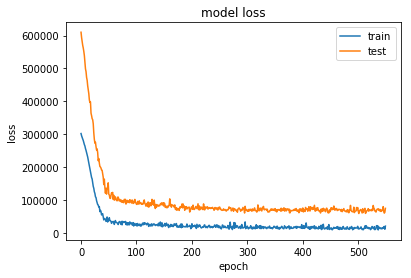

In [361]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

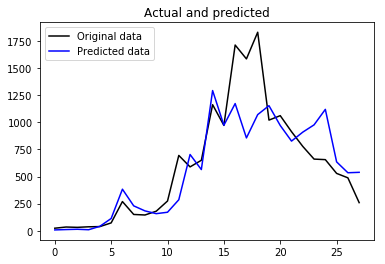

In [362]:
pred = model.predict(np.array(X_test))
original = Y_test
predicted = pred

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted')
plt.show()

### модель посложнее 6, заменили relu на leaky relu, увеличили вес регуляризаций

In [304]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW,
                activity_regularizer=regularizers.l2(0.05)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.65))
model.add(Dense(360,
                activity_regularizer=regularizers.l2(0.05)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(1))
model.add(Activation('linear'))

In [305]:
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)

In [306]:
opt = Nadam(lr=0.001)

In [307]:
model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

In [308]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 550, 
          batch_size = 15, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 250 samples, validate on 28 samples
Epoch 1/550
250/250 [==============================] - 2s 9ms/step - loss: 304243.0286 - mean_squared_error: 303938.0913 - val_loss: 618311.4102 - val_mean_squared_error: 618120.7556

Epoch 00001: val_loss improved from inf to 618311.41016, saving model to test.hdf5


C:\Pythonn\Anaconda3\lib\site-packages\keras\callbacks.py:972: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_mse` which is not available. Available metrics are: val_loss,val_mean_squared_error,loss,mean_squared_error,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/550
250/250 [==============================] - 0s 204us/step - loss: 297477.1981 - mean_squared_error: 297023.7381 - val_loss: 602628.0686 - val_mean_squared_error: 602235.9375

Epoch 00002: val_loss improved from 618311.41016 to 602628.06864, saving model to test.hdf5
Epoch 3/550
250/250 [==============================] - 0s 214us/step - loss: 292609.8230 - mean_squared_error: 291958.8232 - val_loss: 590501.4062 - val_mean_squared_error: 589934.1122

Epoch 00003: val_loss improved from 602628.06864 to 590501.40625, saving model to test.hdf5
Epoch 4/550
250/250 [==============================] - 0s 192us/step - loss: 287559.1014 - mean_squared_error: 286745.7081 - val_loss: 581016.4983 - val_mean_squared_error: 580290.4235

Epoch 00004: val_loss improved from 590501.40625 to 581016.49833, saving model to test.hdf5
Epoch 5/550
250/250 [==============================] - 0s 198us/step - loss: 282682.0800 - mean_squared_error: 281760.7388 - val_loss: 571484.6953 - val_mean_squared_

250/250 [==============================] - 0s 230us/step - loss: 58138.1586 - mean_squared_error: 57255.9795 - val_loss: 138102.7455 - val_mean_squared_error: 137320.8493

Epoch 00061: val_loss did not improve from 133751.73744
Epoch 62/550
250/250 [==============================] - 0s 230us/step - loss: 49828.5521 - mean_squared_error: 48988.0795 - val_loss: 132396.0444 - val_mean_squared_error: 131587.5370

Epoch 00062: val_loss improved from 133751.73744 to 132396.04436, saving model to test.hdf5
Epoch 63/550
250/250 [==============================] - 0s 237us/step - loss: 50104.3531 - mean_squared_error: 49234.9511 - val_loss: 125508.3185 - val_mean_squared_error: 124719.8039

Epoch 00063: val_loss improved from 132396.04436 to 125508.31850, saving model to test.hdf5
Epoch 64/550
250/250 [==============================] - 0s 246us/step - loss: 52959.8014 - mean_squared_error: 52155.2970 - val_loss: 125165.0848 - val_mean_squared_error: 124400.7570

Epoch 00064: val_loss improved fr


Epoch 00126: val_loss did not improve from 102361.22545
Epoch 127/550
250/250 [==============================] - 0s 238us/step - loss: 39357.8285 - mean_squared_error: 38621.9564 - val_loss: 108485.8669 - val_mean_squared_error: 107862.5537

Epoch 00127: val_loss did not improve from 102361.22545
Epoch 128/550
250/250 [==============================] - 0s 266us/step - loss: 45691.1408 - mean_squared_error: 44979.4567 - val_loss: 107709.0446 - val_mean_squared_error: 107073.6221

Epoch 00128: val_loss did not improve from 102361.22545
Epoch 129/550
250/250 [==============================] - 0s 236us/step - loss: 39077.1315 - mean_squared_error: 38365.4741 - val_loss: 108430.8259 - val_mean_squared_error: 107773.3809

Epoch 00129: val_loss did not improve from 102361.22545
Epoch 130/550
250/250 [==============================] - 0s 258us/step - loss: 48490.3332 - mean_squared_error: 47757.8105 - val_loss: 109211.2190 - val_mean_squared_error: 108537.3020

Epoch 00130: val_loss did not i


Epoch 00193: val_loss did not improve from 98876.88588
Epoch 194/550
250/250 [==============================] - 0s 270us/step - loss: 40099.2354 - mean_squared_error: 39443.5732 - val_loss: 109455.8354 - val_mean_squared_error: 108901.7118

Epoch 00194: val_loss did not improve from 98876.88588
Epoch 195/550
250/250 [==============================] - 0s 280us/step - loss: 40692.7380 - mean_squared_error: 40088.1521 - val_loss: 107891.6126 - val_mean_squared_error: 107338.2386

Epoch 00195: val_loss did not improve from 98876.88588
Epoch 196/550
250/250 [==============================] - 0s 269us/step - loss: 37934.4261 - mean_squared_error: 37299.5067 - val_loss: 106830.5276 - val_mean_squared_error: 106249.0791

Epoch 00196: val_loss did not improve from 98876.88588
Epoch 197/550
250/250 [==============================] - 0s 266us/step - loss: 42986.0368 - mean_squared_error: 42357.0575 - val_loss: 106520.2107 - val_mean_squared_error: 105931.9735

Epoch 00197: val_loss did not impro


Epoch 00227: val_loss did not improve from 98876.88588
Epoch 228/550
250/250 [==============================] - 0s 274us/step - loss: 47266.4970 - mean_squared_error: 46607.7114 - val_loss: 110940.2256 - val_mean_squared_error: 110406.3570

Epoch 00228: val_loss did not improve from 98876.88588
Epoch 229/550
250/250 [==============================] - 0s 276us/step - loss: 43531.1013 - mean_squared_error: 42960.9091 - val_loss: 112544.4205 - val_mean_squared_error: 112029.0232

Epoch 00229: val_loss did not improve from 98876.88588
Epoch 230/550
250/250 [==============================] - 0s 260us/step - loss: 48029.0651 - mean_squared_error: 47426.3979 - val_loss: 107679.8878 - val_mean_squared_error: 107147.8744

Epoch 00230: val_loss did not improve from 98876.88588
Epoch 231/550
250/250 [==============================] - 0s 270us/step - loss: 37623.0471 - mean_squared_error: 36994.7185 - val_loss: 104684.8751 - val_mean_squared_error: 104145.0070

Epoch 00231: val_loss did not impro

250/250 [==============================] - 0s 264us/step - loss: 38599.0717 - mean_squared_error: 37994.1915 - val_loss: 105326.2267 - val_mean_squared_error: 104761.4367

Epoch 00262: val_loss did not improve from 98876.88588
Epoch 263/550
250/250 [==============================] - 0s 246us/step - loss: 43556.0154 - mean_squared_error: 42951.4527 - val_loss: 105417.8806 - val_mean_squared_error: 104830.2080

Epoch 00263: val_loss did not improve from 98876.88588
Epoch 264/550
250/250 [==============================] - 0s 264us/step - loss: 36413.9397 - mean_squared_error: 35791.2895 - val_loss: 107411.4918 - val_mean_squared_error: 106847.7586

Epoch 00264: val_loss did not improve from 98876.88588
Epoch 265/550
250/250 [==============================] - 0s 239us/step - loss: 40354.6864 - mean_squared_error: 39778.4845 - val_loss: 108371.9051 - val_mean_squared_error: 107846.2102

Epoch 00265: val_loss did not improve from 98876.88588
Epoch 266/550
250/250 [===========================

250/250 [==============================] - 0s 233us/step - loss: 37650.6643 - mean_squared_error: 37059.3807 - val_loss: 108191.0956 - val_mean_squared_error: 107703.9000

Epoch 00296: val_loss did not improve from 98820.80176
Epoch 297/550
250/250 [==============================] - 0s 233us/step - loss: 40343.6717 - mean_squared_error: 39773.3457 - val_loss: 112743.2260 - val_mean_squared_error: 112244.4925

Epoch 00297: val_loss did not improve from 98820.80176
Epoch 298/550
250/250 [==============================] - 0s 244us/step - loss: 39946.1078 - mean_squared_error: 39366.9068 - val_loss: 106474.6023 - val_mean_squared_error: 105963.3153

Epoch 00298: val_loss did not improve from 98820.80176
Epoch 299/550
250/250 [==============================] - 0s 232us/step - loss: 40000.9622 - mean_squared_error: 39423.4319 - val_loss: 105936.4118 - val_mean_squared_error: 105376.4347

Epoch 00299: val_loss did not improve from 98820.80176
Epoch 300/550
250/250 [===========================

250/250 [==============================] - 0s 252us/step - loss: 33103.8726 - mean_squared_error: 32495.2972 - val_loss: 96698.7665 - val_mean_squared_error: 96118.8677

Epoch 00330: val_loss improved from 98820.80176 to 96698.76646, saving model to test.hdf5
Epoch 331/550
250/250 [==============================] - 0s 236us/step - loss: 33817.5284 - mean_squared_error: 33199.3512 - val_loss: 99662.9668 - val_mean_squared_error: 99119.2598

Epoch 00331: val_loss did not improve from 96698.76646
Epoch 332/550
250/250 [==============================] - 0s 218us/step - loss: 33869.2861 - mean_squared_error: 33265.1376 - val_loss: 106372.0074 - val_mean_squared_error: 105860.3651

Epoch 00332: val_loss did not improve from 96698.76646
Epoch 333/550
250/250 [==============================] - 0s 234us/step - loss: 41042.2532 - mean_squared_error: 40479.3393 - val_loss: 106556.5593 - val_mean_squared_error: 106037.5776

Epoch 00333: val_loss did not improve from 96698.76646
Epoch 334/550
250/2

250/250 [==============================] - 0s 232us/step - loss: 45900.0335 - mean_squared_error: 45334.0997 - val_loss: 106435.0891 - val_mean_squared_error: 105919.6383

Epoch 00364: val_loss did not improve from 96698.76646
Epoch 365/550
250/250 [==============================] - 0s 238us/step - loss: 36340.0881 - mean_squared_error: 35761.6046 - val_loss: 107146.9665 - val_mean_squared_error: 106628.5668

Epoch 00365: val_loss did not improve from 96698.76646
Epoch 366/550
250/250 [==============================] - 0s 230us/step - loss: 42281.6237 - mean_squared_error: 41709.4342 - val_loss: 106789.2426 - val_mean_squared_error: 106279.2268

Epoch 00366: val_loss did not improve from 96698.76646
Epoch 367/550
250/250 [==============================] - 0s 240us/step - loss: 42076.6767 - mean_squared_error: 41508.4068 - val_loss: 104866.4231 - val_mean_squared_error: 104356.4166

Epoch 00367: val_loss did not improve from 96698.76646
Epoch 368/550
250/250 [===========================

250/250 [==============================] - 0s 246us/step - loss: 31953.2907 - mean_squared_error: 31340.3568 - val_loss: 104994.7478 - val_mean_squared_error: 104458.3521

Epoch 00398: val_loss did not improve from 96698.76646
Epoch 399/550
250/250 [==============================] - 0s 256us/step - loss: 39813.8214 - mean_squared_error: 39226.2768 - val_loss: 107514.6297 - val_mean_squared_error: 106996.6491

Epoch 00399: val_loss did not improve from 96698.76646
Epoch 400/550
250/250 [==============================] - 0s 234us/step - loss: 37287.2197 - mean_squared_error: 36708.7825 - val_loss: 106586.4632 - val_mean_squared_error: 106057.6742

Epoch 00400: val_loss did not improve from 96698.76646
Epoch 401/550
250/250 [==============================] - 0s 236us/step - loss: 46696.2344 - mean_squared_error: 46109.9279 - val_loss: 108226.6769 - val_mean_squared_error: 107697.2218

Epoch 00401: val_loss did not improve from 96698.76646
Epoch 402/550
250/250 [===========================

250/250 [==============================] - 0s 220us/step - loss: 38975.8445 - mean_squared_error: 38381.0882 - val_loss: 103574.8193 - val_mean_squared_error: 103070.9985

Epoch 00432: val_loss did not improve from 96698.76646
Epoch 433/550
250/250 [==============================] - 0s 232us/step - loss: 35246.6427 - mean_squared_error: 34650.2887 - val_loss: 103185.6932 - val_mean_squared_error: 102668.5686

Epoch 00433: val_loss did not improve from 96698.76646
Epoch 434/550
250/250 [==============================] - 0s 222us/step - loss: 42952.4408 - mean_squared_error: 42387.8035 - val_loss: 103133.7157 - val_mean_squared_error: 102607.2641

Epoch 00434: val_loss did not improve from 96698.76646
Epoch 435/550
250/250 [==============================] - 0s 225us/step - loss: 38405.0404 - mean_squared_error: 37809.2704 - val_loss: 101685.2833 - val_mean_squared_error: 101141.5547

Epoch 00435: val_loss did not improve from 96698.76646
Epoch 436/550
250/250 [===========================

250/250 [==============================] - 0s 268us/step - loss: 42731.1732 - mean_squared_error: 42176.8017 - val_loss: 106050.0826 - val_mean_squared_error: 105587.9734

Epoch 00466: val_loss did not improve from 96698.76646
Epoch 467/550
250/250 [==============================] - 0s 290us/step - loss: 47780.8624 - mean_squared_error: 47228.8260 - val_loss: 104459.3337 - val_mean_squared_error: 103985.5349

Epoch 00467: val_loss did not improve from 96698.76646
Epoch 468/550
250/250 [==============================] - 0s 282us/step - loss: 47552.4233 - mean_squared_error: 47023.4356 - val_loss: 102470.2939 - val_mean_squared_error: 101971.9103

Epoch 00468: val_loss did not improve from 96698.76646
Epoch 469/550
250/250 [==============================] - 0s 280us/step - loss: 46870.1050 - mean_squared_error: 46306.0025 - val_loss: 102404.2271 - val_mean_squared_error: 101888.1030

Epoch 00469: val_loss did not improve from 96698.76646
Epoch 470/550
250/250 [===========================

250/250 [==============================] - 0s 234us/step - loss: 37235.3115 - mean_squared_error: 36645.0720 - val_loss: 102522.6532 - val_mean_squared_error: 101984.0257

Epoch 00534: val_loss did not improve from 96698.76646
Epoch 535/550
250/250 [==============================] - 0s 234us/step - loss: 38681.0798 - mean_squared_error: 38082.7724 - val_loss: 100644.1197 - val_mean_squared_error: 100111.8899

Epoch 00535: val_loss did not improve from 96698.76646
Epoch 536/550
250/250 [==============================] - 0s 232us/step - loss: 31478.8498 - mean_squared_error: 30881.3381 - val_loss: 98955.3883 - val_mean_squared_error: 98408.2412

Epoch 00536: val_loss did not improve from 96698.76646
Epoch 537/550
250/250 [==============================] - 0s 232us/step - loss: 36603.3013 - mean_squared_error: 35963.6448 - val_loss: 99188.6204 - val_mean_squared_error: 98639.5562

Epoch 00537: val_loss did not improve from 96698.76646
Epoch 538/550
250/250 [==============================]

#### графики

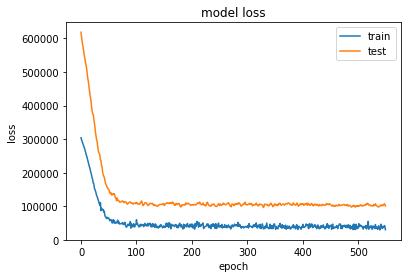

In [311]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

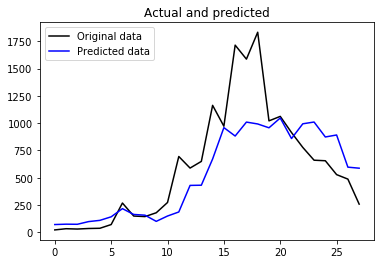

In [312]:
pred = model.predict(np.array(X_test))
original = Y_test
predicted = pred

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted')
plt.show()

### модель посложнее 6, модель переобучилась, уменьшили кол-во эпох

1. непонятно на что влияет параметр verbose, но изменение его с 1 на 2 увеличило стабильность
2. побольше почитать про reducelronPlateau
3. 

In [14]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW,
                activity_regularizer=regularizers.l2(0.05)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.65))
model.add(Dense(360,
                activity_regularizer=regularizers.l2(0.05)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(1))
model.add(Activation('linear'))

In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.9, patience=50, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)

In [16]:
opt = Nadam(lr=0.001)

In [335]:
model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

In [336]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 350, 
          batch_size = 15, 
          verbose=2, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 250 samples, validate on 28 samples
Epoch 1/350
 - 2s - loss: 303378.5072 - mean_squared_error: 303065.5887 - val_loss: 616338.1256 - val_mean_squared_error: 616156.7517

Epoch 00001: val_loss improved from inf to 616338.12556, saving model to test.hdf5


C:\Pythonn\Anaconda3\lib\site-packages\keras\callbacks.py:972: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_mse` which is not available. Available metrics are: val_loss,val_mean_squared_error,loss,mean_squared_error,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/350
 - 0s - loss: 297166.1620 - mean_squared_error: 296715.0109 - val_loss: 598270.5921 - val_mean_squared_error: 597839.2132

Epoch 00002: val_loss improved from 616338.12556 to 598270.59208, saving model to test.hdf5
Epoch 3/350
 - 0s - loss: 291691.8453 - mean_squared_error: 291024.1237 - val_loss: 584815.1624 - val_mean_squared_error: 584184.3744

Epoch 00003: val_loss improved from 598270.59208 to 584815.16239, saving model to test.hdf5
Epoch 4/350
 - 0s - loss: 286852.4126 - mean_squared_error: 286026.0280 - val_loss: 573870.4420 - val_mean_squared_error: 573102.0575

Epoch 00004: val_loss improved from 584815.16239 to 573870.44196, saving model to test.hdf5
Epoch 5/350
 - 0s - loss: 281740.5975 - mean_squared_error: 280816.3535 - val_loss: 563652.8092 - val_mean_squared_error: 562706.2556

Epoch 00005: val_loss improved from 573870.44196 to 563652.80915, saving model to test.hdf5
Epoch 6/350
 - 0s - loss: 277485.1901 - mean_squared_error: 276469.2164 - val_loss: 554253.4

 - 0s - loss: 92894.5422 - mean_squared_error: 91762.1895 - val_loss: 206333.9007 - val_mean_squared_error: 205127.1713

Epoch 00038: val_loss improved from 216043.93164 to 206333.90067, saving model to test.hdf5
Epoch 39/350
 - 0s - loss: 86236.1068 - mean_squared_error: 85116.2433 - val_loss: 195839.6144 - val_mean_squared_error: 194611.3616

Epoch 00039: val_loss improved from 206333.90067 to 195839.61440, saving model to test.hdf5
Epoch 40/350
 - 0s - loss: 83790.5183 - mean_squared_error: 82686.7742 - val_loss: 192360.7302 - val_mean_squared_error: 191181.2564

Epoch 00040: val_loss improved from 195839.61440 to 192360.73019, saving model to test.hdf5
Epoch 41/350
 - 0s - loss: 78879.5955 - mean_squared_error: 77749.1210 - val_loss: 189325.7840 - val_mean_squared_error: 188092.2985

Epoch 00041: val_loss improved from 192360.73019 to 189325.78404, saving model to test.hdf5
Epoch 42/350
 - 0s - loss: 78132.0481 - mean_squared_error: 77031.5318 - val_loss: 183757.0045 - val_mean_squ


Epoch 00076: val_loss improved from 110959.74261 to 110646.54311, saving model to test.hdf5
Epoch 77/350
 - 0s - loss: 50699.1269 - mean_squared_error: 49842.2387 - val_loss: 108114.8899 - val_mean_squared_error: 107375.7457

Epoch 00077: val_loss improved from 110646.54311 to 108114.88993, saving model to test.hdf5
Epoch 78/350
 - 0s - loss: 45307.7615 - mean_squared_error: 44455.6159 - val_loss: 107153.9641 - val_mean_squared_error: 106409.7528

Epoch 00078: val_loss improved from 108114.88993 to 107153.96415, saving model to test.hdf5
Epoch 79/350
 - 0s - loss: 34927.7847 - mean_squared_error: 34021.8156 - val_loss: 110234.6381 - val_mean_squared_error: 109471.3954

Epoch 00079: val_loss did not improve from 107153.96415
Epoch 80/350
 - 0s - loss: 49444.4335 - mean_squared_error: 48627.7202 - val_loss: 109000.1415 - val_mean_squared_error: 108300.8859

Epoch 00080: val_loss did not improve from 107153.96415
Epoch 81/350
 - 0s - loss: 41870.0749 - mean_squared_error: 41060.0250 - va


Epoch 00118: val_loss did not improve from 99796.84249
Epoch 119/350
 - 0s - loss: 39775.2527 - mean_squared_error: 39047.7063 - val_loss: 104528.0340 - val_mean_squared_error: 103892.4803

Epoch 00119: val_loss did not improve from 99796.84249
Epoch 120/350
 - 0s - loss: 31254.5766 - mean_squared_error: 30521.8377 - val_loss: 103781.4103 - val_mean_squared_error: 103125.0040

Epoch 00120: val_loss did not improve from 99796.84249
Epoch 121/350
 - 0s - loss: 49642.0360 - mean_squared_error: 48912.7890 - val_loss: 103226.4739 - val_mean_squared_error: 102551.2688

Epoch 00121: val_loss did not improve from 99796.84249
Epoch 122/350
 - 0s - loss: 39843.1444 - mean_squared_error: 39117.1638 - val_loss: 105380.2515 - val_mean_squared_error: 104754.0841

Epoch 00122: val_loss did not improve from 99796.84249
Epoch 123/350
 - 0s - loss: 49086.9259 - mean_squared_error: 48444.8064 - val_loss: 109195.8696 - val_mean_squared_error: 108592.5824

Epoch 00123: val_loss did not improve from 99796.


Epoch 00161: val_loss did not improve from 99154.60268
Epoch 162/350
 - 0s - loss: 45768.3760 - mean_squared_error: 45105.0980 - val_loss: 108550.1140 - val_mean_squared_error: 107974.3386

Epoch 00162: val_loss did not improve from 99154.60268
Epoch 163/350
 - 0s - loss: 41714.8998 - mean_squared_error: 41061.5119 - val_loss: 109000.3849 - val_mean_squared_error: 108423.4898

Epoch 00163: val_loss did not improve from 99154.60268
Epoch 164/350
 - 0s - loss: 47969.3206 - mean_squared_error: 47336.5810 - val_loss: 110747.1170 - val_mean_squared_error: 110160.6094

Epoch 00164: val_loss did not improve from 99154.60268
Epoch 165/350
 - 0s - loss: 42784.3328 - mean_squared_error: 42131.1799 - val_loss: 106189.3640 - val_mean_squared_error: 105623.4605

Epoch 00165: val_loss did not improve from 99154.60268
Epoch 166/350
 - 0s - loss: 41847.0296 - mean_squared_error: 41197.5484 - val_loss: 105888.3804 - val_mean_squared_error: 105317.5308

Epoch 00166: val_loss did not improve from 99154.


Epoch 00204: val_loss did not improve from 96930.06306
Epoch 205/350
 - 0s - loss: 41576.0886 - mean_squared_error: 40935.2357 - val_loss: 104912.4867 - val_mean_squared_error: 104369.8186

Epoch 00205: val_loss did not improve from 96930.06306
Epoch 206/350
 - 0s - loss: 39570.7472 - mean_squared_error: 38964.0570 - val_loss: 104674.2864 - val_mean_squared_error: 104123.9876

Epoch 00206: val_loss did not improve from 96930.06306
Epoch 207/350
 - 0s - loss: 43081.1523 - mean_squared_error: 42465.4829 - val_loss: 102466.6585 - val_mean_squared_error: 101905.1720

Epoch 00207: val_loss did not improve from 96930.06306
Epoch 208/350
 - 0s - loss: 45720.6302 - mean_squared_error: 45119.6734 - val_loss: 101004.9032 - val_mean_squared_error: 100420.1765

Epoch 00208: val_loss did not improve from 96930.06306
Epoch 209/350
 - 0s - loss: 41783.6824 - mean_squared_error: 41144.2976 - val_loss: 102950.9826 - val_mean_squared_error: 102363.2182

Epoch 00209: val_loss did not improve from 96930.

 - 0s - loss: 41391.6215 - mean_squared_error: 40753.4477 - val_loss: 107381.9665 - val_mean_squared_error: 106826.3902

Epoch 00248: val_loss did not improve from 96930.06306
Epoch 249/350
 - 0s - loss: 33195.3757 - mean_squared_error: 32572.4785 - val_loss: 106406.0332 - val_mean_squared_error: 105845.8881

Epoch 00249: val_loss did not improve from 96930.06306
Epoch 250/350
 - 0s - loss: 38199.0870 - mean_squared_error: 37584.4435 - val_loss: 106934.1529 - val_mean_squared_error: 106382.0367

Epoch 00250: val_loss did not improve from 96930.06306
Epoch 251/350
 - 0s - loss: 43043.8987 - mean_squared_error: 42434.5514 - val_loss: 107073.9036 - val_mean_squared_error: 106517.3087

Epoch 00251: val_loss did not improve from 96930.06306
Epoch 252/350
 - 0s - loss: 38973.1375 - mean_squared_error: 38353.7913 - val_loss: 105723.0640 - val_mean_squared_error: 105196.2582

Epoch 00252: val_loss did not improve from 96930.06306
Epoch 253/350
 - 0s - loss: 43380.4039 - mean_squared_error: 427


Epoch 00291: val_loss did not improve from 96930.06306
Epoch 292/350
 - 0s - loss: 46682.9116 - mean_squared_error: 46040.6141 - val_loss: 106121.3008 - val_mean_squared_error: 105506.5179

Epoch 00292: val_loss did not improve from 96930.06306
Epoch 293/350
 - 0s - loss: 32030.0982 - mean_squared_error: 31354.7128 - val_loss: 102235.9029 - val_mean_squared_error: 101647.4016

Epoch 00293: val_loss did not improve from 96930.06306
Epoch 294/350
 - 0s - loss: 39239.4662 - mean_squared_error: 38571.8351 - val_loss: 101937.2077 - val_mean_squared_error: 101342.1629

Epoch 00294: val_loss did not improve from 96930.06306
Epoch 295/350
 - 0s - loss: 36607.5055 - mean_squared_error: 35925.4934 - val_loss: 103171.7222 - val_mean_squared_error: 102568.9413

Epoch 00295: val_loss did not improve from 96930.06306
Epoch 296/350
 - 0s - loss: 33787.9805 - mean_squared_error: 33137.3180 - val_loss: 103486.5310 - val_mean_squared_error: 102898.5949

Epoch 00296: val_loss did not improve from 96930.


Epoch 00335: val_loss did not improve from 96930.06306
Epoch 336/350
 - 0s - loss: 41427.5498 - mean_squared_error: 40799.1523 - val_loss: 104703.3958 - val_mean_squared_error: 104127.1198

Epoch 00336: val_loss did not improve from 96930.06306
Epoch 337/350
 - 0s - loss: 32902.2441 - mean_squared_error: 32287.1218 - val_loss: 102251.4845 - val_mean_squared_error: 101683.7222

Epoch 00337: val_loss did not improve from 96930.06306
Epoch 338/350
 - 0s - loss: 40331.9902 - mean_squared_error: 39710.1218 - val_loss: 102322.2853 - val_mean_squared_error: 101773.2302

Epoch 00338: val_loss did not improve from 96930.06306
Epoch 339/350
 - 0s - loss: 35523.0964 - mean_squared_error: 34937.4523 - val_loss: 104098.3772 - val_mean_squared_error: 103567.4081

Epoch 00339: val_loss did not improve from 96930.06306
Epoch 340/350
 - 0s - loss: 33768.4795 - mean_squared_error: 33168.6883 - val_loss: 103612.6175 - val_mean_squared_error: 103070.2298

Epoch 00340: val_loss did not improve from 96930.

#### графики

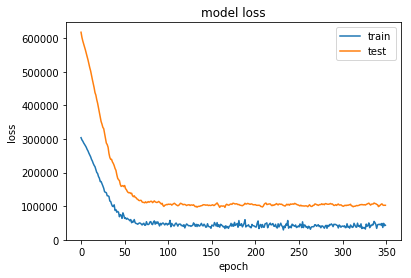

In [295]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

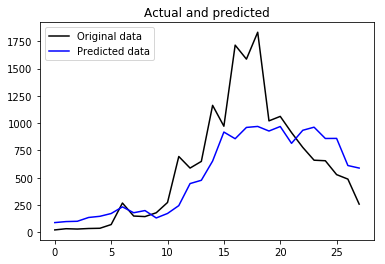

In [296]:
pred = model.predict(np.array(X_test))
original = Y_test
predicted = pred

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted')
plt.show()

### Вывод по регрессии

1. классические функции активации (sigmoid, tanh) не работают вовсе - relu, leaky relu существенно лучше
2. добавление dropout, batchnormalization помогло увеличить общую точность, но пик продаж модель так и не схватывает

## Hyperopt

Гиперопт перестал выдавать прежнюю ошибку, но пока еще не закончен

In [322]:
import hyperas

In [341]:
from hyperopt import Trials, STATUS_OK, tpe
from keras.models import Sequential
from keras.utils import np_utils

from hyperas import optim
from hyperas.distributions import choice, uniform



def create_model(x_train, y_train, x_test, y_test):

    model = Sequential()
    model.add(Dense(164, input_dim=WINDOW, activity_regularizer=regularizers.l2(0.0001)))
#model.add(BatchNormalization())
    model.add(LeakyReLU())

#model.add(Dropout(0.5))
    model.add(Dense(360, activity_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Dense(1))
    model.add(Activation('linear'))

    opt = Nadam(lr=0.001)

    reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
    checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)
    model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mse'])

    model.fit(X_train, Y_train, 
          nb_epoch = 150, 
          batch_size = 15, 
          verbose=2, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

    score, acc = model.evaluate(X_test, Y_test, verbose=2)
    print('Test accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [331]:
if __name__ == '__main__':
    best_run, best_model = optim.minimize(model=create_model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=5,
                                          trials=Trials(),
                                          notebook_name='Keras only')
    X_train, Y_train, X_test, Y_test = data()
    print('Evalutation of best performing model:')
    print(best_model.evaluate(X_test, Y_test))
    print('Best performing model chosen hyper-parameters:')
    print(best_run)

>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import statsmodels.api as sm
except:
    pass

try:
    import statsmodels.tsa.api as smt
except:
    pass

try:
    from statsmodels.tsa.seasonal import seasonal_decompose
except:
    pass

try:
    from statsmodels.tsa.stattools import adfuller
except:
    pass

try:
    import datetime
except:
    pass

try:
    from dateutil.relativedelta import relativedelta
except:
    pass

try:
    from arch import arch_model
except:
    pass

try:
    import keras
except:
    pass

try:
    import matplotlib.pylab as plt
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers.core import Dense, Dropout, Activation, Flatten
except:
    pass

try:
    from keras.layers.normalization import BatchNormalization
ex

TypeError: 2012-09-09      23
2012-09-16      10
2012-09-23       9
2012-09-30       4
2012-10-07       4
2012-10-14       6
2012-10-21       2
2012-10-28       1
2012-11-04       2
2012-11-11       0
2012-11-18       1
2012-11-25       1
2012-12-02       0
2012-12-09       2
2012-12-16       0
2012-12-23       0
2012-12-30       0
2013-01-06       0
2013-01-13       0
2013-01-20       0
2013-01-27       5
2013-02-03       2
2013-02-10       3
2013-02-17      18
2013-02-24      57
2013-03-03     161
2013-03-10     115
2013-03-17     101
2013-03-24     101
2013-03-31     121
              ... 
2018-01-14      42
2018-01-21      33
2018-01-28      23
2018-02-04      34
2018-02-11      31
2018-02-18      36
2018-02-25      38
2018-03-04      72
2018-03-11     269
2018-03-18     150
2018-03-25     145
2018-04-01     180
2018-04-08     274
2018-04-15     695
2018-04-22     589
2018-04-29     650
2018-05-06    1163
2018-05-13     972
2018-05-20    1714
2018-05-27    1586
2018-06-03    1832
2018-06-10    1021
2018-06-17    1062
2018-06-24     914
2018-07-01     778
2018-07-08     661
2018-07-15     656
2018-07-22     529
2018-07-29     488
2018-08-05     259
Name: sales, Length: 309, dtype: int64 is not a module, class, method, function, traceback, frame, or code object

## Другой подход к Keras, через кроссвалидацию, такой же подход использовался затем на методах  sklearn

### функция кроссвалидации, функции ошибок

In [234]:
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) 

        index = int(np.floor(X.shape[0] * split))
    
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)
   
    return errors.mean()

In [91]:
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error, mean_squared_log_error, median_absolute_error, r2_score
from math import sqrt

def rmse(ytrue,ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred));
def mse(ytrue,ypred):
    return (mean_squared_error(ytrue, ypred));
def rmsle(ytrue, ypred):
    return mean_squared_log_error(ytrue, ypred);
def mae (ytrue,ypred):
    return mean_absolute_error(ytrue,ypred);
def r2 (ytrue,ypred):
    return r2_score(ytrue,ypred);
def evs (ytrue,ypred):
    return explained_variance_score(ytrue,ypred);
def medae (ytrue,ypred):
    return median_absolute_error(ytrue,ypred)

### Импорты, подготовка данных

In [93]:
df = pd.read_csv('df')

In [94]:
df.index.name=None
df.reset_index(inplace=True)

In [95]:
start = datetime.datetime.strptime("2012-09-09", "%Y-%m-%d")
date_list = [start + relativedelta(weeks=x) for x in range(0,len(df.sales))]
df['index'] =date_list
df.set_index(['index'], inplace=True)
df.index.name=None

In [96]:
df.head()

,ind,dates,sales,AUP_RUR,AUP_RUR_RRP,AUP+bonus
2012-09-09,1,2012-09-09,23,5658.513739,9619.448357,6612.109391
2012-09-16,2,2012-09-16,10,6065.175200,10238.858811,6762.978200
2012-09-23,3,2012-09-23,9,5876.925926,9058.186700,6231.744815
2012-09-30,4,2012-09-30,4,5319.947500,9415.000000,6163.250000
2012-10-07,5,2012-10-07,4,6731.930000,9415.000000,6807.750000


In [97]:
data2 = copy.deepcopy(df[['dates','sales']])

In [98]:
data2.dates = pd.to_datetime(data2.dates)
data2.TRDATETIME = pd.to_datetime(data2['dates'],  dayfirst= True, format='%d%b%y:%H:%M:%S')

C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [99]:
data2['date'] = data2['dates'].dt.date
data2['day'] = data2['dates'].dt.day
data2['month'] = data2['dates'].dt.month
data2['year'] = data2['dates'].dt.year

In [100]:
data2.head()

,dates,sales,date,day,month,year
2012-09-09,2012-09-09,23,2012-09-09,9,9,2012
2012-09-16,2012-09-16,10,2012-09-16,16,9,2012
2012-09-23,2012-09-23,9,2012-09-23,23,9,2012
2012-09-30,2012-09-30,4,2012-09-30,30,9,2012
2012-10-07,2012-10-07,4,2012-10-07,7,10,2012


In [101]:
data2['season'] = data2.sales

In [102]:
data2['season'].loc['2012':'2013-03-01'] = "aw"
data2['season'].loc['2013-03-01':'2013-09-01'] = "ss"
data2['season'].loc['2013-09-01':'2014-03-01'] = "aw"
data2['season'].loc['2014-03-01':'2014-09-01'] = "ss"
data2['season'].loc['2014-09-01':'2015-03-01'] = "aw"
data2['season'].loc['2015-03-01':'2015-09-01'] = "ss"
data2['season'].loc['2015-09-01':'2016-03-01'] = "aw"
data2['season'].loc['2016-03-01':'2016-09-01'] = "ss"
data2['season'].loc['2016-09-01':'2017-03-01'] = "aw"
data2['season'].loc['2017-03-01':'2017-09-01'] = "ss"
data2['season'].loc['2017-09-01':'2018-03-01'] = "aw"
data2['season'].loc['2018-03-01':'2018-09-01'] = "ss"

C:\Pythonn\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [103]:
data2['Last_Week_Sales'] = data2['sales'].shift()
data2['Last_Week_Diff'] = data2['Last_Week_Sales'].diff()
data2 = data2.dropna()

In [104]:
data2.head()

,dates,sales,date,day,month,year,season,Last_Week_Sales,Last_Week_Diff
2012-09-23,2012-09-23,9,2012-09-23,23,9,2012,aw,10.0,-13.0
2012-09-30,2012-09-30,4,2012-09-30,30,9,2012,aw,9.0,-1.0
2012-10-07,2012-10-07,4,2012-10-07,7,10,2012,aw,4.0,-5.0
2012-10-14,2012-10-14,6,2012-10-14,14,10,2012,aw,4.0,0.0
2012-10-21,2012-10-21,2,2012-10-21,21,10,2012,aw,6.0,2.0


In [105]:
data2['weeks'] = list(range(len(data2.index)))

In [106]:
data2.index = list(range(len(data2.index)))

In [107]:
data2.drop('dates', axis = 1, inplace = True)

In [108]:
data2.drop('date', axis = 1, inplace = True)

In [109]:
data2.head()

,sales,day,month,year,season,Last_Week_Sales,Last_Week_Diff,weeks
0,9,23,9,2012,aw,10.0,-13.0,0
1,4,30,9,2012,aw,9.0,-1.0,1
2,4,7,10,2012,aw,4.0,-5.0,2
3,6,14,10,2012,aw,4.0,0.0,3
4,2,21,10,2012,aw,6.0,2.0,4


In [110]:
data3 = pd.get_dummies(data2)

In [111]:
data3.head()

,sales,day,month,year,Last_Week_Sales,Last_Week_Diff,weeks,season_aw,season_ss
0,9,23,9,2012,10.0,-13.0,0,1,0
1,4,30,9,2012,9.0,-1.0,1,1,0
2,4,7,10,2012,4.0,-5.0,2,1,0
3,6,14,10,2012,4.0,0.0,3,1,0
4,2,21,10,2012,6.0,2.0,4,1,0


In [112]:
Y = data3.sales

In [113]:
X = data3.drop('sales', axis = 1)

In [114]:
X_train = data3[:302].drop('sales', axis = 1)
Y_train = data3[:302].sales

### используем последнюю модель из keras-регрессии

In [229]:
model = Sequential()
model.add(Dense(64, input_dim=8,
                activity_regularizer=regularizers.l2(0.05)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dense(360,
                activity_regularizer=regularizers.l2(0.05)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(1))
model.add(Activation('linear'))

In [230]:
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.9, patience=50, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)

In [231]:
opt = Nadam(lr=0.01)

In [232]:
model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

In [235]:
performTimeSeriesCV(X_train, Y_train, 100, model, rmse)

Size train set: (302, 8)
Size of each fold: 3

Splitting the first 2 chunks at 1/2
Size of train + test: (6, 8)
Epoch 1/1
3/3 [==============================] - 0s 141ms/step - loss: 1011421.0000 - mean_squared_error: 36.7755

Splitting the first 3 chunks at 2/3
Size of train + test: (9, 8)
Epoch 1/1
6/6 [==============================] - 0s 333us/step - loss: 1830994.2500 - mean_squared_error: 16.7057

Splitting the first 4 chunks at 3/4
Size of train + test: (12, 8)
Epoch 1/1
9/9 [==============================] - 0s 332us/step - loss: 2472398.5000 - mean_squared_error: 5.9331

Splitting the first 5 chunks at 4/5
Size of train + test: (15, 8)
Epoch 1/1
12/12 [==============================] - 0s 247us/step - loss: 2936887.5000 - mean_squared_error: 3.8330

Splitting the first 6 chunks at 5/6
Size of train + test: (18, 8)
Epoch 1/1
15/15 [==============================] - 0s 134us/step - loss: 3241257.2500 - mean_squared_error: 8.9236

Splitting the first 7 chunks at 6/7
Size of train

132/132 [==============================] - 0s 98us/step - loss: 33681.2086 - mean_squared_error: 24516.3891

Splitting the first 46 chunks at 45/46
Size of train + test: (138, 8)
Epoch 1/1
135/135 [==============================] - 0s 103us/step - loss: 30310.8307 - mean_squared_error: 18392.3973

Splitting the first 47 chunks at 46/47
Size of train + test: (141, 8)
Epoch 1/1
138/138 [==============================] - 0s 87us/step - loss: 34158.3627 - mean_squared_error: 25375.4474

Splitting the first 48 chunks at 47/48
Size of train + test: (144, 8)
Epoch 1/1
141/141 [==============================] - 0s 92us/step - loss: 62911.4610 - mean_squared_error: 47798.5496

Splitting the first 49 chunks at 48/49
Size of train + test: (147, 8)
Epoch 1/1
144/144 [==============================] - 0s 111us/step - loss: 47179.3372 - mean_squared_error: 34549.7101

Splitting the first 50 chunks at 49/50
Size of train + test: (150, 8)
Epoch 1/1
147/147 [==============================] - 0s 102us/s

261/261 [==============================] - 0s 84us/step - loss: 34178.5720 - mean_squared_error: 25560.8899

Splitting the first 89 chunks at 88/89
Size of train + test: (267, 8)
Epoch 1/1
264/264 [==============================] - 0s 91us/step - loss: 33537.3401 - mean_squared_error: 26409.5452

Splitting the first 90 chunks at 89/90
Size of train + test: (270, 8)
Epoch 1/1
267/267 [==============================] - 0s 86us/step - loss: 43918.3685 - mean_squared_error: 37363.5886

Splitting the first 91 chunks at 90/91
Size of train + test: (273, 8)
Epoch 1/1
270/270 [==============================] - 0s 89us/step - loss: 26425.3574 - mean_squared_error: 22362.6870

Splitting the first 92 chunks at 91/92
Size of train + test: (276, 8)
Epoch 1/1
273/273 [==============================] - 0s 77us/step - loss: 28108.1251 - mean_squared_error: 23984.7644

Splitting the first 93 chunks at 92/93
Size of train + test: (279, 8)
Epoch 1/1
276/276 [==============================] - 0s 90us/step

214.18924004678226

???? еще не сделано финальное предсказание на валидационной выборке. для этого, судя по всему, нужно прописать обучение отдельно без функции????

### Вывод по регрессии на другом наборе данных

1. подход использования данных не в классическом формате временных рядов, а с добавлением фич существенно превзошел классическое использование Keras